In [1]:
from collections import Counter
import string
import sys
from os.path import join

#  SET WHERE THE GITHUB DIRECTORY IS!
GITHUB_DIR = '/Users/zach/Documents/github/covid-bcr/'

sys.path.append(join(GITHUB_DIR, 'scripts'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import Normalize, to_rgb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from cycler import cycler

from scipy.interpolate import interpn
from scipy.stats import pearsonr, mannwhitneyu, f_oneway

from fisher import pvalue_npy

from scipy.special import binom
from scipy.spatial.distance import squareform

from jellyfish import hamming_distance

from utils import *
from abstar_pipeline import *
from plotting_helper import format_axes

sns.set(context='paper', style='white')

plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
global_dpi = 300


LEGEND_SIZE = 8
TICK_SIZE = 10
LABEL_SIZE = 12

plt.rc('axes', titlesize=LABEL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize

color=["#56B4E9","#E69F00",
       "#009E73", "#D55E00", 
       "#CC79A7","#F0E442", 
       "#0072B2","#999999",
       "black","olive"]

plt.rcParams['axes.prop_cycle'] = cycler(color=color)
cmap = ListedColormap(['#6baed6','#4292c6', '#2171b5',
                       '#08519c', '#08306b'])
steelbluecolors = ['#63b8ff','#5cacee','#4f94cd','#36648b','#132B43']
steelblue2= LinearSegmentedColormap.from_list("", steelbluecolors[::-1])
%matplotlib inline

In [2]:
def fexp(f):
    return int(np.floor(np.log10(np.abs(f)))) if f != 0 else 0

def fman(f):
    return f/10**fexp(f)

round_to_n = lambda x, n: round(x, -int(np.floor(np.log10(x))) + (n - 1)) 

# V gene Hamming matrix

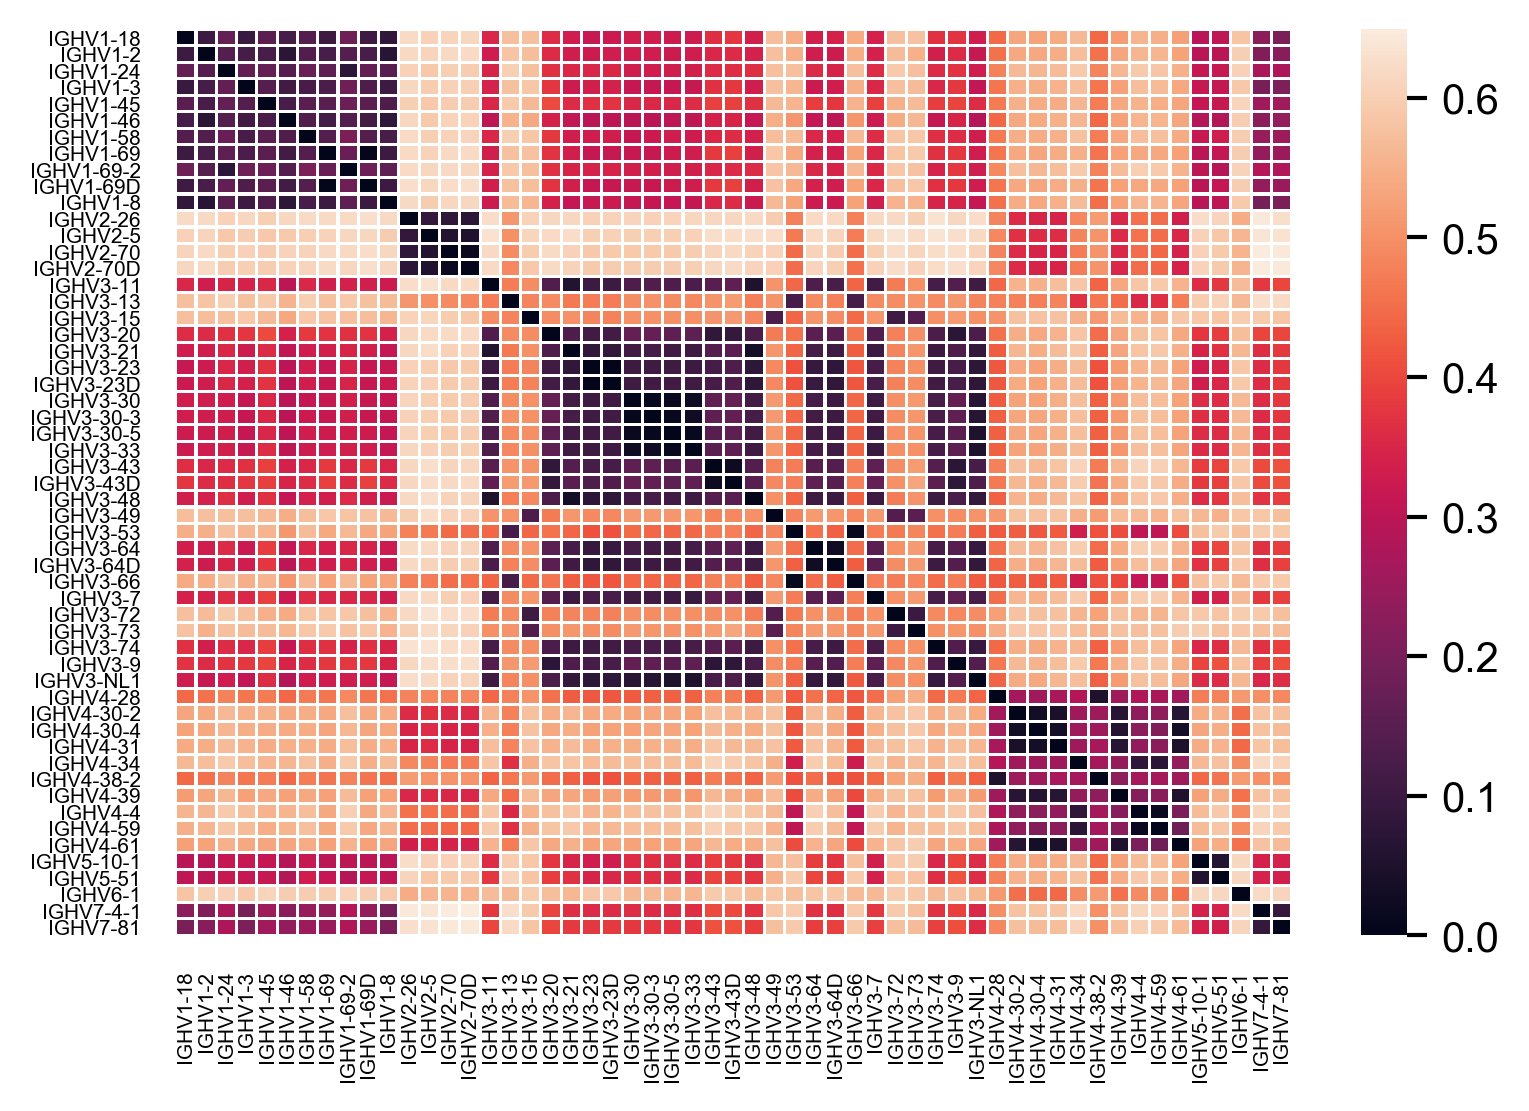

In [3]:
def make_v_ref_dict():
    v_anchors = pd.read_csv(join(GITHUB_DIR, 'sonia_input/V_gene_CDR3_anchors.csv'))
    v_anchors=v_anchors.assign(g=v_anchors['gene'].str.split("*").str[0])
    v_anchors = v_anchors.append({'gene': 'IGHV7-81*01', 'anchor_index': 285,
                                  'function': 'F', 'g': 'IGHV7-81'},ignore_index=True)
    anchor_ind = v_anchors.drop_duplicates('g').set_index('g').loc[v_anchors['g'].unique()]['anchor_index']
    vs,heads = fasta_read(join(GITHUB_DIR, 'igor_input/abstar_genomic_Vs.fasta'))
    vs.append('CAGGTGCAGCTGGTGCAGTCTGGCCATGAGGTGAAGCAGCCTGGGGCCTCAGTGAAGGTCTCCTGCAAGGCTTCTGGTTACAGTTTCACCACCTATGGTATGAATTGGGTGCCACAGGCCCCTGGACAAGGGCTTGAGTGGATGGGATGGTTCAACACCTACACTGGGAACCCAACATATGCCCAGGGCTTCACAGGACGGTTTGTCTTCTCCATGGACACCTCTGCCAGCACAGCATACCTGCAGATCAGCAGCCTAAAGGCTGAGGACATGGCCATGTATTACTGTGCGAGATA')
    heads.append('IGHV7-81*01')
    v_dict = {}
    for idx,h in enumerate(heads):
        gene = h.split("*")[0]
        if gene in v_dict:
            continue
        v_trim = vs[idx][:anchor_ind.loc[gene]]
        if v_trim[-3:] == 'TGT':
            v_trim = v_trim[:-3]
        v_dict[gene] = v_trim
    v_dict = sort_dict(v_dict)
    return v_dict

v_ref = make_v_ref_dict()
v_ref_genes = list(v_ref.keys())
np_v_ref_genes = np.array(v_ref_genes)
v_ham_mat = np.zeros(shape=(len(v_ref),len(v_ref)))
for i,v1 in enumerate(v_ref):
    for j,v2 in enumerate(v_ref):
        g1 = v_ref[v1]
        g2 = v_ref[v2]
        min_len = np.min([len(g1),len(g2)])
        v_ham_mat[i,j] = hamming_distance(g1[-min_len:],g2[-min_len:]) / min_len
        
plt.figure(dpi=300)
ax = sns.heatmap(v_ham_mat, linewidth=0.5)
ax.set_xticks(np.arange(len(v_ref))+0.5);
ax.set_yticks(np.arange(len(v_ref))+0.5);
ax.set_xticklabels(v_ref_genes,rotation=90,fontsize=5);
ax.set_yticklabels(v_ref_genes,rotation=0,fontsize=5);

# Load known mAbs

In [5]:
in_mab_abs = pd.read_csv(join(GITHUB_DIR,'csvs/SARS-CoV-2_Abs_v10.csv'))
in_mab_abs.loc[in_mab_abs.HC_germline == "IGHV5-10", "HC_germline"] = "IGHV5-10-1"
in_mab_abs.loc[in_mab_abs.HC_germline == "IGHV4-30", "HC_germline"] = "IGHV4-30-2"
mab_abs = in_mab_abs[(~in_mab_abs.CDR_H3.str.contains("length"))
           & (~in_mab_abs.CDR_H3.str.contains("-"))
           & (in_mab_abs.HC_germline != "-")].reset_index(drop=True).copy()

In [6]:
mab_sonia_input = {'cdr3': [], 'v_gene': [], 'j_gene': [], 'Antibody_ID': [], 'Antigen_target': [],
                   'Neutralization': [], 'Source': [], 'Reference':[]}
for rowidx, row in enumerate(mab_abs.itertuples()):
    if row.CDR_H3 == '-' or 'length' in row.CDR_H3 or row.HC_germline == '-':
        print(rowidx)
        continue
    for j in ['IGHJ1', 'IGHJ2', 'IGHJ3', 'IGHJ4', 'IGHJ5', 'IGHJ6']:
        mab_sonia_input['cdr3'].append('C'+row.CDR_H3+'W')
        mab_sonia_input['v_gene'].append(row.HC_germline)
        mab_sonia_input['j_gene'].append(j)
        mab_sonia_input['Antibody_ID'].append(row.Antibody_ID)
        mab_sonia_input['Antigen_target'].append(row.Antigen_target)
        mab_sonia_input['Neutralization'].append(row.Neutralization)
        mab_sonia_input['Source'].append(row.Source)
        mab_sonia_input['Reference'].append(row.Reference)

mab_for_sonia = pd.DataFrame(mab_sonia_input)
mab_for_sonia.to_csv(join(GITHUB_DIR,'csvs/verified_mabs_sonia_in.csv'), index=False)

In [7]:
mab_sonia_output = pd.read_csv(join(GITHUB_DIR,'csvs/verified_mabs_sonia_out.csv'))
mab_sonia = mab_for_sonia.join(mab_sonia_output)

In [8]:
def return_geo_average_and_max(grp):
    grp['geo_ppost'] = np.log10(np.exp(np.mean(np.log(grp['Ppost'] + 1e-323))))
    grp['max_ppost'] = np.log10(np.max(grp['Ppost'])+1e-323)
    return grp

In [9]:
mab_abs = (mab_sonia.groupby(['cdr3','v_gene','Antibody_ID',
                   "Antigen_target",'Neutralization','Source','Reference'])
    .apply(return_geo_average_and_max)
    .drop(['j_gene','Q','Pgen','Ppost'],axis=1)
    .drop_duplicates(['cdr3','v_gene','Antibody_ID','Antigen_target',
                      'Neutralization','Source','Reference'])
    .reset_index(drop=True)
    .assign(long_cdr3  = lambda df: df['cdr3'],
            cdr3 = lambda df: df['cdr3'].str[1:-1]))
antigen_int = []
antigen_types = ['RBD','NTD','non-RBD','S1','S2','S_protein']
for rowidx, row in enumerate(mab_abs.itertuples()):
    antigen_int.append(antigen_types.index(row.Antigen_target))
mab_abs['antigen_int'] = antigen_int

# Load RBD single cells

In [10]:
df_rbd = pd.read_csv(join(GITHUB_DIR,'csvs/all_rbd_notabstar_anns.csv')).set_index('consensus_id').sort_index()
df_rbd_onerow = pd.read_csv(join(GITHUB_DIR,'csvs/all_rbd_notabstar_anns_one_row.csv')).set_index('clonotype_id').sort_index()
df_rbd_abstar = pd.read_csv(join(GITHUB_DIR,'csvs/all_rbd_anns.csv')).set_index('consensus_id').sort_index()
df_rbd_abstar_onerow = pd.read_csv(join(GITHUB_DIR,'csvs/all_rbd_anns_one_row.csv')).set_index('clonotype_id').sort_index()

# Load NTD single cells

In [11]:
df_ntd = pd.read_csv(join(GITHUB_DIR,'csvs/all_ntd_notabstar_anns.csv')).set_index('consensus_id').sort_index()
df_ntd_onerow = pd.read_csv(join(GITHUB_DIR,'csvs/all_ntd_notabstar_anns_one_row.csv')).set_index('clonotype_id').sort_index()
df_ntd_abstar = pd.read_csv(join(GITHUB_DIR,'csvs/all_ntd_anns.csv')).set_index('consensus_id').sort_index()
df_ntd_abstar_onerow = pd.read_csv(join(GITHUB_DIR,'csvs/all_ntd_anns_one_row.csv')).set_index('clonotype_id').sort_index()

df_ntd_adjusted = df_ntd.iloc[np.where(df_ntd.index.isin(df_ntd_abstar.index)==True)]

# Load abstar annotations for single cells

The above V gene assignments are not correct. The abstar ones match IgBlast.

In [12]:
singlecells = json_open(join(GITHUB_DIR, 'singlecell_data/singlecell_ntd_rbd.json'))
singlecells = [ann for ann in singlecells if ann['prod'] == 'yes']
scAbs_dict = {'name': [ann['seq_id'].split("|")[0] for ann in singlecells],
             'v_gene': [ann['v_gene']['gene'].split("|")[0] for ann in singlecells],
             'j_gene': [ann['j_gene']['gene'].split("|")[0] for ann in singlecells],
             'observed_cdr3_nt': [ann['junc_nt'] for ann in singlecells],
             'observed_cdr3': list(map(translate, [ann['junc_nt'] for ann in singlecells])),
             'progenitor_cdr3_nt': [get_naive_cdr3(ann) for ann in singlecells],
             'progenitor_cdr3': list(map(translate, [get_naive_cdr3(ann) for ann in singlecells])),
             'type': [ann['seq_id'].split("|")[-1].split('_')[-1] for ann in singlecells],
             'raw': [ann['raw_input'] for ann in singlecells]}

df_sc = pd.DataFrame(scAbs_dict)
df_sc = (df_sc
           .assign(consensus_id = df_sc['name'].str.split('-').str[0],
                   cdr3_len = df_sc['progenitor_cdr3'].str.len())
           .set_index('consensus_id'))
single_cell_sonia_in = df_sc.reset_index()[['progenitor_cdr3', 'v_gene', 'j_gene', 'name', 'type', 'consensus_id']]
single_cell_sonia_in.to_csv(join(GITHUB_DIR, 'csvs/single_cell_sonia_in.csv'), index=False)

In [13]:
single_cell_sonia_output = pd.read_csv(join(GITHUB_DIR, 'csvs/single_cell_sonia_out.csv'))
single_cell_sonia_in['ppost'] = np.log10(single_cell_sonia_output['Ppost']+1e-323)

In [213]:
df_sc = single_cell_sonia_in.set_index('consensus_id').copy()
df_sc['cdr3_length'] = df_sc['progenitor_cdr3'].str.len()

# Load the data

## Helper functions

In [15]:
def set_severity(df):
    df = df.copy()
    df['severity'] = ''
    healthy = [81,82,83,
               84,85,86]
    mild = [4,11,
            174, 695,769]
    moderate = [6,15,21,22,9,49,117,196,212,271,166,187,
                480, 753,175]
    severe = [2,42,12,17,7]
    asymptomatic = [917,626]
    df.loc[df.patient.isin(healthy),'severity']='healthy'
    df.loc[df.patient.isin(mild),'severity']='mild'
    df.loc[df.patient.isin(moderate),'severity']='moderate'
    df.loc[df.patient.isin(severe),'severity']='severe'
    df.loc[df.patient.isin(asymptomatic),'severity']='asymptomatic'
    return df

def add_primer_abundance(grp):
    grp['a_primersum'] = grp['bulk_abundance'].sum()
    grp['p_primersum'] = grp['plasma_abundance'].sum()
    grp['primersum'] = grp['abundance_sum'].sum()
    return grp

def get_relative_abundance(df):
    df = df.copy()
    df['norm_abun'] = df['bulk_abundance'] / df['a_primersum']
    df['norm_plas_abun'] = df['plasma_abundance'] / df['p_primersum']
    df['norm_sum_abun'] = df['abundance_sum'] / df['primersum']
    df.norm_abun.fillna(0)
    df.norm_plas_abun.fillna(0)
    df.norm_sum_abun.fillna(0)
    return df

patient_recode = {4: 1, 11: 2,
                  6: 3, 9: 4, 15: 5, 21: 6, 22: 7, 49: 8,
                  117: 9, 166: 10, 187: 11, 196: 12, 212: 13, 271: 14,
                  7: 15, 12: 16, 17:17, 42: 18, 2: 19,
                  174: 20, 695: 21, 769: 22,
                  175: 23, 480: 24, 753: 25,
                  626: 26, 917: 27,
                  81:81, 82:82, 83:83,
                  84:84, 85:85, 86:86}

In [17]:
in_data = (pd.read_csv('/Users/zach/Documents/covid_analysis/productives.csv',
           converters={'rbd_seqs': eval, 'ntd_seqs': eval}))
data_full = (in_data
        .rename(columns = {'progenitor_cdr3': 'cdr3'})
        .pipe(set_severity)
        .assign(abundance_sum = lambda df: df['bulk_abundance'] + df['plasma_abundance'],
                unique_sum = lambda df: df['bulk_unique_merged'] + df['plasma_unique_merged'],
                patient_recode = lambda df: df['patient'])
        .replace({'patient_recode': patient_recode})
        .groupby(['patient','primer','replicate','time'])
        .apply(add_primer_abundance)
        .reset_index(drop=True))

healthy_data = data_full.query('severity == "healthy"').copy()
healthy_lineages = (healthy_data
                     .groupby(['primer','patient','patient_recode',
                               'v_gene','j_gene','cdr3','cluster_id'])
                     .sum()
                     .reset_index()
                     .pipe(get_relative_abundance)
                     .pipe(set_severity))

data = data_full.query('severity!="healthy"').copy()
data['rbd_seqs_str'] = data['rbd_seqs'].apply(', '.join)
data['ntd_seqs_str'] = data['ntd_seqs'].apply(', '.join)

lineages = (data
             .groupby(['primer','patient','patient_recode',
                       'v_gene','j_gene','cdr3','cluster_id'])
             .sum()
             .reset_index()
             .pipe(get_relative_abundance)
             .pipe(set_severity))

lineages['rbd_seqs_str'] = ''
lineages['ntd_seqs_str'] = ''

rbd_subset = (data
 .set_index(['patient','v_gene','j_gene','cluster_id','cdr3'])
 .query('rbd_unique > 0'))
ntd_subset = (data
 .set_index(['patient','v_gene','j_gene','cluster_id','cdr3'])
 .query('ntd_unique > 0'))

lineages = lineages.set_index(['patient','v_gene','j_gene','cluster_id','cdr3'])
lineages.loc[rbd_subset.index,'rbd_seqs_str'] = rbd_subset.rbd_seqs_str
lineages.loc[ntd_subset.index,'ntd_seqs_str'] = ntd_subset.ntd_seqs_str
lineages = lineages.reset_index()

In [248]:
lineages = (lineages.query('patient_recode <= 19')
            .assign(cdr3_length_aa = lambda df: df.cdr3.str.len()))
healthy_lineages = (healthy_lineages.query('patient_recode <= 83')
                    .assign(cdr3_length_aa = lambda df: df.cdr3.str.len()))


# Create files for evaluations by SONIA

In [19]:
for_sonia = data_full[['cdr3','v_gene','j_gene','severity']].drop_duplicates()
for s in for_sonia.severity.unique():
    (for_sonia
     .query('severity=="'+s+'"')
     .to_csv(join(GITHUB_DIR, 'csvs/'+s+'_sonia_in.csv'),index=False))

# Add SONIA output to lineages

In [20]:
sonia_data = pd.concat([pd.read_csv(join(GITHUB_DIR, 'csvs/'+s+'_sonia_input.csv'))
                      for s in ['mild','moderate','severe']])
sonia_out = pd.concat([pd.read_csv(join(GITHUB_DIR, 'csvs/'+s+'_sonia_output.csv'))
                      for s in ['mild','moderate','severe']])
sonia_data['ppost'] = np.log10(sonia_out['Ppost']+1e-323)
sonia_data['Q'] = np.log10(sonia_out['Q']+1e-323)
sonia_data = sonia_data.set_index(['cdr3','v_gene','j_gene', 'severity'])

lineages = lineages.query('severity != "asymptomatic"')
lineages['ppost'] = (sonia_data
                     .loc[lineages.set_index(['cdr3','v_gene','j_gene','severity']).index]['ppost']
                     .to_numpy())
lineages['Q'] = (sonia_data
                     .loc[lineages.set_index(['cdr3','v_gene','j_gene','severity']).index]['Q']
                     .to_numpy())

In [21]:
healthy_sonia_data = pd.concat([pd.read_csv(join(GITHUB_DIR, 'csvs/'+s+'_sonia_input.csv'))
                      for s in ['healthy']])
healthy_sonia_out = pd.concat([pd.read_csv(join(GITHUB_DIR, 'csvs/'+s+'_sonia_output.csv'))
                      for s in ['healthy']])
healthy_sonia_data['ppost'] = np.log10(healthy_sonia_out['Ppost']+1e-323)
healthy_sonia_data['Q'] = np.log10(healthy_sonia_out['Q']+1e-323)
healthy_sonia_data = healthy_sonia_data.set_index(['cdr3','v_gene','j_gene', 'severity'])

healthy_lineages['ppost'] = (healthy_sonia_data
                     .loc[healthy_lineages.set_index(['cdr3','v_gene','j_gene','severity']).index]['ppost']
                     .to_numpy())
healthy_lineages['Q'] = (healthy_sonia_data
                     .loc[healthy_lineages.set_index(['cdr3','v_gene','j_gene','severity']).index]['Q']
                     .to_numpy())


In [22]:
all_lineages = pd.concat([lineages, healthy_lineages])

In [ ]:
grp_lineages = (pd.read_csv('/Users/zach/Documents/covid_analysis/grp_productives.csv',
           converters={'rbd_seqs': eval, 'ntd_seqs': eval}))


# Unproductive CDR3 Distributions

In [243]:
cdr3_bins = np.linspace(2,36,18)
def cdr3_bin(grp):
    freqs,bins = np.histogram(grp, cdr3_bins, density=True)
    return tuple(freqs)
def average_bin(grp):
    avgs = []
    stds = []
    for idx, _ in enumerate(list(grp)[0]):
        avgs.append(np.mean([g[idx] for g in grp]))
        stds.append(np.std([g[idx] for g in grp]))
    return tuple([np.array(avgs), np.array(stds)])

In [337]:
u_grp_lineages = (pd.read_csv('/Users/zach/Documents/covid_analysis/grp_unproductives.csv',
                              converters={'rbd_seqs': eval, 'ntd_seqs': eval})
                  .assign(cdr3_length_aa = lambda df: df.cdr3_length / 3)
                  .assign(abundance_sum = lambda df: df['bulk_abundance'] + df['plasma_abundance'],
                          unique_sum = lambda df: df['bulk_unique_merged'] + df['plasma_unique_merged'],)
                  .groupby(['patient','cdr3_length_aa',
                            'v_gene','j_gene','progenitor_cdr3_nt','cluster_id'])
                  .sum()
                  .reset_index())
u_grp_lineages['severity']='healthy'
u_grp_cdr3_for_hist = (u_grp_lineages.query('bulk_unique_merged > 2')
 .groupby(['severity'])
 .agg({'cdr3_length_aa': cdr3_bin})
 .reset_index()
 .groupby('severity')
 .agg({'cdr3_length_aa': average_bin}))

/Users/zach/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  fname : string


In [301]:
grp_lineages = (pd.read_csv('/Users/zach/Documents/covid_analysis/grp_productives.csv',
                              converters={'rbd_seqs': eval, 'ntd_seqs': eval})
                  .assign(cdr3_length_aa = lambda df: df.cdr3_length / 3)
                  .assign(abundance_sum = lambda df: df['bulk_abundance'] + df['plasma_abundance'],
                          unique_sum = lambda df: df['bulk_unique_merged'] + df['plasma_unique_merged'],)
                  .groupby(['patient','cdr3_length_aa',
                            'v_gene','j_gene','progenitor_cdr3_nt','cluster_id'])
                  .sum()
                  .reset_index())
grp_lineages['severity']='healthy'
prod_grp_cdr3_for_hist = (grp_lineages.query('bulk_unique_merged > 2')
 .groupby(['patient','severity'])
 .agg({'cdr3_length_aa': cdr3_bin})
 .reset_index()
 .groupby('severity')
 .agg({'cdr3_length_aa': average_bin}))

/Users/zach/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  fname : string


In [249]:
sc_cdr3_for_hist = (df_sc.groupby(df_sc['type'])
                     .agg({'cdr3_length': cdr3_bin}))

In [269]:
bulk_productive_covid_cdr3_for_hist = (lineages.query('bulk_unique_merged > 2')
 .groupby(['patient','severity'])
 .agg({'cdr3_length_aa': cdr3_bin})
 .reset_index()
 .groupby('severity')
 .agg({'cdr3_length_aa': average_bin}))

bulk_productive_cdr3_for_hist = (healthy_lineages.query('bulk_unique_merged > 2')
 .groupby(['patient','severity'])
 .agg({'cdr3_length_aa': cdr3_bin})
 .reset_index()
 .groupby('severity')
 .agg({'cdr3_length_aa': average_bin}))

In [275]:
bulk_productive_cdr3_for_hist=bulk_productive_cdr3_for_hist.append(bulk_productive_covid_cdr3_for_hist)

healthy
mild
moderate
severe


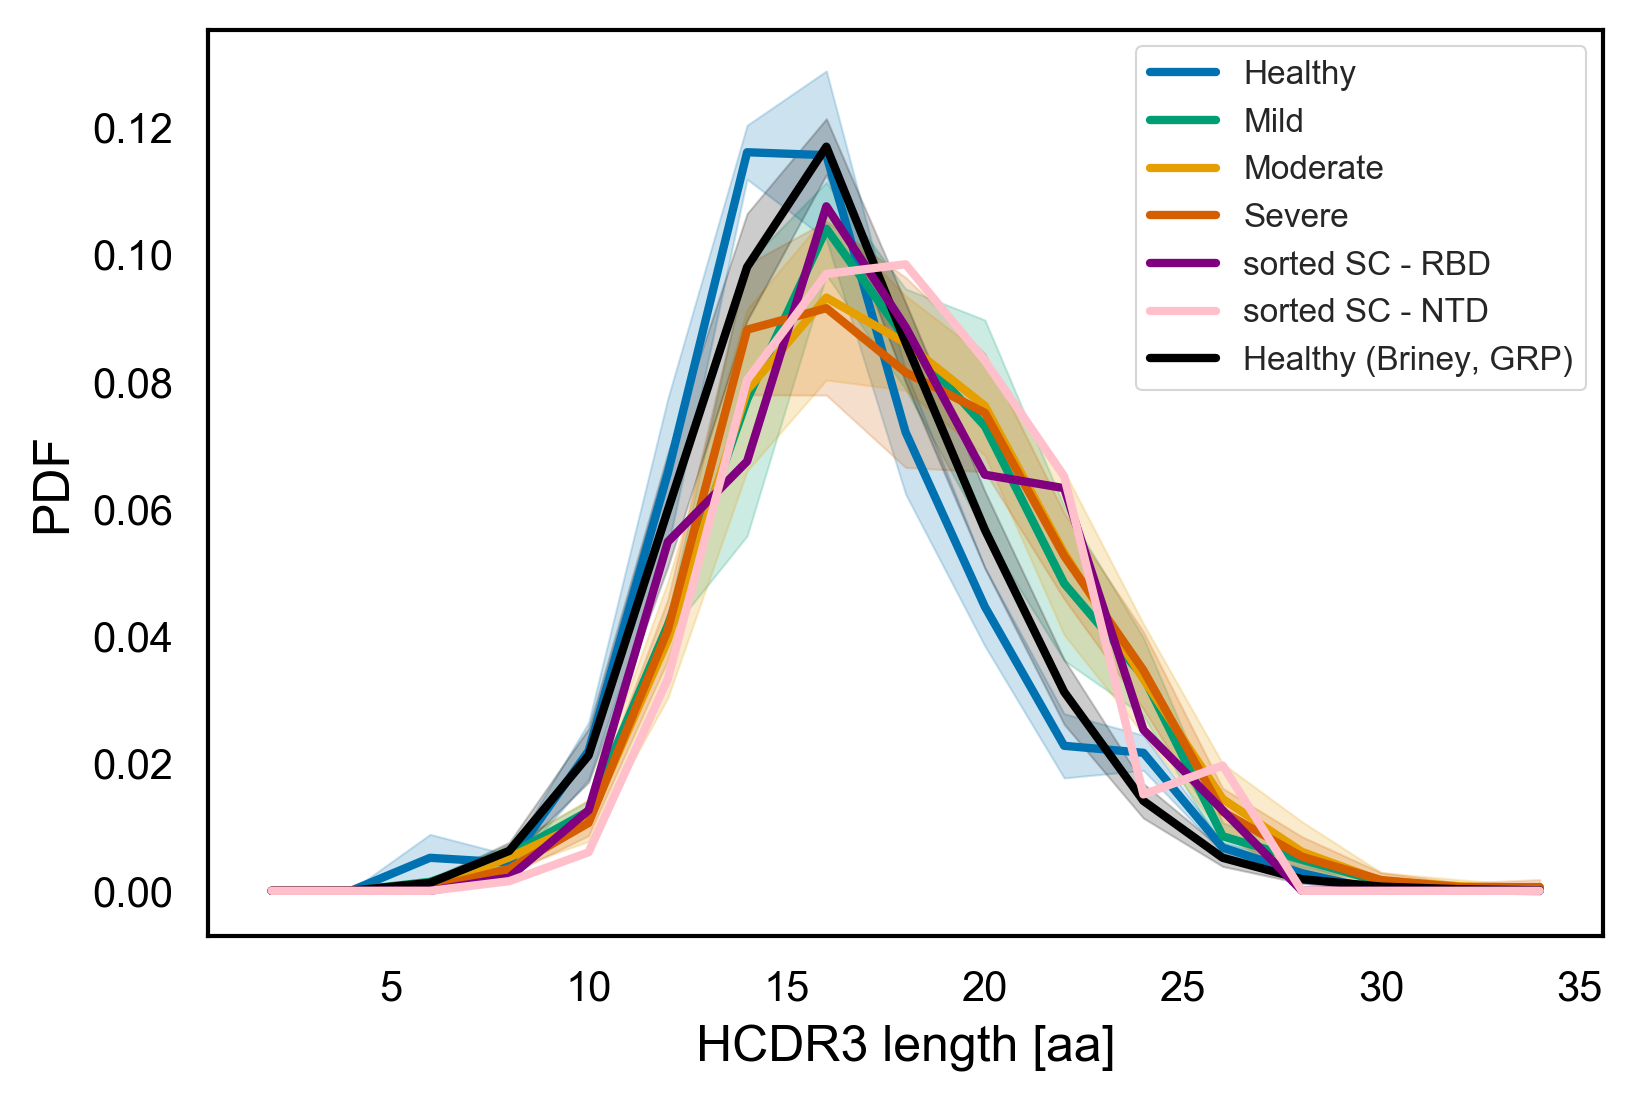

In [302]:
fig,ax = plt.subplots(dpi=300, nrows=1, ncols=1)
hist_colors = ["#0072B2","#009E73","#E69F00","#D55E00"]
briney_color = 'black'
labels = ['Healthy','Mild','Moderate','Severe']
for i, s in enumerate(bulk_productive_cdr3_for_hist.index):
    print(s)
    ax.plot(cdr3_bins[:-1],
            bulk_productive_cdr3_for_hist.loc[s][0][0],
            zorder=3,
            color=hist_colors[i],
            label=labels[i])
    ax.fill_between(cdr3_bins[:-1],
                    bulk_productive_cdr3_for_hist.loc[s][0][0] - bulk_productive_cdr3_for_hist.loc[s][0][1],
                    bulk_productive_cdr3_for_hist.loc[s][0][0] + bulk_productive_cdr3_for_hist.loc[s][0][1],
                    alpha=0.2,
                    color=hist_colors[i])


ax.plot(cdr3_bins[:-1],
        sc_cdr3_for_hist.loc['rbd'][0],
        color='purple',
        zorder=10,
        label='sorted SC - RBD')
ax.plot(cdr3_bins[:-1],
        sc_cdr3_for_hist.loc['ntd'][0],
        color='pink',
        zorder=20,
        label='sorted SC - NTD')

ax.plot(cdr3_bins[:-1],
        prod_grp_cdr3_for_hist.loc['healthy'][0][0],
        zorder=3,
        color='black',
        label='Healthy (Briney, GRP)')
ax.fill_between(cdr3_bins[:-1],
                prod_grp_cdr3_for_hist.loc['healthy'][0][0] - prod_grp_cdr3_for_hist.loc['healthy'][0][1],
                prod_grp_cdr3_for_hist.loc['healthy'][0][0] + prod_grp_cdr3_for_hist.loc['healthy'][0][1],
                alpha=0.2,
                color='black')

ax.set_xlabel('HCDR3 length [aa]')
ax.set_ylabel('PDF')
ax.legend()

In [319]:
bulk_mean = (lineages.query('bulk_unique_merged > 2')
 .groupby(['patient_recode','severity'])
 .agg({'cdr3_length_aa': np.mean})
 .reset_index())

In [320]:
bulk_mean

patient_recode  severity  cdr3_length_aa
0                1      mild       18.460388
1                2      mild       17.457998
2                3  moderate       17.715127
3                4  moderate       18.463175
4                5  moderate       17.848609
5                6  moderate       18.051327
6                7  moderate       17.350274
7                8  moderate       19.941551
8                9  moderate       18.644628
9               10  moderate       18.071038
10              11  moderate       18.721927
11              12  moderate       17.566537
12              13  moderate       18.914226
13              14  moderate       17.956657
14              15    severe       18.408593
15              16    severe       18.446934
16              17    severe       18.594650
17              18    severe       17.916900
18              19    severe       17.591295

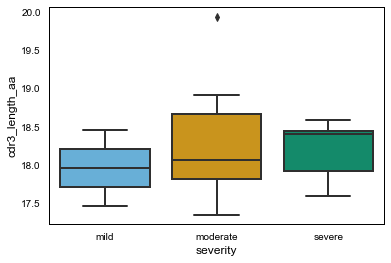

In [323]:
plt.
sns.boxplot(data=bulk_mean, x='severity', y='cdr3_length_aa')

KeyError: "None of [Index(['severity'], dtype='object')] are in the [columns]"

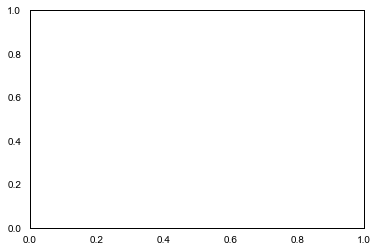

In [321]:
bulk_mean.boxplot(column='severity')

In [334]:
u_lineages = (pd.read_csv('/Users/zach/Documents/covid_analysis/unproductives.csv',
                              converters={'rbd_seqs': eval, 'ntd_seqs': eval})
                  .assign(cdr3_length_aa = lambda df: df.cdr3_length / 3)
             .rename(columns = {'progenitor_cdr3': 'cdr3'})
             .pipe(set_severity)
             .assign(abundance_sum = lambda df: df['bulk_abundance'] + df['plasma_abundance'],
                unique_sum = lambda df: df['bulk_unique_merged'] + df['plasma_unique_merged'],
                patient_recode = lambda df: df['patient'])
             .replace({'patient_recode': patient_recode})
             .groupby(['patient','primer','replicate','time'])
             .apply(add_primer_abundance)
             .reset_index(drop=True)
              .groupby(['primer','patient','patient_recode','cdr3_length_aa',
                        'v_gene','j_gene','progenitor_cdr3_nt','cluster_id'])
              .sum()
              .reset_index()
              .pipe(get_relative_abundance)
              .pipe(set_severity))
u_lineages_no_pla = u_lineages.query('(patient_recode <= 19) | (patient_recode in [81, 82, 83])').copy()
cdr3_for_hist = (u_lineages_no_pla.query('bulk_unique_merged > 2')
 .groupby('severity')
 .agg({'cdr3_length_aa': cdr3_bin})
 .reset_index()
 .groupby('severity')
 .agg({'cdr3_length_aa': average_bin}))

In [335]:
u_grp_lineages

patient  cdr3_length_aa      v_gene j_gene  \
0       316188        2.333333    IGHV1-18  IGHJ4   
1       316188        2.333333    IGHV1-18  IGHJ5   
2       316188        2.333333    IGHV1-18  IGHJ5   
3       316188        2.333333    IGHV1-18  IGHJ6   
4       316188        2.333333     IGHV1-2  IGHJ4   
...        ...             ...         ...    ...   
166699    D103       73.333333    IGHV4-39  IGHJ5   
166700    D103       79.333333    IGHV3-30  IGHJ6   
166701    D103       86.666667    IGHV3-30  IGHJ5   
166702    D103       88.333333    IGHV3-30  IGHJ5   
166703    D103       90.666667  IGHV4-38-2  IGHJ5   

                                       progenitor_cdr3_nt  cluster_id  \
0                                                 CTACTGG           1   
1                                                 CCCCTGG           1   
2                                                 CCCCTGG           2   
3                                                 CGTCTGG           1   
4                                                 CTACTGG           1   
...                                                   ...         ...   
166699  TGGGGCTGGATCCGCCAGCCCCCAGGGAAGGGGCTGGAGTGGATTG...           1   
166700  TGATGGAAGTAATAAATACTACGCAGACTCCGTGAAGGGCCGATTC...           1   
166701  TGTGCGAAAGATCCCGCGTAGTACCAGCTGCTATGGGGGGGTTCGA...           1   
166702  TGTGCGAAAGATCCCGCGTAGTACCAGCTGCTATGGGGGGGTTCGA...           1   
166703  AGTATCTATCATAGTGGGAGCACCTACTACAACCCGTCCCTCAAGA...           1   

        cdr3_length  observed_cdr3  time  replicate  ...  plasma_unique  \
0                 7            0.0     0          0  ...              0   
1                 7            0.0     0          0  ...              0   
2                 7            0.0     0          0  ...              0   
3                 7            0.0     0          0  ...              0   
4                 7            0.0     0          0  ...              0   
...             ...            ...   ...        ...  ...            ...   
166699          220            0.0     0          0  ...              0   
166700          238            0.0     0          0  ...              0   
166701          260            0.0     0          0  ...              0   
166702          265            0.0     0          0  ...              0   
166703          272            0.0     0          0  ...              0   

        plasma_unique_merged  plasma_singleton  combined_unique_merged  \
0                          0                 0                       1   
1                          0                 0                       2   
2                          0                 0                       1   
3                          0                 0                       1   
4                          0                 0                       1   
...                      ...               ...                     ...   
166699                     0                 0                       1   
166700                     0                 0                       1   
166701                     0                 0                       1   
166702                     0                 0                       1   
166703                     0                 0                       1   

        combined_singleton  rbd_unique  ntd_unique  abundance_sum  unique_sum  \
0                        1           0           0              1           1   
1                        2           0           0              2           2   
2                        1           0           0              1           1   
3                        1           0           0              1           1   
4                        1           0           0              1           1   
...                    ...         ...         ...            ...         ...   
166699                   1           0           0              1           1   
166700                   1           0           0     

In [332]:
u_lineages.query('severity=="severe"')

primer  patient  patient_recode  cdr3_length_aa    v_gene j_gene  \
0      IGHV1-F        2              19        2.666667  IGHV1-24  IGHJ3   
1      IGHV1-F        2              19        5.333333  IGHV1-24  IGHJ1   
2      IGHV1-F        2              19        5.666667  IGHV1-24  IGHJ1   
3      IGHV1-F        2              19        6.666667  IGHV1-18  IGHJ3   
4      IGHV1-F        2              19        7.666667  IGHV1-18  IGHJ1   
...        ...      ...             ...             ...       ...    ...   
25864  IGHV6-F       42              18       26.333333   IGHV6-1  IGHJ4   
25865  IGHV6-F       42              18       26.666667   IGHV6-1  IGHJ6   
25866  IGHV6-F       42              18       35.333333   IGHV6-1  IGHJ1   
25867  IGHV6-F       42              18       39.666667   IGHV6-1  IGHJ6   
25868  IGHV6-F       42              18       60.333333   IGHV6-1  IGHJ5   

                                      progenitor_cdr3_nt  cluster_id  \
0                                               ATATCTGG           1   
1                                       TGTGCAACAGACTCAA           1   
2                                      CGTTTGGGGGCACAGCG           1   
3                                   GTTCGGCTTTTGATATCTGG           1   
4                                TGATTACGTTTGGGGGCACAGCG           1   
...                                                  ...         ...   
25864  TGTGCAAGAGGTAGAGGGATCCCGTACTATGGTTCGGGGAGTTATT...           1   
25865  TGTGCAAGAGCATAACTGGGTCGGTGGCTCCGATTCGTAATTCCAG...           1   
25866  TGTGCAAGAGGGATCCACATCGTATAGCAGTGGCTGGTATCGCTGA...           1   
25867  TGTGCAAGAGTTCCGTCCCGAACCACAGTGTAGTGGCTACCCATAA...           1   
25868  TGTGCAAGAGACAGTGGCTGGTACTATTTTGACTTCTGGGGCCAGG...           1   

       cdr3_length  observed_cdr3  ...  ntd_unique  abundance_sum  unique_sum  \
0               56            0.0  ...           0              6           3   
1              112            0.0  ...           0              8           1   
2              119            0.0  ...           0              4           4   
3              140            0.0  ...           0             11           4   
4              161            0.0  ...           0             80           8   
...            ...            ...  ...         ...            ...         ...   
25864          395            0.0  ...           0              1           1   
25865          400            0.0  ...           0              1           1   
25866          530            0.0  ...           0              2           1   
25867          595            0.0  ...           0              1           1   
25868          905            0.0  ...           0              1           1   

       a_primersum  p_primersum  primersum  norm_abun  norm_plas_abun  \
0              239           15        254   0.025105             0.0   
1              239           15        254   0.033473             0.0   
2              239           15        254   0.016736             0.0   
3              239           15        254   0.046025             0.0   
4              239           15        254   0.297071             0.6   
...            ...          ...        ...        ...             ...   
25864         1208            0       1208   0.000828             NaN   
25865         1208            0       1208   0.000828             NaN   
25866         1208            0       1208   0.001656             NaN   
25867         1208            0       1208   0.000828             NaN   
25868         1208            0       1208   0.000828             NaN   

       norm_sum_abun  severity  
0           0.023622    severe  
1           0.031496    severe  
2           0.015748    severe  
3           0.043307    severe  
4           0.314961    severe  
...              ...       ...  
25864       0.000828    severe  
25865       0.000828    severe  
25866       0.001656    severe  
25867       0.000828    severe  
25868       0.000

In [348]:
pd.unique(u_grp_lineages.patient)

array([316188, 326650, 326651, 326713, 326737, 326780, 326797, 326907,
       327059, '327059', 'D103'], dtype=object)

In [354]:
u_grp_lineages[u_grp_lineages.patient == p]

patient  cdr3_length_aa    v_gene j_gene  \
0     316188        2.333333  IGHV1-18  IGHJ4   
1     316188        2.333333  IGHV1-18  IGHJ5   
2     316188        2.333333  IGHV1-18  IGHJ5   
3     316188        2.333333  IGHV1-18  IGHJ6   
4     316188        2.333333   IGHV1-2  IGHJ4   
...      ...             ...       ...    ...   
2944  316188       72.666667  IGHV4-39  IGHJ2   
2945  316188       78.333333  IGHV4-39  IGHJ2   
2946  316188       85.333333  IGHV3-20  IGHJ4   
2947  316188       96.666667  IGHV4-39  IGHJ2   
2948  316188      100.666667  IGHV3-74  IGHJ1   

                                     progenitor_cdr3_nt  cluster_id  \
0                                               CTACTGG           1   
1                                               CCCCTGG           1   
2                                               CCCCTGG           2   
3                                               CGTCTGG           1   
4                                               CTACTGG           1   
...                                                 ...         ...   
2944  ATTGGGAGTATCTATTATAGTGGGAGCACCTACTACAACCCGTCCC...           1   
2945  ATTGGGAGTATCTATTATAGTGGGAGCACCTACTACAACCCGTCCC...           1   
2946  TTGGAATGGTGGTAGCACAGGTTATGCAGACTCTGTGAAGGGCCGA...           1   
2947  ATTGGGAGTATCTATTATAGTGGGAGCACCTACTACAACCCGTCCC...           1   
2948  TGTGCAAGAGCCCCGTCCGAAGTTGGTGGTTATTACCCTGAATACT...           1   

      cdr3_length  observed_cdr3  time  replicate  ...  plasma_unique  \
0               7            0.0     0          0  ...              0   
1               7            0.0     0          0  ...              0   
2               7            0.0     0          0  ...              0   
3               7            0.0     0          0  ...              0   
4               7            0.0     0          0  ...              0   
...           ...            ...   ...        ...  ...            ...   
2944          218            0.0     0          0  ...              0   
2945          235            0.0     0          0  ...              0   
2946          256            0.0     0          0  ...              0   
2947          290            0.0     0          0  ...              0   
2948          302            0.0     0          0  ...              0   

      plasma_unique_merged  plasma_singleton  combined_unique_merged  \
0                        0                 0                       1   
1                        0                 0                       2   
2                        0                 0                       1   
3                        0                 0                       1   
4                        0                 0                       1   
...                    ...               ...                     ...   
2944                     0                 0                       1   
2945                     0                 0                       1   
2946                     0                 0                       1   
2947                     0                 0                       1   
2948                     0                 0                       1   

      combined_singleton  rbd_unique  ntd_unique  abundance_sum  unique_sum  \
0                      1           0           0              1           1   
1                      2           0           0              2           2   
2                      1           0           0              1           1   
3                      1           0           0              1           1   
4                      1           0           0              1           1   
...                  ...         ...         ...            ...         ...   
2944                   1           0           0              1           1   
2945                   1           0           0              1           1   
2946                   1           0           0              1           1   
2947                   1       

316188
326650
326737
326780
326907
327059
327059
D103


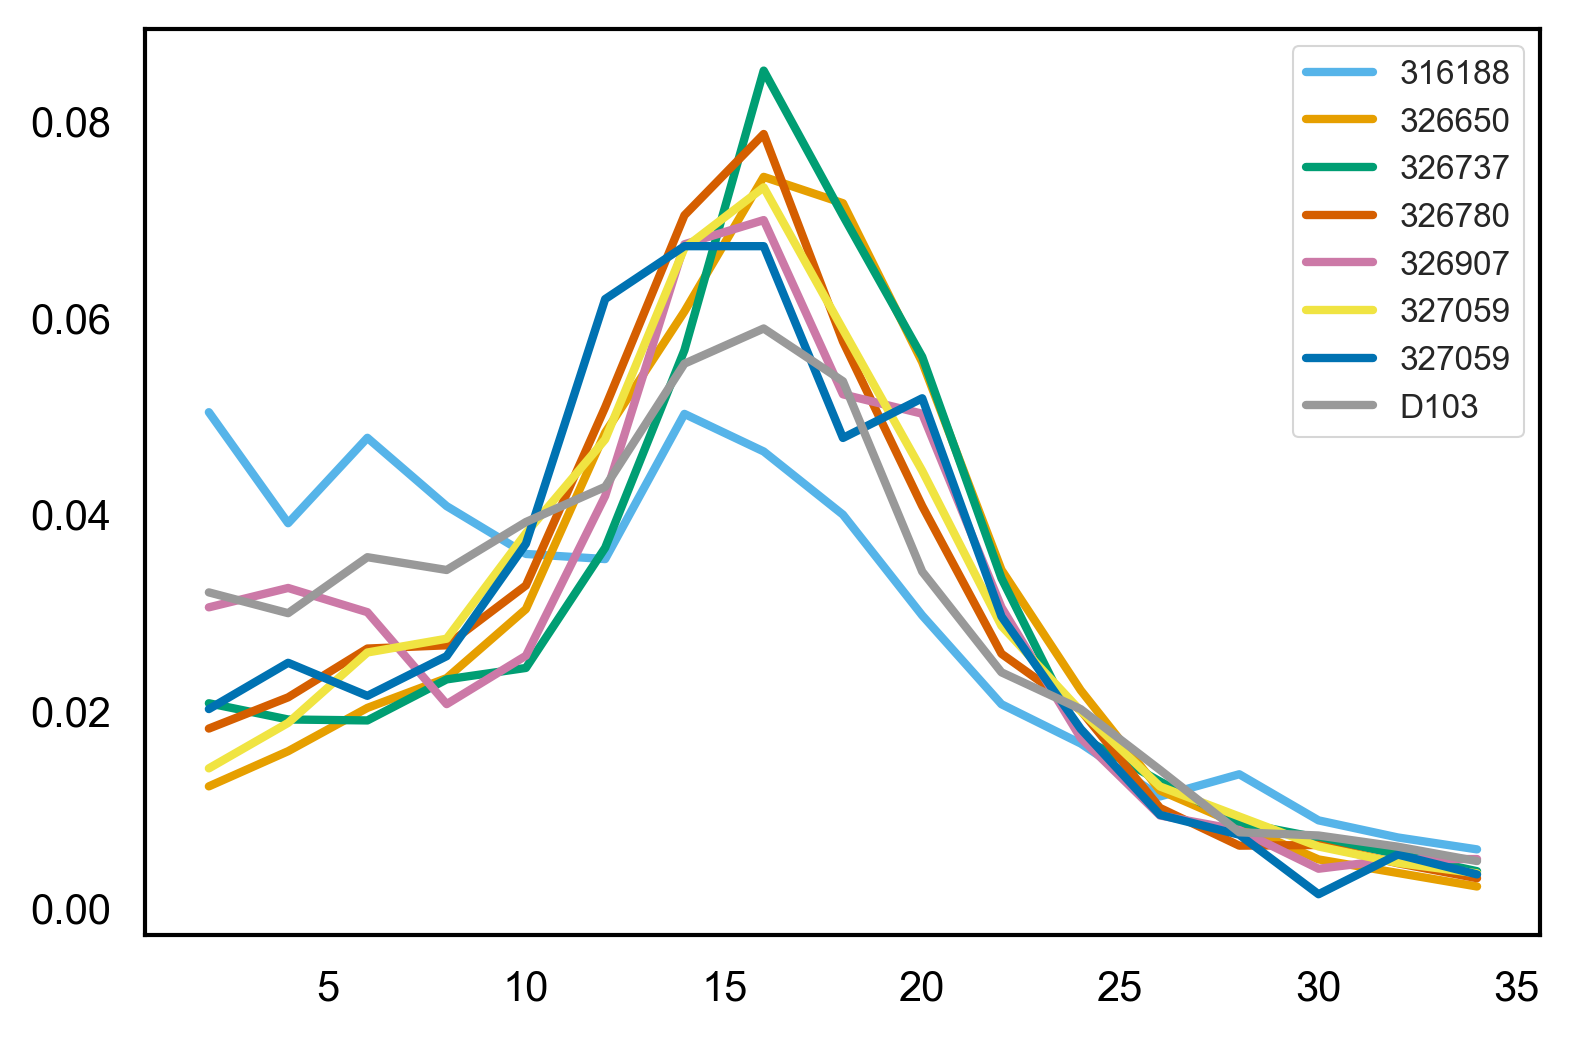

In [361]:
fig=plt.figure(dpi=300)
for p in u_grp_lineages.patient.unique():
    if p in [326797, 326713, 326651]:
        continue
    print(p)
    f,b = np.histogram(u_grp_lineages[u_grp_lineages.patient == p].cdr3_length_aa,
                       cdr3_bins, density=True)
    plt.plot(b[:-1],f,label=p)
plt.legend()

In [346]:
sns.distplot(u_grp_lineages, name='cdr3_length_aa')

TypeError: distplot() got an unexpected keyword argument 'name'

(array([0.        , 0.00985708, 0.01228958, 0.01872784, 0.0238258 ,
        0.03373129, 0.04962423, 0.07197057, 0.07982476, 0.06835207,
        0.04932168, 0.03206424, 0.02034648, 0.01155741, 0.00715833,
        0.00443236, 0.00311929, 0.00213903, 0.00165797]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 38.]),
 <a list of 19 Patch objects>)

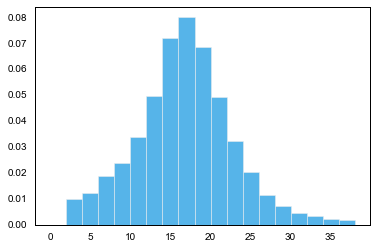

In [343]:
plt.hist(u_grp_lineages.cdr3_length_aa, bins=19, range=(0,38),density=True)

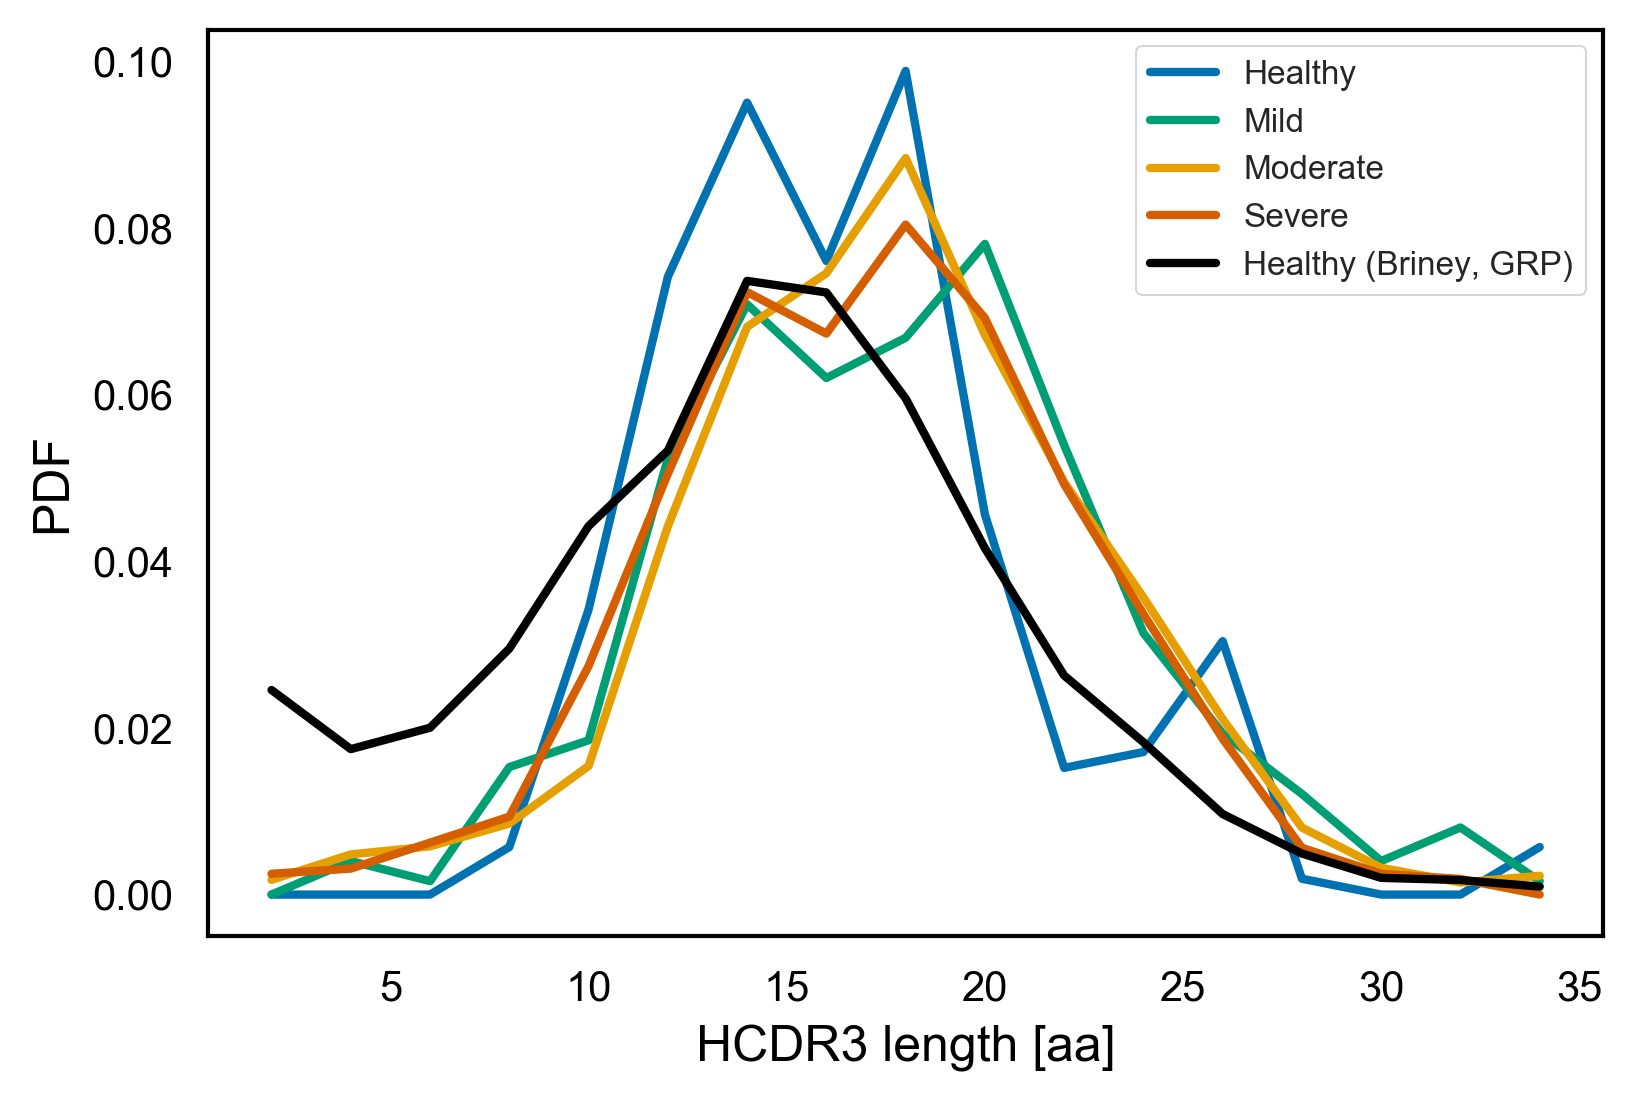

In [339]:
fig,ax = plt.subplots(dpi=300, nrows=1,ncols=1)
#axes.plot(cdr3_bins[:-1], grp_cdr3_for_hist.loc[0][0])
hist_colors = ["#0072B2","#009E73","#E69F00","#D55E00"]
briney_color = 'black'
labels = ['Healthy','Mild','Moderate','Severe']
for i, s in enumerate(cdr3_for_hist.index):
    ax.plot(cdr3_bins[:-1],cdr3_for_hist.loc[s][0][0],zorder=3,color=hist_colors[i],label=labels[i])
    ax.fill_between(cdr3_bins[:-1], cdr3_for_hist.loc[s][0][0] - cdr3_for_hist.loc[s][0][1],
                   cdr3_for_hist.loc[s][0][0] + cdr3_for_hist.loc[s][0][1],alpha=0.2,
                    color=hist_colors[i])
ax.plot(cdr3_bins[:-1],
        u_grp_cdr3_for_hist.loc['healthy'][0][0],
        zorder=3,color=briney_color,label='Healthy (Briney, GRP)')
ax.fill_between(cdr3_bins[:-1],
                u_grp_cdr3_for_hist.loc['healthy'][0][0] - u_grp_cdr3_for_hist.loc['healthy'][0][1],
                u_grp_cdr3_for_hist.loc['healthy'][0][0] + u_grp_cdr3_for_hist.loc['healthy'][0][1],alpha=0.2,
                color=briney_color)
ax.plot()
ax.set_xlabel('HCDR3 length [aa]')
ax.set_ylabel('PDF')
ax.legend()

In [366]:
cdr3_for_hist = (u_lineages.query('combined_unique_merged > 2').query('severity != "asymptomatic"')
 .groupby(['severity'])
 .agg({'cdr3_length_aa': cdr3_bin})
 .reset_index()
 .groupby('severity')
 .agg({'cdr3_length_aa': average_bin}))

In [367]:
cdr3_for_hist

cdr3_length_aa
severity                                                   
healthy   ([0.0, 0.0, 0.0, 0.005084745762711864, 0.03389...
mild      ([0.0, 0.0047814207650273225, 0.00273224043715...
moderate  ([0.0016816143497757848, 0.004344170403587444,...
severe    ([0.002369668246445498, 0.002962085308056872, ...

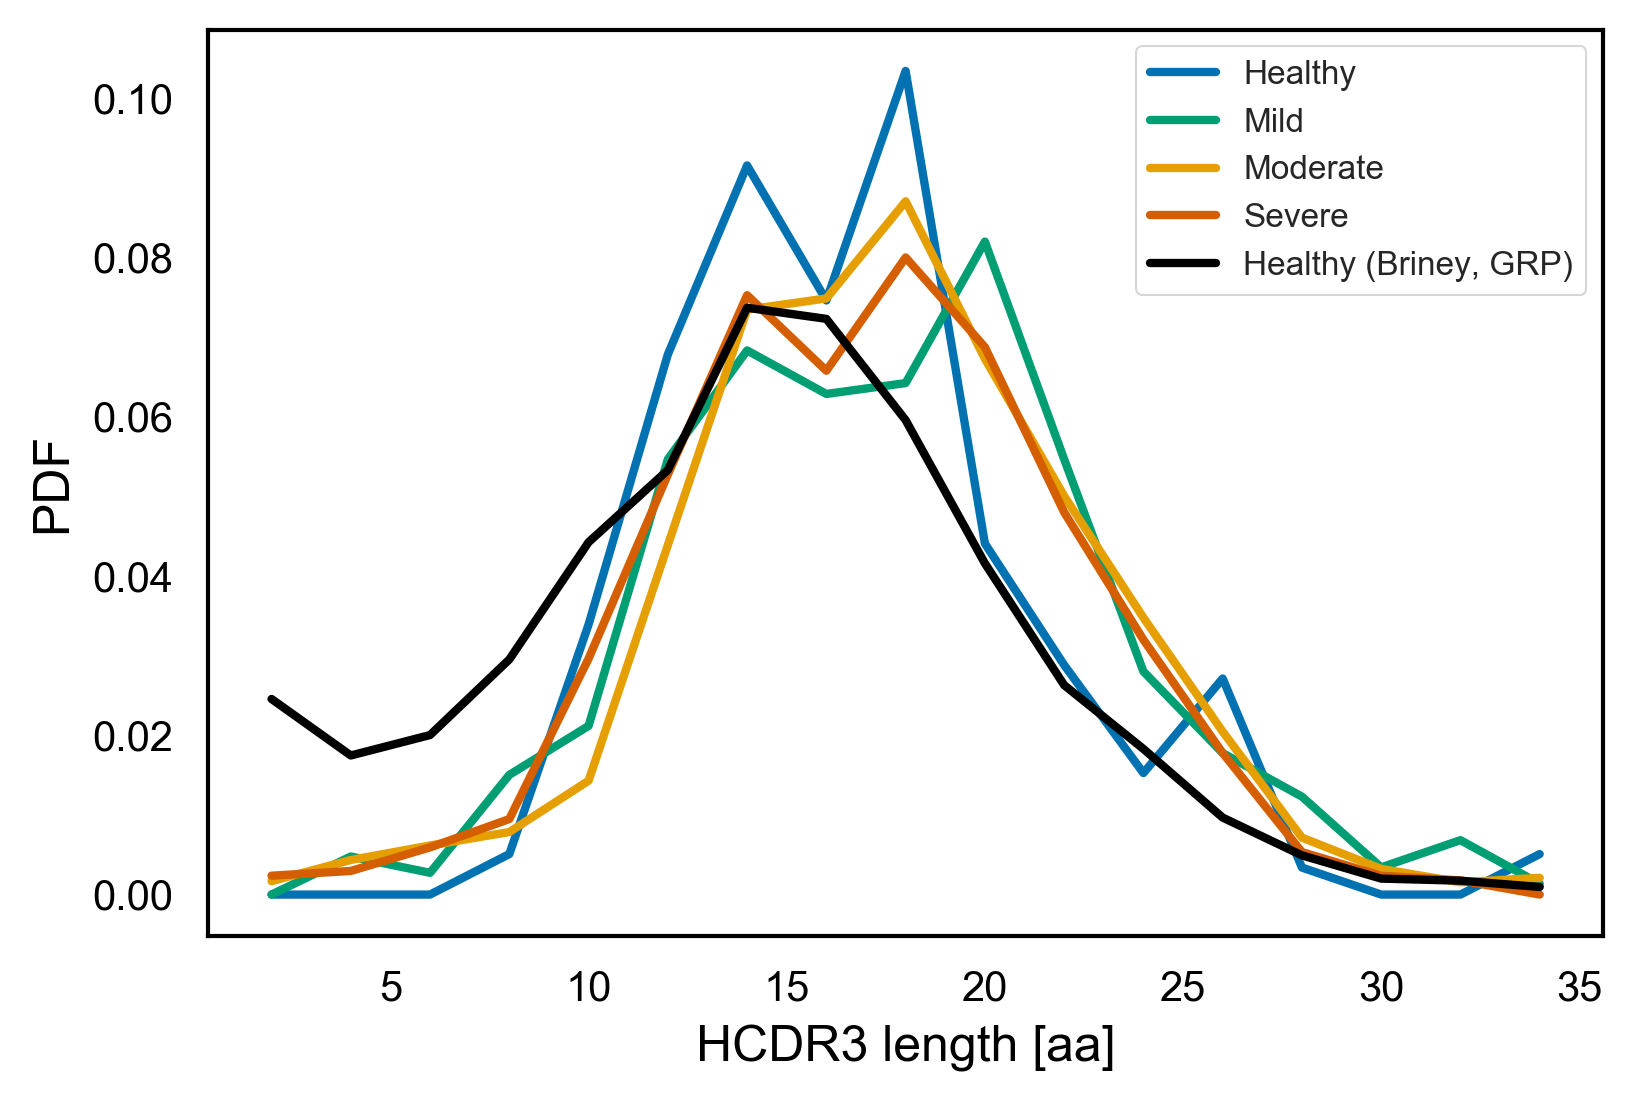

In [368]:
fig,ax = plt.subplots(dpi=300, nrows=1,ncols=1)
#axes.plot(cdr3_bins[:-1], grp_cdr3_for_hist.loc[0][0])
hist_colors = ["#0072B2","#009E73","#E69F00","#D55E00"]
briney_color = 'black'
labels = ['Healthy','Mild','Moderate','Severe']
for i, s in enumerate(cdr3_for_hist.index):
    ax.plot(cdr3_bins[:-1],cdr3_for_hist.loc[s][0][0],zorder=3,color=hist_colors[i],label=labels[i])
    ax.fill_between(cdr3_bins[:-1], cdr3_for_hist.loc[s][0][0] - cdr3_for_hist.loc[s][0][1],
                   cdr3_for_hist.loc[s][0][0] + cdr3_for_hist.loc[s][0][1],alpha=0.2,
                    color=hist_colors[i])
ax.plot(cdr3_bins[:-1],u_grp_cdr3_for_hist.loc['healthy'][0][0],zorder=3,color=briney_color,label='Healthy (Briney, GRP)')
ax.fill_between(cdr3_bins[:-1], u_grp_cdr3_for_hist.loc['healthy'][0][0] - u_grp_cdr3_for_hist.loc['healthy'][0][1],
                u_grp_cdr3_for_hist.loc['healthy'][0][0] + u_grp_cdr3_for_hist.loc['healthy'][0][1],alpha=0.2,
                color=briney_color)
ax.plot()
ax.set_xlabel('HCDR3 length [aa]')
ax.set_ylabel('PDF')
ax.legend()

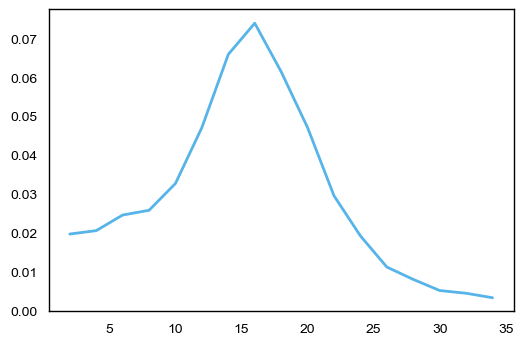

In [113]:
fig,axes = plt.subplots(dpi=100, nrows=1,ncols=1)
axes.plot(cdr3_bins[:-1], grp_cdr3_for_hist.loc[0][0])

In [103]:
grp_cdr3_for_hist

cdr3_length
0  [0.0, 0.0, 0.016050462813454406, 0.02169028775...
1  [0.0, 0.0, 0.006819816620630742, 0.00946718049...

# Clonal expansion

In [23]:
def run_fisher(in_data, reads='abundance_sum', cutoff_size=2):
    pvjcc = ['patient','v_gene','j_gene','cdr3', 'cluster_id','primer']
    #num_lins = in_data.groupby(['patient','primer']).apply(get_num_lins_in_primer)
    
    if reads == 'abundance_sum':
        unique_col = 'combined_unique_merged'
    elif reads == 'bulk_abundance':
        unique_col = 'bulk_unique_merged'
    elif reads == 'plasma_abundance':
        unique_col = 'plasma_unique_merged'
    
    df = (in_data
          .set_index(pvjcc)
          .loc[in_data.groupby(pvjcc).sum().query(unique_col + '>' + str(cutoff_size)).index]
          .query('patient in [6, 9, 11, 15, 21, 22, 117, 166, 187, 212, 271]')
          .query(reads + ' > 0')
          .reset_index())
    
    #  Specify times to split
    timesplit = df.groupby('patient')['time'].apply(np.min).to_frame('timesplit')
    timesplit.loc[117] = df.groupby('patient')['time'].apply(np.max).loc[117]
    df['timesplit'] = timesplit.loc[df['patient']].reset_index()['timesplit']
    df['time2'] = ''
    df.loc[df.patient != 117, 'time2'] = (df[df['patient'] != 117]['time']
                                         == df[df['patient'] != 117]['timesplit'])
    df.loc[df.patient == 117, 'time2'] = (df[df['patient'] == 117]['time']
                                         != df[df['patient'] == 117]['timesplit'])
    
    if reads == 'abundance_sum':
        primer_col = 'primersum'
    elif reads == 'bulk_abundance':
        primer_col = 'a_primersum'
    elif reads == 'plasma_abundance':
        primer_col = 'p_primersum'

    df = (df.drop('timesplit',axis=1)
          .groupby(['patient','v_gene','j_gene','cdr3','cluster_id','time2','primer'])
          .sum()
          .rename(columns = {reads: 'exp_abundance', primer_col: 'exp_primersum'}))

    df = (df
          .reset_index()
          .set_index(pvjcc)
          .loc[df.reset_index().groupby(pvjcc).count().query('exp_abundance > 1').index])
    
    early = df.query('time2==True').sort_values(pvjcc)
    later = df.query('time2==False').sort_values(pvjcc)
    df = df.groupby(pvjcc).sum()
    
    alpha = 0
    df = df.assign(early_a = early['exp_abundance'] + alpha,
                   late_a = later['exp_abundance']+alpha,
                   early_p = early['exp_primersum'] + alpha,
                   late_p = later['exp_primersum'] + alpha)
    df = df.assign(early_diff = df['early_p'] - df['early_a'],
                   late_diff = df['late_p'] - df['late_a'])
    df = df.assign(test = pvalue_npy(df['late_a'].to_numpy(np.uint),
                                     df['late_diff'].to_numpy(np.uint),
                                     df['early_a'].to_numpy(np.uint),
                                     df['early_diff'].to_numpy(np.uint))[1],
                   s = np.log10((df['late_a'] * df['early_diff'])
                              / (df['early_a'] * df['late_diff'])),
                   s2 = np.log2((df['late_a'] * df['early_diff'])
                              / (df['early_a'] * df['late_diff'])),
                   n = df['early_a'] + df['late_a'])

    df['test'].replace([0], 1e-323, inplace=True)
    df['logtest'] = np.log10(df['test'])
    
    return df.reset_index().rename(columns={'exp_abundance': reads})

In [24]:
df_fisher = run_fisher(data, 'bulk_abundance')

## Determine FDR using R since the two-sided test has low precision and gives incorrect results

In [25]:
expansion_pvalue = -300

## Label expanded lineages

In [26]:
lineages = lineages
lineages['expanded'] = False
expanded_lins = (df_fisher
 .loc[df_fisher.logtest < expansion_pvalue]
 .set_index(['patient','v_gene','j_gene','cluster_id','cdr3'])
 .index)
lineages = (lineages.set_index(['patient','v_gene','j_gene','cluster_id','cdr3']))
lineages.loc[expanded_lins,'expanded'] = True
lineages = lineages.reset_index()

# Plasma coverage analysis

In [27]:
df_coverage = (lineages.query('(plasma_abundance > 0) &(combined_unique_merged > 2)')
               .assign(bulk_diff = lambda df: df['a_primersum'] - df['bulk_abundance'],
                       plasma_diff = lambda df: df['p_primersum']  - df['plasma_abundance'],
                       test = lambda df: pvalue_npy(df['plasma_abundance'].to_numpy(np.uint),
                                                 df['plasma_diff'].to_numpy(np.uint),
                                                 df['bulk_abundance'].to_numpy(np.uint),
                                                 df['bulk_diff'].to_numpy(np.uint))[1]+1e-323,
                       s = lambda df: np.log10((df['plasma_abundance'] * df['bulk_diff'])
                                               / (df['bulk_abundance'] * df['plasma_diff'])),
                       logtest = lambda df: np.log10(df['test']))) 

## Label plasma-overrepresented lineages

In [28]:
#  Determined by FDR analysis on R
coverage_pvalue = -239

In [29]:
overrepped_plasma = (df_coverage
                     .loc[df_coverage.logtest < coverage_pvalue]
                     .index)
lineages['overrep_plasma'] = False
lineages = lineages
lineages.loc[overrepped_plasma, 'overrep_plasma'] = True

# BCR sharing

In [30]:
def healthy_sharing_input(in_lins, bulk_only = False, v_threshold = 0.1):
    lins_for_sharing = in_lins.reset_index().copy()
    
    if bulk_only:
        lins_for_sharing = (lins_for_sharing.query('bulk_abundance > 0')
                            .sort_values('combined_unique_merged', ascending=False)
                            .rename(columns={'combined_unique_merged':'lineage_size'}))
    else:
        lins_for_sharing = (lins_for_sharing
                            .sort_values('combined_unique_merged', ascending=False)
                            .rename(columns={'combined_unique_merged':'lineage_size'}))
    def get_ppost(grp):
        if np.max(grp['lineage_size']) > 2:
            return np.mean(grp['ppost'])
        else:
            return 10
        
    df_share = (lins_for_sharing
           .drop_duplicates(['patient','v_gene','j_gene','cdr3'])
           .groupby(['cdr3','v_gene','j_gene'])
           .apply(get_ppost)
           .to_frame()
           .rename(columns={0:'ppost'})
           .query('(ppost < 1) & (ppost > -40)')
           .copy())
    df_counts = (lins_for_sharing
               .drop_duplicates(['patient','v_gene','j_gene','cdr3'])
               .groupby(['cdr3','v_gene','j_gene'])
               .count())
    df_share['share'] = df_counts.loc[df_share.index]['patient']
    
    return df_share
    

In [31]:
df_healthy_sharing = healthy_sharing_input(healthy_lineages, bulk_only = False)

In [32]:
#ppost = 1e-27.1 for 2%
healthy_bounds = [-33.2761, -19.4875, -14.7323]
percent_below_share = 0
df_healthy_sharing['below_share'] = False
for i,b in enumerate(healthy_bounds):
    percent_below_share += (i+1)*(df_healthy_sharing.loc[df_healthy_sharing.share == (i+1)]['ppost'] < b).sum()
    df_healthy_sharing.loc[(df_healthy_sharing.share == (i+1))
                           & (df_healthy_sharing.ppost < b), 'below_share'] = True
percent_below_share /= df_healthy_sharing.share.sum()
print(percent_below_share*100)

2.065167508031207


In [33]:
def make_sharing_plot_healthy(in_df, ax, in_bounds, sharetype='share'):
    share_z = 20
    axisline_z = 1
    
    #  Create colorbar. Create norm here so scaled counts
    #  shows up properly in the scatterplot
    cbaxes = inset_axes(ax, width="5%",
                        height="30%",
                        loc='center',
                        bbox_transform=ax.transAxes,
                        bbox_to_anchor=(0.25, -0.1, 1, 1))
    norm = Normalize(vmin = np.min(0), vmax = np.max(1))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=steelblue2),
                        cax=cbaxes,
                        ticks=[0.25, 0.5, 0.75, 1.0])
    cbar.ax.set_xlabel('scaled count',fontsize=14)

    binning_= np.linspace(-40,0,81)
    for p in range(1,in_df[sharetype].max()+1):
        ax.axvline(p,linewidth=1,color='grey',zorder=axisline_z,alpha=0.3)
        
        pat_condition = (in_df[sharetype]==p)
        
        ppost = in_df['ppost'][pat_condition]
        if ppost.shape[0] == 0:
            continue
        freq,bins=np.histogram(ppost,binning_,density=True)
        freqno0 = freq[freq != 0]
        freqno0 /= np.max(freqno0)
        ppost = bins[:-1][freq != 0]
        idx = freqno0.argsort()
        y, z = ppost[idx], freqno0[idx]

        sc1=ax.scatter([p for i in freqno0],y,c=z,
                       cmap=steelblue2,norm=norm,zorder=share_z,s=50)
    return ax

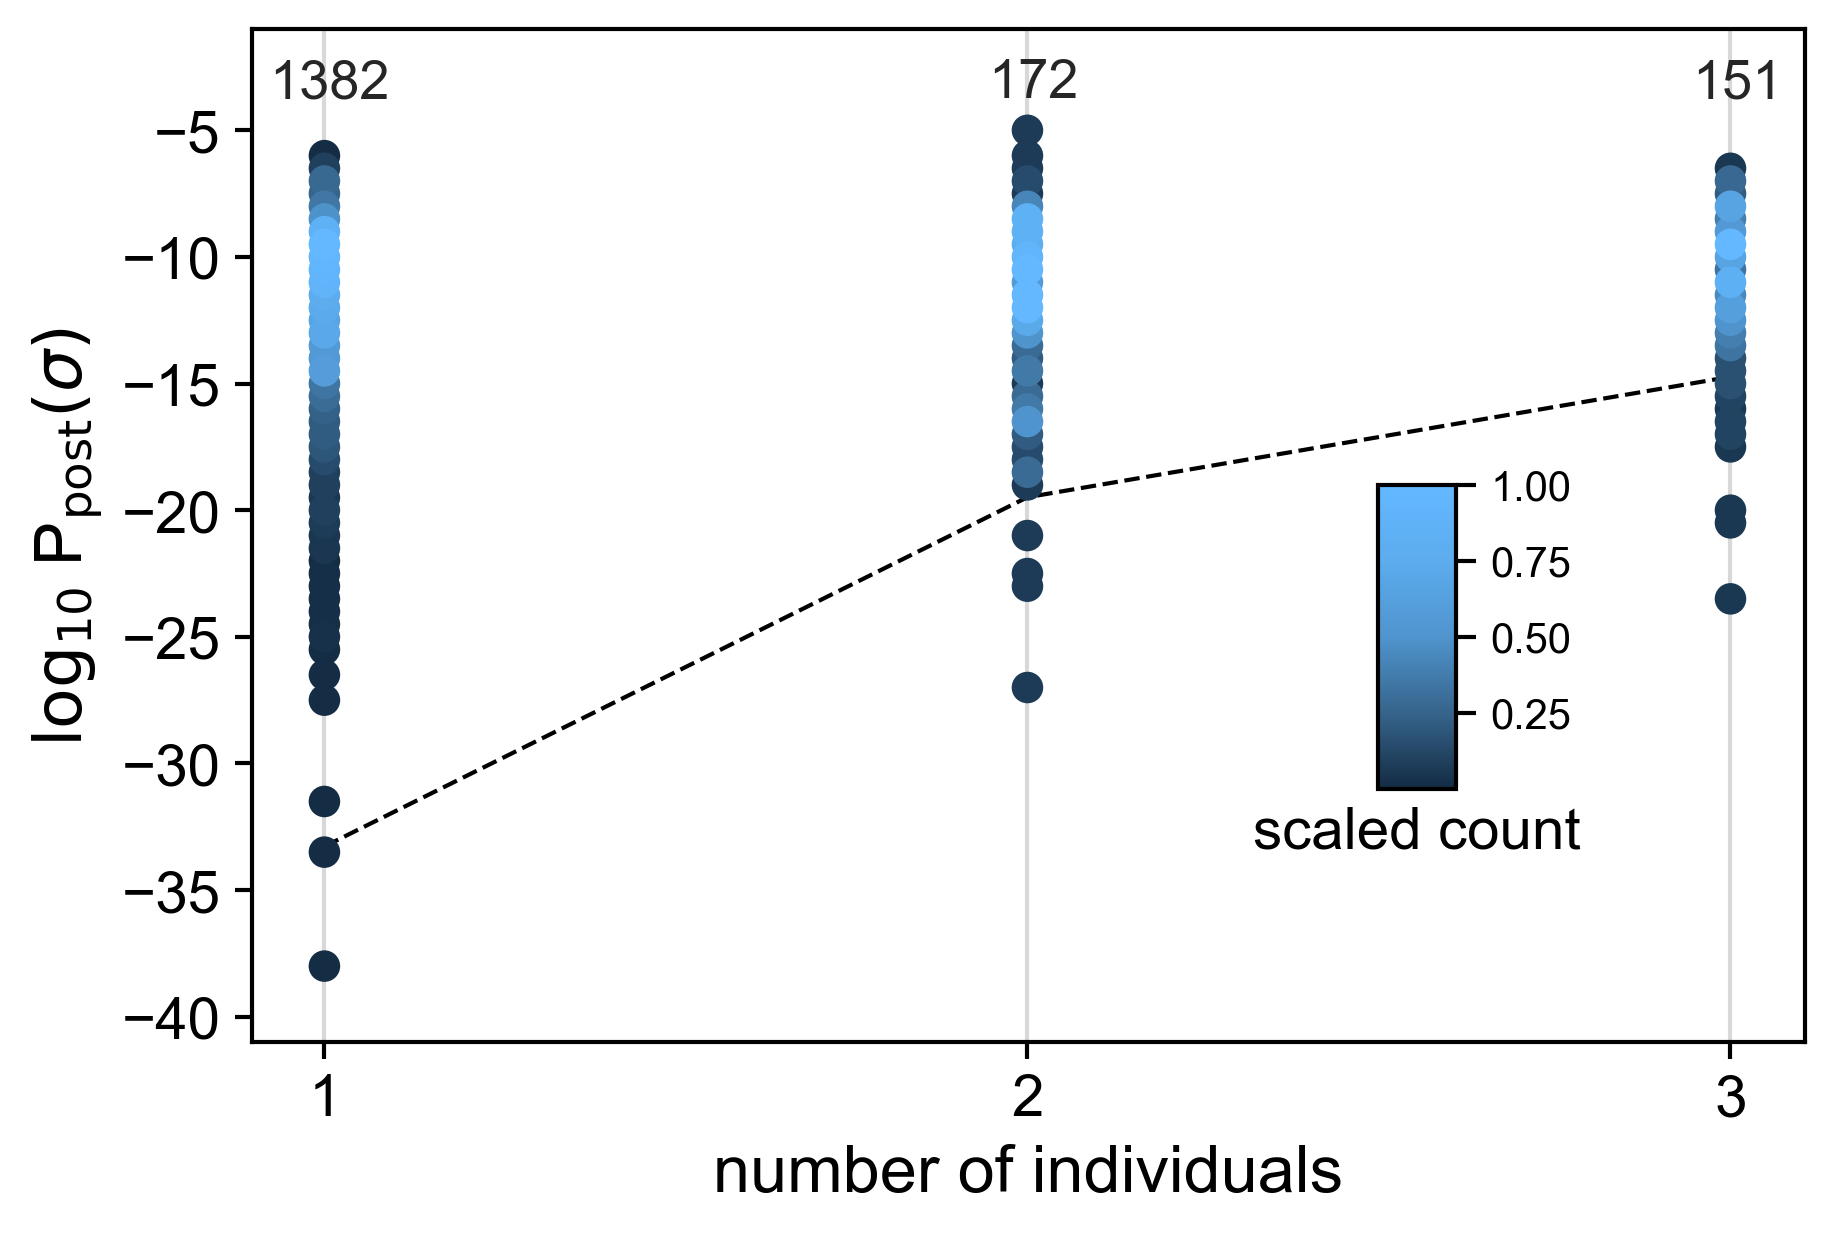

In [35]:
fig = plt.figure(dpi=global_dpi, constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=1, wspace=0.025, hspace=0.05)
ax1 = fig.add_subplot(gs[0, 0])

make_sharing_plot_healthy(df_healthy_sharing, ax1, healthy_bounds)
ax1.set_xlabel("number of individuals", fontsize=16)
ax1.set_ylabel('$\log_{10}$ P$_{\mathrm{post}}(\sigma)$', fontsize=16)
ax1.set_xticks(np.arange(0,df_healthy_sharing.share.max()+1,1));
ax1.set_ylim(-41,-1)
ax1.plot(np.arange(1,len(healthy_bounds)+1),healthy_bounds,
        '--',color='black', linewidth=1)
ax1.tick_params(axis='y', which='major', direction='out',length=4,
                  bottom=False, top=False, left=True, right=False,
                  labelsize=14, color='black')
ax1.tick_params(axis='x', which='major', direction='out',length=4,
                  bottom=True, top=False, left=False, right=False,
                  labelsize=14, color='black')

for idx, c in enumerate(np.bincount(df_healthy_sharing['share'])):
    if idx == 0:
        continue
    ax1.text(idx-np.log10(c)/40, -3.7, c,fontsize=13)
    
fig.savefig('/Users/zach/new_covid_figures/FigS11_new.pdf',
            bbox_inches='tight')
fig.savefig('/Users/zach/new_covid_figures/FigS11_new.png',
            bbox_inches='tight')

In [36]:
def sharing_input(in_lins, bulk_only = False, v_threshold = 0.1):
    lins_for_sharing = in_lins.copy().reset_index()
    
    if bulk_only:
        lins_for_sharing = (lins_for_sharing.query('bulk_abundance > 0')
                            .sort_values('combined_unique_merged', ascending=False)
                            .rename(columns={'combined_unique_merged':'lineage_size'}))
    else:
        lins_for_sharing = (lins_for_sharing
                            .sort_values('combined_unique_merged', ascending=False)
                            .rename(columns={'combined_unique_merged':'lineage_size'}))
    
    def get_ppost(grp):
        if np.max(grp['lineage_size']) > 2:
            return np.mean(grp.loc[grp.severity!='asymptomatic']['ppost'])
        else:
            return 10
        
    df_share = (lins_for_sharing
                .drop_duplicates(['patient','v_gene','j_gene','cdr3'])
                .groupby(['cdr3','v_gene','j_gene'])
                .apply(get_ppost)
                .to_frame()
                .rename(columns={0:'ppost'})
                .query('(ppost < 1) & (ppost > -40)')
                .copy())
    df_counts = (lins_for_sharing
                 .drop_duplicates(['patient','v_gene','j_gene','cdr3'])
                 .groupby(['cdr3','v_gene','j_gene'])
                 .count())
    df_share['share'] = df_counts.loc[df_share.index]['patient']

    grouped = (lins_for_sharing.groupby(['cdr3','v_gene','j_gene']).sum())
    df_share['has_plasma'] = (grouped
                              .pipe(lambda x: x.plasma_abundance > 0)
                              .rename('has_plasma')
                              .reset_index()
                              .set_index(['cdr3','v_gene','j_gene'])
                              .loc[df_share.index]['has_plasma'])

    
    for col in ['expanded', 'rbd_unique', 'ntd_unique', 'overrep_plasma']:
         df_share[col] = (grouped.loc[df_share.index][col])
            
    df_share['rbd_seqs_str'] = ''
    df_share['ntd_seqs_str'] = ''

    rbd_subset = df_share.query('rbd_unique > 0').index
    ntd_subset = df_share.query('ntd_unique > 0').index
    lin_singlecell_subset = (lins_for_sharing
                             .sort_values(['rbd_unique','ntd_unique'],ascending=[False,False])
                             .drop_duplicates(['cdr3','v_gene','j_gene'])
                             .set_index(['cdr3','v_gene','j_gene']))
    df_share.loc[rbd_subset, 'rbd_seqs_str'] = lin_singlecell_subset.loc[rbd_subset]['rbd_seqs_str']
    df_share.loc[ntd_subset, 'ntd_seqs_str'] = lin_singlecell_subset.loc[ntd_subset]['ntd_seqs_str']
    
    
    
            
    df_share = df_share.reset_index()
    df_share['mab_ab_dist'] = np.inf
    df_share['short_cdr3'] = df_share.cdr3.str[1:-1]
    df_share['mab_ab_matches'] = ''
    df_share['mab_ab_type'] = ''

    known_ab_subset = (df_share.cdr3.str[0]=='C') & (df_share.cdr3.str[-1]=='W')
    to_set = []
    matches = []
    antigen_types = []
    source_types = []
    for rowidx, row in enumerate(df_share[known_ab_subset].itertuples()):
        hams = []
        v_genes_to_check = np_v_ref_genes[np.where(v_ham_mat[v_ref_genes.index(row.v_gene),] <= v_threshold)].tolist()
        subset_condition = ((mab_abs['v_gene'].isin(v_genes_to_check))
                            & (mab_abs['cdr3'].str.len() == len(row.short_cdr3)))
        indices = mab_abs[subset_condition].index
        for ab_cdr3 in mab_abs[subset_condition]['cdr3']:
            hams.append(hamming_distance(row.short_cdr3, ab_cdr3))
        if hams:
            min_ham = np.min(hams)
            to_set.append(min_ham)
            matches.append(indices[np.where(hams == min_ham)])
            
        else:
            to_set.append(np.inf)
            matches.append([])


    df_share.loc[known_ab_subset, 'mab_ab_dist'] = to_set
    df_share.loc[known_ab_subset, 'mab_ab_matches'] = matches        
    
    return df_share

In [37]:
df_sharing = sharing_input(lineages,
                           bulk_only=False)

/Users/zach/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/zach/miniconda3/lib/python3.7/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


In [38]:
def make_sharing_plot(in_df, ax, in_bounds, sharetype='share'):
    exp_color = (27/255,220/255,119/255)
    haspla_color = (217/255,95/255,2/255)
    
    share_z = 20
    exp_z = 50
    haspla_z = 40
    axisline_z = 1
    
    color_list = [exp_color, haspla_color]
    
    marker_list = ['D','^']
    
    z_list = [exp_z, haspla_z]
    
    labels = ['expanded','w/ plasma B cell']
    
    #  Create colorbar. Create norm here so scaled counts
    #  shows up properly in the scatterplot
    cbaxes = inset_axes(ax, width="3%",
                        height="20%",
                        loc='center',
                        bbox_transform=ax.transAxes,
                        bbox_to_anchor=(0.35, 0.1, 1, 1))
    norm = Normalize(vmin = np.min(0), vmax = np.max(1))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=steelblue2),
                        cax=cbaxes,
                        ticks=[0.25, 0.5, 0.75, 1.0])
    cbar.ax.set_xlabel('scaled count',fontsize=12)
    
    binning_= np.linspace(-40,0,81)
    for p in range(1,in_df[sharetype].max()+1):
        ax.axvline(p,linewidth=1,color='grey',zorder=axisline_z,alpha=0.3)
        
        pat_condition = (in_df[sharetype]==p)
        
        ppost = in_df['ppost'][pat_condition]
        if ppost.shape[0] == 0:
            continue
        freq,bins=np.histogram(ppost,binning_,density=True)
        freqno0 = freq[freq != 0]
        freqno0 /= np.max(freqno0)
        ppost = bins[:-1][freq != 0]
        idx = freqno0.argsort()
        y, z = ppost[idx], freqno0[idx]
        
        exp_condition = ((in_df['expanded'] > 0)
                         & (pat_condition)
                         & (in_df['ppost'] < in_bounds[p-1]))
        plasma_condition = ((in_df['has_plasma'] > 0)
                             & (pat_condition)
                             & (in_df['ppost'] < in_bounds[p-1]))
        
        condition_list = [exp_condition, plasma_condition]
        
        if p == 1:
            sc1=ax.scatter([p for i in freqno0],y,c=z,cmap=steelblue2,norm=norm,zorder=share_z)
            
            for idx, cond in enumerate(condition_list):
                ax.scatter(in_df[cond][sharetype].to_numpy(),
                           in_df[cond]['ppost'].to_numpy(),
                           color=color_list[idx],marker=marker_list[idx],
                           facecolor='none',linewidth=1,
                           label=labels[idx],zorder=z_list[idx])

        else:
            sc=ax.scatter([p for i in freqno0],y,c=z,cmap=steelblue2,norm=norm,zorder=share_z)

            for idx, cond in enumerate(condition_list):
                ax.scatter(in_df[cond][sharetype].to_numpy(),
                           in_df[cond]['ppost'].to_numpy(),
                           color=color_list[idx],marker=marker_list[idx],
                           facecolor='none',linewidth=1,
                           zorder=z_list[idx]) 
    return ax

In [39]:
bounds = [-77.9777, -42.3155, -30.3611, -24.3461, -20.7121, -18.2712, -16.5136, \
-15.1838, -14.1396, -13.2955, -12.597, -12.0075, -11.5015, -11.0608, \
-10.6715, -10.3231, -10.0068, -9.71443, -9.43577] # 2percent for original 19

percent_below_share = 0
df_sharing['below_share'] = False
for i,b in enumerate(bounds):
    percent_below_share += (i+1)*(df_sharing.loc[df_sharing.share == (i+1)]['ppost'] < b).sum()
    df_sharing.loc[(df_sharing.share == (i+1)) & (df_sharing.ppost < b), 'below_share'] = True
percent_below_share /= df_sharing.share.sum()
print(percent_below_share*100)

2.0524318730596756


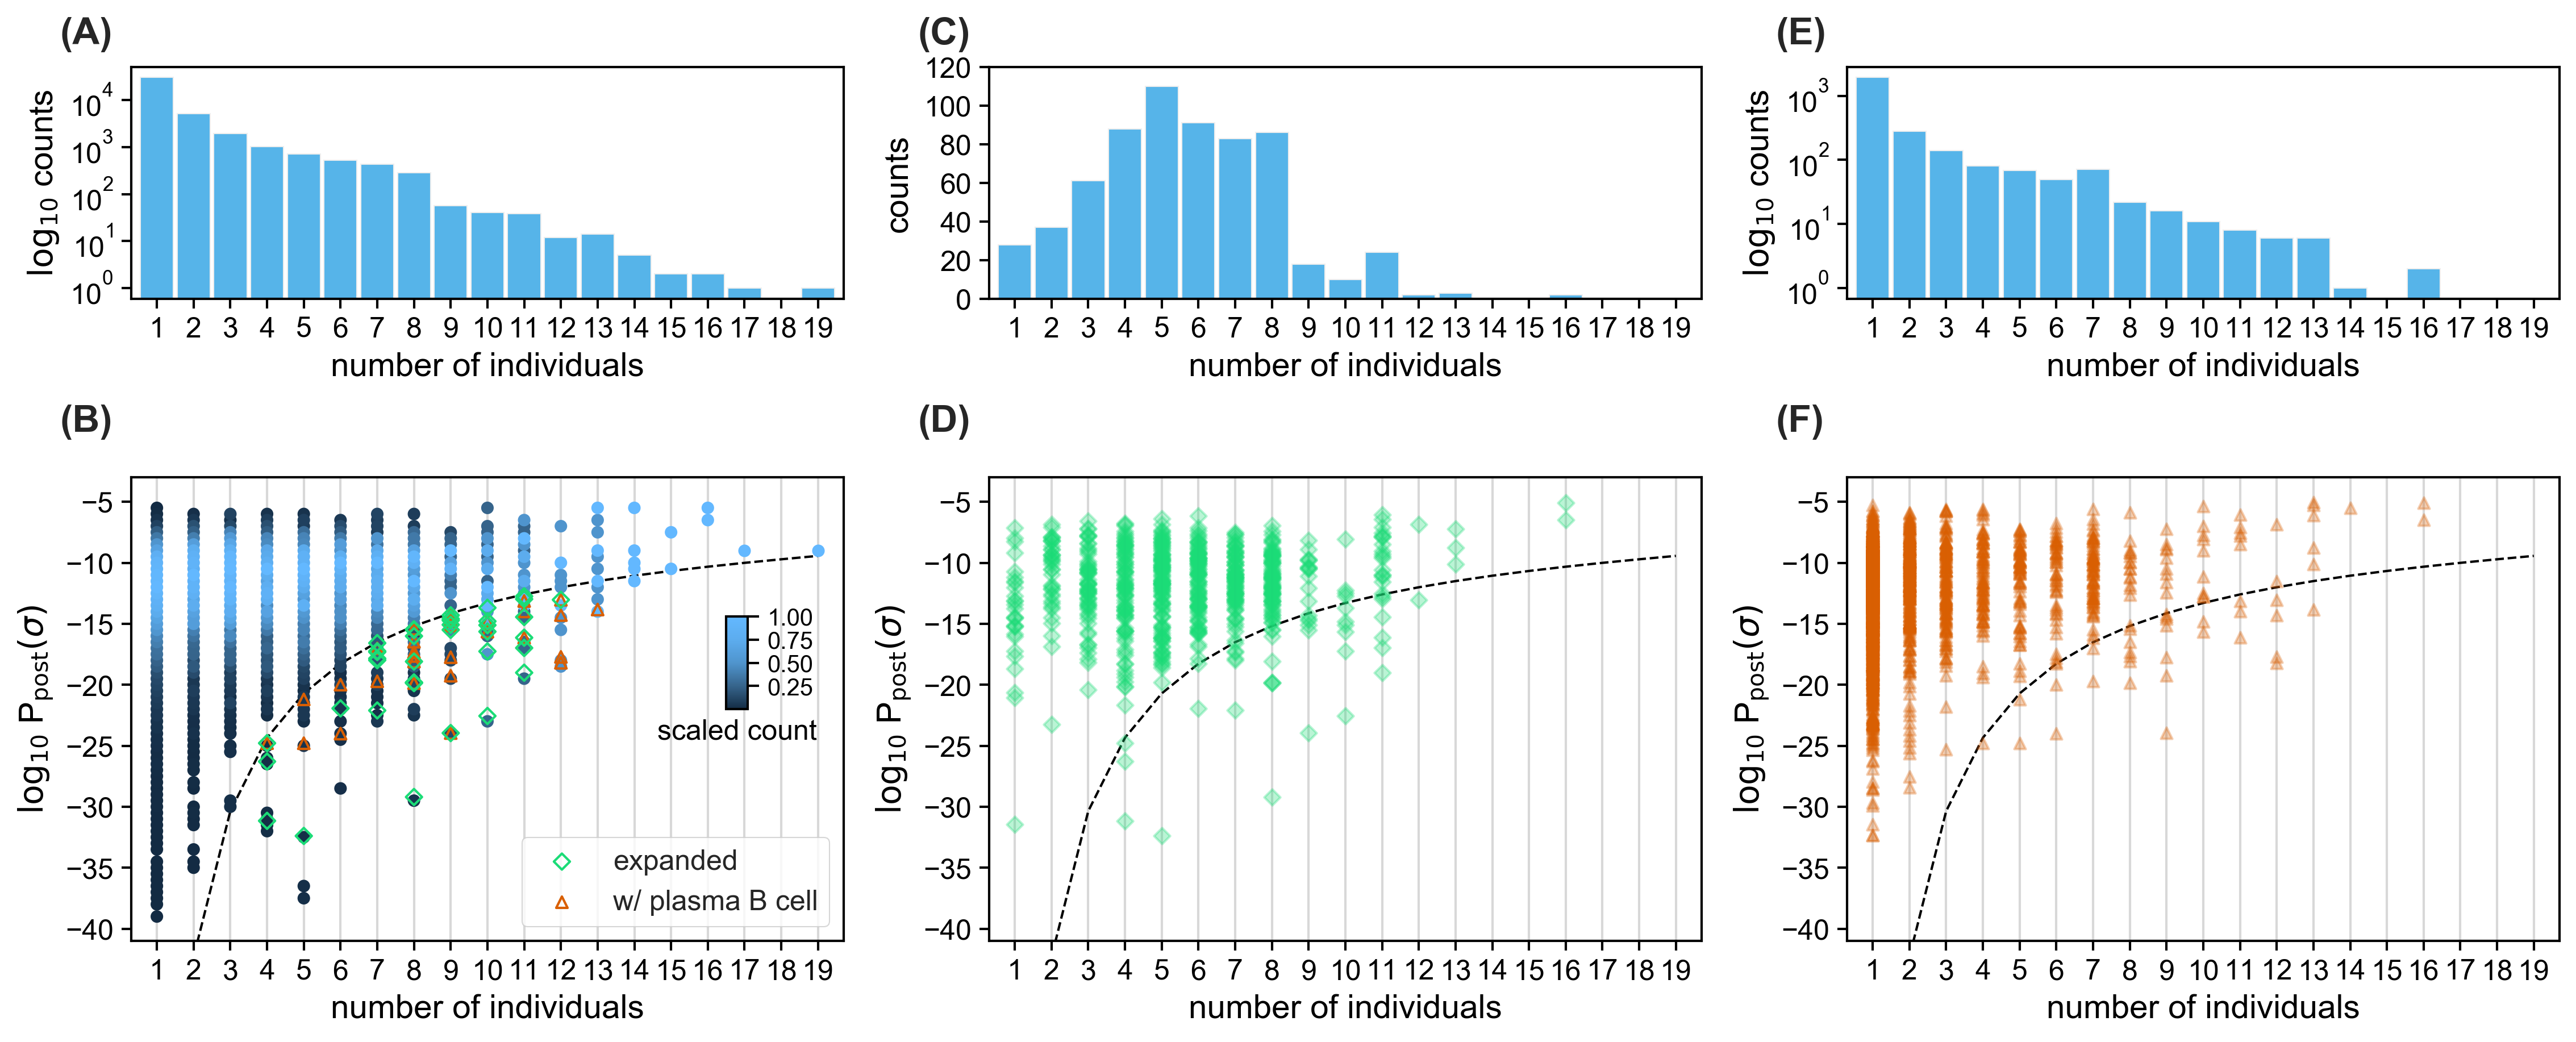

In [40]:
fig = plt.figure(dpi=global_dpi,figsize=(15,6),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, wspace=0.02, hspace=0.05)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])
ax21 = fig.add_subplot(gs[1:, 0])
ax22 = fig.add_subplot(gs[1:, 1])
ax23 = fig.add_subplot(gs[1:, 2])

ax11.hist(df_sharing['share'],rwidth=0.9,log=True,
          bins=df_sharing.share.max(),range=(0.5,df_sharing.share.max()+0.5))
ax11.set_ylabel('$\log_{10}$ counts')
ax11.set_xlabel("number of individuals")
ax11.set_xticks(range(1,df_sharing.share.max() + 1));
ax11.set_yticks(10**np.arange(0,5,1))

ax12.hist(df_sharing.loc[df_sharing.expanded > 0]['share'],rwidth=0.9,
          bins=df_sharing.share.max(),range=(0.5,df_sharing.share.max()+.5))
ax12.set_ylabel('counts')
ax12.set_xlabel("number of individuals")
ax12.set_xticks(range(1,df_sharing.share.max()+1));
ax12.set_yticks(np.arange(0,140,20));

ax13.hist(df_sharing.loc[df_sharing.has_plasma > 0]['share'],rwidth=0.9,log=True,
          bins=df_sharing.share.max(),range=(0.5,df_sharing.share.max()+0.5))
ax13.set_ylabel('$\log_{10}$ counts')
ax13.set_xlabel("number of individuals")
ax13.set_xticks(range(1,df_sharing.share.max()+1));
ax13.set_yticks(10**np.arange(0,4,1))

make_sharing_plot(df_sharing, ax21, bounds)
ax21.set_xlabel("number of individuals")
ax21.set_ylabel('$\log_{10}$ P$_{\mathrm{post}}(\sigma)$')
ax21.set_xticks(np.arange(0,df_sharing.share.max()+1,1));
ax21.set_ylim(-41,-3)
ax21.plot(np.arange(1,len(bounds)+1),bounds,'--',color='black', linewidth=1)
ax21.legend(fontsize=8)

ax22.plot(np.arange(1,len(bounds)+1),bounds,'--',color='black',linewidth=1)
ax22.scatter(df_sharing[df_sharing.expanded > 0]['share'].to_numpy(),
             df_sharing[df_sharing.expanded > 0]['ppost'].to_numpy(),
             facecolor=tuple(list((27/255,220/255,119/255))+[0.3]),
             marker='D',linewidth=1,zorder=50) 
for i in range(1,df_sharing.share.max()+1):
    ax22.axvline(i,linewidth=1,color='grey',zorder=1,alpha=0.3)
ax22.set_xlabel("number of individuals")
ax22.set_ylabel('$\log_{10}$ P$_{\mathrm{post}}(\sigma)$')
ax22.set_xticks(np.arange(1,df_sharing.share.max()+1,1));
ax22.set_ylim(-41,-3)

ax23.plot(np.arange(1,len(bounds)+1),bounds,'--',color='black', linewidth=1)
ax23.scatter(df_sharing[df_sharing.has_plasma > 0]['share'].to_numpy(),
             df_sharing[df_sharing.has_plasma > 0]['ppost'].to_numpy(),
             facecolor=tuple(list((217/255,95/255,2/255))+[0.3]),
             marker='^',linewidth=1,zorder=50) 
for i in range(1,df_sharing.share.max()+1):
    ax23.axvline(i,linewidth=1,color='grey',zorder=1,alpha=0.3)
ax23.set_xlabel("number of individuals")
ax23.set_ylabel('$\log_{10}$ P$_{\mathrm{post}}(\sigma)$')
ax23.set_xticks(np.arange(1,df_sharing.share.max()+1,1));
ax23.set_ylim(-41,-3)

for n, ax in enumerate([ax11, ax21, ax12, ax22, ax13, ax23]):
    ax.text(-0.1, 1.1, "("+string.ascii_uppercase[n]+")", transform=ax.transAxes, 
            size=16, weight='bold')
    ax.set_xlim(0.3,df_sharing.share.max() + 0.7)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(axis='y', which='major', direction='out',length=4,
                  bottom=False, top=False, left=True, right=False,
                  labelsize=12, color='black')
    ax.tick_params(axis='x', which='major', direction='out',length=4,
                  bottom=True, top=False, left=False, right=False,
                  labelsize=12, color='black')
    if n == 1:
        ax.legend(fontsize=12,loc='lower right')
        
    
fig.savefig('/Users/zach/new_covid_figures/Fig6_new.pdf',bbox_inches='tight')
fig.savefig('/Users/zach/new_covid_figures/Fig6_new.png',bbox_inches='tight')

In [41]:
rare_c = (df_sharing.below_share == True)
exp_c = (df_sharing.expanded > 0)
haspla_c = (df_sharing.has_plasma > 0)
overpla_c = (df_sharing.overrep_plasma > 0)
rbd_c = (df_sharing.rbd_unique > 0)
ntd_c = (df_sharing.ntd_unique > 0)

print('Rare:', df_sharing.loc[rare_c].shape[0])
print('Rare, expanded:', df_sharing.loc[rare_c & exp_c].shape[0])
print('Rare, has plasma:', df_sharing.loc[rare_c & haspla_c].shape[0])
print('Rare, overrep\'d plasma', df_sharing.loc[rare_c & overpla_c].shape[0])
print('Rare, ntd match:', df_sharing.loc[rare_c & ntd_c].shape[0])
print('Rare, rbd match:', df_sharing.loc[rare_c & rbd_c].shape[0])
print('Rare, expanded, has plasma:', df_sharing.loc[rare_c & exp_c & haspla_c].shape[0])
print('Rare, expanded, overrep\'d plasma:', df_sharing.loc[rare_c & exp_c & overpla_c].shape[0])
print('')
print('Expanded, rbd match:', df_sharing.loc[rbd_c & exp_c].shape[0])
print('Expanded, ntd match:', df_sharing.loc[ntd_c & exp_c].shape[0])
print('Has plasma, rbd match:', df_sharing.loc[rbd_c & haspla_c].shape[0])
print('Has plasma, ntd match:', df_sharing.loc[ntd_c & haspla_c].shape[0])
print('Overrep\'d plasma, rbd match:', df_sharing.loc[rbd_c & overpla_c].shape[0])
print('Overrep\'d plasma, ntd match:', df_sharing.loc[ntd_c & overpla_c].shape[0])
print('Expanded, has plasma, rbd match:', df_sharing.loc[rbd_c & exp_c & haspla_c].shape[0])
print('Expanded, has plasma, ntd match:', df_sharing.loc[ntd_c & exp_c & haspla_c].shape[0])

Rare: 167
Rare, expanded: 38
Rare, has plasma: 30
Rare, overrep'd plasma 6
Rare, ntd match: 0
Rare, rbd match: 0
Rare, expanded, has plasma: 8
Rare, expanded, overrep'd plasma: 3

Expanded, rbd match: 0
Expanded, ntd match: 2
Has plasma, rbd match: 2
Has plasma, ntd match: 7
Overrep'd plasma, rbd match: 0
Overrep'd plasma, ntd match: 0
Expanded, has plasma, rbd match: 0
Expanded, has plasma, ntd match: 2


In [42]:
print('share at least 2, has plasma:',
      df_sharing.query('(share >= 2) & (has_plasma == True)').shape[0])
print('share at least 2, has plasma, rare:',
      df_sharing.query('(share >= 2) & (has_plasma == True)'
                       ' & (below_share == True)').shape[0])
print('share at least 2, has plasma, expanded:',
      df_sharing.query('(share >= 2) & (has_plasma == True)'
                       ' & (expanded > 0)').shape[0])
print('share at least 2, has plasma, expanded, rare:',
      df_sharing.query('(share >= 2) & (has_plasma == True)'
                       '& (expanded > 0) & (below_share == True)').shape[0])


share at least 2, has plasma: 761
share at least 2, has plasma, rare: 30
share at least 2, has plasma, expanded: 63
share at least 2, has plasma, expanded, rare: 8


In [43]:
num_rare_exp = df_sharing.loc[rare_c & exp_c].shape[0]
num_more_c = df_sharing.loc[rare_c & exp_c].cdr3.str.count('C').value_counts().drop(1).sum()
print(num_rare_exp)
print(num_more_c)
print(num_more_c/num_rare_exp)
p_all = (df_sharing.cdr3.str.count('C')
 .value_counts()
 .reset_index()
 .rename(columns={'index':'c_count'})
 .sort_values('c_count').drop(0)).sum()['cdr3']/df_sharing.shape[0]
sum([binom(num_rare_exp,i)*(p_all)**(i)*(1-p_all)**(num_rare_exp-i)
     for i in range(num_more_c,num_rare_exp+1)])

38
9
0.23684210526315788


0.013042007405253856

In [44]:
(df_sharing
 .loc[rare_c & exp_c]
 .sort_values(['share','ppost'],ascending=[False,True])
 [['v_gene','j_gene','cdr3','share','ppost','has_plasma']]
 .reset_index(drop=True))

v_gene j_gene                              cdr3  share      ppost  \
0     IGHV4-34  IGHJ6                CARDQTVLEWLWYGMDVW     12 -13.034461   
1     IGHV4-39  IGHJ4               CARHVHMTWFEPSPGFDYW     11 -19.011364   
2     IGHV4-39  IGHJ5          CARQKMGSVTIFGVVMHDNWFDPW     11 -16.982180   
3     IGHV4-39  IGHJ3             CARRGRKLLPVAGTIDAFDIW     11 -16.142038   
4      IGHV6-1  IGHJ5                      CARITFAVIPPW     11 -14.447622   
5   IGHV4-30-4  IGHJ4                  CARDRGLGVIENFDYW     11 -12.975454   
6     IGHV4-61  IGHJ1                CARIGYDSSGYYYIFQHW     11 -12.749497   
7      IGHV4-4  IGHJ5          CARGVAGEYWNDGKIRDFNWFDPW     10 -22.559101   
8      IGHV2-5  IGHJ4          CAHSIKPRRSGYCSGGSCYHFDYW     10 -17.263806   
9     IGHV4-34  IGHJ3           CARGRRPVVVPAAGPAGRAFDIW     10 -15.643672   
10    IGHV4-59  IGHJ5            CARQDAWAYCGGDCYRGWFDPW     10 -15.114221   
11     IGHV6-1  IGHJ4                CARGGWGAPGSGRLFDYW     10 -14.796786   
12    IGHV4-61  IGHJ4                  CAREVGSYYDWRPDYW     10 -13.689645   
13    IGHV4-34  IGHJ6     CARGDDNYCTYSYGYGRLNRYYYYGMDVW      9 -23.960727   
14    IGHV2-70  IGHJ4                 CARSYGTTVVTRAFDYW      9 -15.498174   
15    IGHV4-34  IGHJ6          CARGQRSGACSGGSCVYYYGMDVW      9 -15.081189   
16     IGHV4-4  IGHJ6             CATLSRRAAAGTRDYYGMDVW      9 -14.721484   
17    IGHV4-34  IGHJ4             CARGSRQWLVRPPHYYYFDYW      9 -14.599129   
18    IGHV4-59  IGHJ4             CARSRSGGSCYSFPSWYFDYW      9 -14.305201   
19    IGHV4-39  IGHJ4       CVRSRAERYFDWTKLDAHVKPYYFDYW      8 -29.202500   
20     IGHV2-5  IGHJ2         CAHVGMACSGGSCYSKIKDWYFDLW      8 -19.863515   
21    IGHV4-34  IGHJ5              CAMGFHCSGGSCYDGVLGSW      8 -19.833157   
22     IGHV2-5  IGHJ4           CAQSNDVLRYFDWLYKMRGFDYW      8 -19.806504   
23    IGHV4-34  IGHJ2         CARLNGWGIVVVIAIPRKNWYFDLW      8 -18.096516   
24    IGHV4-34  IGHJ5              CARESYAYTLTRGSTWFDPW      8 -16.011614   
25    IGHV4-39  IGHJ2               CARHGEMATIVGWWYFDLW      8 -15.508374   
26    IGHV4-59  IGHJ4              CARHALGYFDWLNEGYFDYW      8 -15.458755   
27    IGHV4-59  IGHJ4           CARGDVEMATIKSGGPFYHFDYW      7 -22.109092   
28    IGHV4-39  IGHJ6          CARDKAEYIVVVPAVPLAYGMDVW      7 -17.986985   
29    IGHV4-39  IGHJ2          CARSDLSVIVLVVYATRGGYFDLW      7 -17.848636   
30    IGHV3-30  IGHJ6       CAKDQGYCSSTSCFRGWTYYYYGMDVW      7 -17.313692   
31    IGHV4-59  IGHJ4                CARHRRLGLISDSSVDYW      7 -17.249836   
32     IGHV6-1  IGHJ6         CARGRMVPYSSSWTTLYYYYGMDVW      7 -16.584288   
33    IGHV3-30  IGHJ4              CAKDATIFWFERGRGTFDYW      6 -21.935752   
34    IGHV4-61  IGHJ6  CARDRPESWRISPRLGELCATVVHSASGMDVW      5 -32.395064   
35    IGHV4-28  IGHJ4    CATGFSGYSSSWYDKPLLEVEHAGPYFDYW      4 -31.156579   
36    IGHV4-34  IGHJ6       CARSTVTNSPFGFSNKLRSRYYGMDVW      4 -26.293626   
37    IGHV4-34  IGHJ5     CARGETRLPVRSAFPVWFGELFANWFDPW      4 -24.788410   

    has_plasma  
0         True  
1        False  
2        False  
3         True  
4        False  
5        False  
6        False  
7        False  
8        False  
9         True  
10       False  
11       False  
12       False  
13        True  
14       False  
15       False  
16       False  
17        True  
18       False  
19       False  
20        True  
21       False  
22       False  
23        True  
24       False  
25       False  
26       False  
27       False  
28       False  
29       False  
30       False  
31       False  
32       False  
33       False  
34       False  
35       False  
36       False  
37        True

In [45]:
print('share at least 2:', df_sharing.query('(share >= 2)').shape[0])

share at least 2: 10146


In [46]:
num_lins_denom = df_sharing.query('(share >= 2)').shape[0]
denom = df_sharing.query('(share >= 2)').share.sum()
num_lins_numer = df_sharing.query('(share >= 2) & (has_plasma == True)').shape[0]
numer = df_sharing.query('(share >= 2) & (has_plasma == True)').share.sum()
p_all = num_lins_numer / num_lins_denom
print(num_lins_numer, numer, num_lins_denom, denom, p_all)

761 3153 10146 33796 0.07500492805046324


In [47]:
num_lins_denom = df_sharing.query('(share >= 2) & (below_share)').shape[0]
denom = df_sharing.query('(share >= 2) & (below_share)').share.sum()
num_lins_numer = df_sharing.query('(share >= 2) & (below_share) & (has_plasma == True)').shape[0]
numer = df_sharing.query('(share >= 2) & (below_share) & (has_plasma == True)').share.sum()
p = numer/denom
print(num_lins_numer, numer, num_lins_denom, denom, p)

30 265 167 1309 0.20244461420932008


In [48]:
sum([binom(num_lins_denom,i)*(p_all)**(i)*(1-p_all)**(num_lins_denom-i)
     for i in range(num_lins_numer,num_lins_denom+1)])

7.164042324098892e-06

In [49]:
num_lins_denom = df_sharing.query('(share >= 2)&(expanded > 0)').shape[0]
denom = df_sharing.query('(share >= 2)&(expanded > 0)').share.sum()
num_lins_numer = df_sharing.query('(share >= 2) & (has_plasma == True)&(expanded > 0)').shape[0]
numer = df_sharing.query('(share >= 2) & (has_plasma == True)&(expanded > 0)').share.sum()
p_all = num_lins_numer / num_lins_denom
print(num_lins_numer, numer, num_lins_denom, denom, p_all)

63 438 615 3595 0.1024390243902439


In [50]:
num_lins_denom = df_sharing.query('(share >= 2) & (below_share) & (expanded > 0)').shape[0]
denom = df_sharing.query('(share >= 2) & (below_share)& (expanded > 0)').share.sum()
num_lins_numer = df_sharing.query('(share >= 2) & (below_share) & (has_plasma == True)& (expanded > 0)').shape[0]
numer = df_sharing.query('(share >= 2) & (below_share) & (has_plasma == True)& (expanded == True)').share.sum()
p = numer/denom
print(num_lins_numer, numer, num_lins_denom, denom, p)

8 61 38 321 0.19003115264797507


In [51]:
sum([binom(num_lins_denom,i)*(p_all)**(i)*(1-p_all)**(num_lins_denom-i)
     for i in range(num_lins_numer,num_lins_denom+1)])

0.036034021932250526

# Single cell and mAb plots

In [52]:
def make_v_gene_plot(in_df, in_ax, legend_loc, labelsize, ticksize, legendsize):
    testcp=["#ef476f",
        "#ffd166",
        '#06d6a0',
        '#118ab2']
    
    def keep_max_greater_than_p1(grp):
        if np.max(grp['count']) > 0.01:
            return grp
    
    mab_rbd = (in_df.loc[(in_df.Antigen_target == 'RBD')
                                 & ~(in_df.v_gene == '-')]
     .v_gene
     .value_counts(normalize=True)
     .rename('count')
     .reset_index()
     .assign(type_int = 1)
     .rename(columns={'index': 'v_gene'}))

    mab_ntd = (in_df.loc[(in_df.Antigen_target == 'NTD')
                                     & ~(in_df.v_gene == '-')]
     .v_gene
     .value_counts(normalize=True)
     .rename('count')
     .reset_index()
     .assign(type_int = 3)
     .rename(columns={'index': 'v_gene'}))
    
    type_int = []
    for rowidx, row in enumerate(df_sc.itertuples()):
        if row.type == 'rbd':
            type_int.append(2)
        else:
            type_int.append(4)

    df_sc['type_int'] = type_int

    df_sc_vgene = (df_sc['v_gene']
     .groupby(df_sc['type_int'])
     .value_counts(normalize=True)
     .rename('count')
     .reset_index())
    
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    x='v_gene'
    hue = 'type_int'
    y='count'

    #ax21 = fig.add_subplot(gs[1,0])

    in_df_antigen_v_gene = pd.concat([df_sc_vgene, mab_rbd, mab_ntd]).sort_values('type_int')
    #return in_df_antigen_v_gene
    df_antigen_v_gene = in_df_antigen_v_gene.groupby('v_gene').apply(keep_max_greater_than_p1)
    (df_antigen_v_gene.sort_values(['type_int','count'],ascending=[True,False])
     .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, ax=in_ax, palette=testcp,zorder=10))
    in_ax.xaxis.label.set_size(labelsize)
    in_ax.yaxis.label.set_size(labelsize)
    in_ax.tick_params(axis='both', which='major', direction='in',length=4,
                      bottom=True, top=True, left=True, right=True,
                      labelsize=ticksize, color='grey',zorder=3)
    in_ax.tick_params(axis='both', which='minor', direction='in',length=2,
                      bottom=True, top=True, left=True, right=True,
                      color='grey',zorder=3)
    in_ax.set_xticklabels(in_ax.get_xticklabels(), rotation=90);
    print(in_ax.get_xticklabels()[0])
    in_ax.set_xlabel('')
    in_ax.set_ylabel('PDF')

    rbd_label = 'sorted SC - RBD (N = ' + str(df_sc.query('type == "rbd"').shape[0]) + ')'
    known_rbd_label = 'verified mAb - RBD (N = ' + str(in_df.query('Antigen_target == "RBD"').shape[0]) + ')'
    ntd_label = 'sorted SC - NTD (N = ' + str(df_sc.query('type == "ntd"').shape[0]) + ')'
    known_ntd_label = 'verified mAb - NTD (N = ' + str(in_df.query('Antigen_target == "NTD"').shape[0]) + ')'
    handles, labels = in_ax.get_legend_handles_labels()
    labels = [known_rbd_label, rbd_label, known_ntd_label, ntd_label]

    in_ax.legend(handles,labels,fontsize=legendsize,loc=legend_loc)
    in_ax.set_xlim(in_ax.get_xlim()[0], in_ax.get_xlim()[1])
    return in_ax

In [53]:
mab_rbd_counts = []
mab_ntd_counts = []
mab_rbd_dict = {}
mab_ntd_dict = {}
for rowidx, row in enumerate(df_sharing.query('mab_ab_dist < 2').itertuples()):
    mab_subset = mab_abs.iloc[row.mab_ab_matches]
    unique_subset = (mab_subset
                     .sort_values('antigen_int')
                     .drop_duplicates(['cdr3','v_gene']))
    rbd_counts = unique_subset.query('(Source.str.contains("SARS-2"))'
                                     '& (Antigen_target == "RBD")').shape[0]
    ntd_counts = unique_subset.query('(Source.str.contains("SARS-2"))'
                                     '& (Antigen_target == "NTD")').shape[0]

    for count in range(rbd_counts):
        mab_rbd_counts.append(row.share)
    for count in range(ntd_counts):
        mab_ntd_counts.append(row.share)

TypeError: unhashable type: 'numpy.ndarray'

In [51]:
def get_vjc(grp):
    grp = grp.copy()
    grp = grp.set_index(['cdr3','v_gene','j_gene'])
    return lineages.set_index(['cdr3','v_gene','j_gene']).loc[grp.index].patient.unique().shape[0]
def get_sc_info(grp):
    grp = grp.copy()
    grp = grp.set_index(['cdr3','v_gene','j_gene'])
    return lineages.set_index(['cdr3','v_gene','j_gene']).loc[grp.index].sort_values('bulk_abundance',ascending=False)

In [52]:
good_rbds = df_sharing.query('rbd_unique > 0').rbd_seqs_str.str.split('-').str[0].unique()
good_ntds = df_sharing.query('ntd_unique > 0').ntd_seqs_str.str.split('-').str[0].unique()

In [53]:
def get_vjc(grp):
    grp = grp.copy()
    grp = grp.set_index(['cdr3','v_gene','j_gene'])
    return lineages.set_index(['cdr3','v_gene','j_gene']).loc[grp.index].patient.unique().shape[0]

def get_sc_info(grp):
    grp = grp.copy()
    grp = grp.set_index(['cdr3','v_gene','j_gene'])
    return lineages.set_index(['cdr3','v_gene','j_gene']).loc[grp.index].sort_values('bulk_abundance',ascending=False)

df_ntd_counts_in = (df_sharing
 .query('ntd_unique > 0')
 .groupby('ntd_seqs_str')
 .apply(get_vjc)
 .rename('num_unique_patient')
 .reset_index()
 .assign(name=lambda df: df.ntd_seqs_str.str.split('-').str[0]))
df_ntd_counts = (df_ntd_counts_in
 ['num_unique_patient']
 .value_counts()
 .reset_index()
 .rename(columns={'index':'num_share', 'num_unique_patient':'counts'}))
df_ntd_counts['type'] = 3

df_rbd_counts_in = (df_sharing
 .query('rbd_unique > 0')
 .groupby('rbd_seqs_str')
 .apply(get_vjc)
 .rename('num_unique_patient')
 .reset_index()
 .assign(name=lambda df: df.rbd_seqs_str.str.split('-').str[0]))
df_rbd_counts = (df_rbd_counts_in
 ['num_unique_patient']
 .value_counts()
 .reset_index()
 .rename(columns={'index':'num_share', 'num_unique_patient':'counts'}))
df_rbd_counts['type'] = 1

df_ntd_counts_in = df_ntd_counts_in.set_index('name')
df_rbd_counts_in = df_rbd_counts_in.set_index('name')

In [54]:
ntd_keys = np.array([s.split('_')[0] for s in good_ntds])
df_ntd_onerow_subset = df_ntd_abstar_onerow.loc[ntd_keys]

for_armita = {'id':[],'hcdr3':[],'ighv':[],'ighj':[],
              'lcdr3':[],'light_v':[], 'light_j':[],
              'ppost': [], 'num_share': [],
              'plasmablast':[],'type':[]}

def check_pla(grp):
    return np.sum(grp['has_plasma'])
ntd_plasma_check = (df_sharing
                    .query('ntd_unique > 0')
                    .groupby('ntd_seqs_str')
                    .apply(check_pla)   
                    .rename('has_plasma')
                    .reset_index()
                    .assign(name = lambda df: df.ntd_seqs_str.str.split('-').str[0])
                    .set_index('name'))
    
for rowidx, row in enumerate(df_ntd_onerow_subset.itertuples()):
    for_armita['id'].append(row.Index)
    for_armita['hcdr3'].append(row.igh_cdr3s)
    for_armita['ighv'].append(row.igh_v_genes)
    for_armita['ighj'].append(row.igh_j_genes)
    if row.igl_cdr3s is np.nan:
        for_armita['lcdr3'].append(row.igk_cdr3s)
        for_armita['light_v'].append(row.igk_v_genes)
        for_armita['light_j'].append(row.igk_j_genes)
    else:
        for_armita['lcdr3'].append(row.igl_cdr3s)
        for_armita['light_v'].append(row.igl_v_genes)
        for_armita['light_j'].append(row.igl_j_genes)
        
    for_armita['ppost'].append(df_sc.query('type == "ntd"').loc[good_ntds[rowidx]].ppost)
    for_armita['num_share'].append(df_ntd_counts_in.loc[good_ntds[rowidx]].num_unique_patient)
    for_armita['plasmablast'].append(ntd_plasma_check.loc[good_ntds[rowidx]].has_plasma > 0)
    for_armita['type'].append('ntd')
    
df_ntd_for_armita = pd.DataFrame(for_armita)
#df_ntd_for_armita.sort_values('num_share').to_csv('/usr/lusers/zacmon/covid_figures/single_cell_ntd.csv',index=False)

In [55]:
rbd_keys = np.array([s.split('_')[0] for s in good_rbds])
df_rbd_onerow_subset = df_rbd_abstar_onerow.loc[rbd_keys]

for_armita = {'id':[],'hcdr3':[],'ighv':[],'ighj':[],
              'lcdr3':[],'light_v':[], 'light_j':[],
              'ppost': [], 'num_share': [],
              'plasmablast':[],'type':[]}

def check_pla(grp):
    return np.sum(grp['has_plasma'])
rbd_plasma_check = (df_sharing
                    .query('rbd_unique > 0')
                    .groupby('rbd_seqs_str')
                    .apply(check_pla)   
                    .rename('has_plasma')
                    .reset_index()
                    .assign(name = lambda df: df.rbd_seqs_str.str.split('-').str[0])
                    .set_index('name'))
    
for rowidx, row in enumerate(df_rbd_onerow_subset.itertuples()):
    for_armita['id'].append(row.Index)
    for_armita['hcdr3'].append(row.igh_cdr3s)
    for_armita['ighv'].append(row.igh_v_genes)
    for_armita['ighj'].append(row.igh_j_genes)
    if row.igl_cdr3s is np.nan:
        for_armita['lcdr3'].append(row.igk_cdr3s)
        for_armita['light_v'].append(row.igk_v_genes)
        for_armita['light_j'].append(row.igk_j_genes)
    else:
        for_armita['lcdr3'].append(row.igl_cdr3s)
        for_armita['light_v'].append(row.igl_v_genes)
        for_armita['light_j'].append(row.igl_j_genes)
        
    for_armita['ppost'].append(df_sc.query('type == "rbd"').loc[good_rbds[rowidx]].ppost)
    for_armita['num_share'].append(df_rbd_counts_in.loc[good_rbds[rowidx]].num_unique_patient)
    for_armita['plasmablast'].append(rbd_plasma_check.loc[good_rbds[rowidx]].has_plasma > 0)
    for_armita['type'].append('rbd')
df_rbd_for_armita = pd.DataFrame(for_armita)

In [56]:
(pd.concat([df_rbd_for_armita,df_ntd_for_armita])
.to_csv('/usr/lusers/zacmon/covid_figures/single_cell.csv',index=False))

In [57]:
# Counting table 1
rbd_mab_counts = Counter([5,
 1,
 1,
 2, 2,
 1, 1, 1, 
 1,
 1,1,
 3,
 2,
 1,
 1,
 2,
 1,
 1,1,
 3,
 2])
for i in range(1,12):
    if i not in rbd_mab_counts:
        rbd_mab_counts[i] = 0
rbd_mab_counts = sort_dict(rbd_mab_counts)

In [58]:
rbd_mab_counts_df = pd.DataFrame({'num_share': list(rbd_mab_counts.keys()),
                       'counts': list(rbd_mab_counts.values()),
                       'type': [0]*len(list(rbd_mab_counts.values()))})

In [59]:
ntd_mab_counts_df = pd.DataFrame({'num_share':[8],'counts':[1],'type':2})

In [60]:
df_mab_sc_hist_input = pd.concat([rbd_mab_counts_df,
                                  df_rbd_counts,
                                  ntd_mab_counts_df,
                                  df_ntd_counts])

Text(0, 0, 'IGHV3-53')


/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


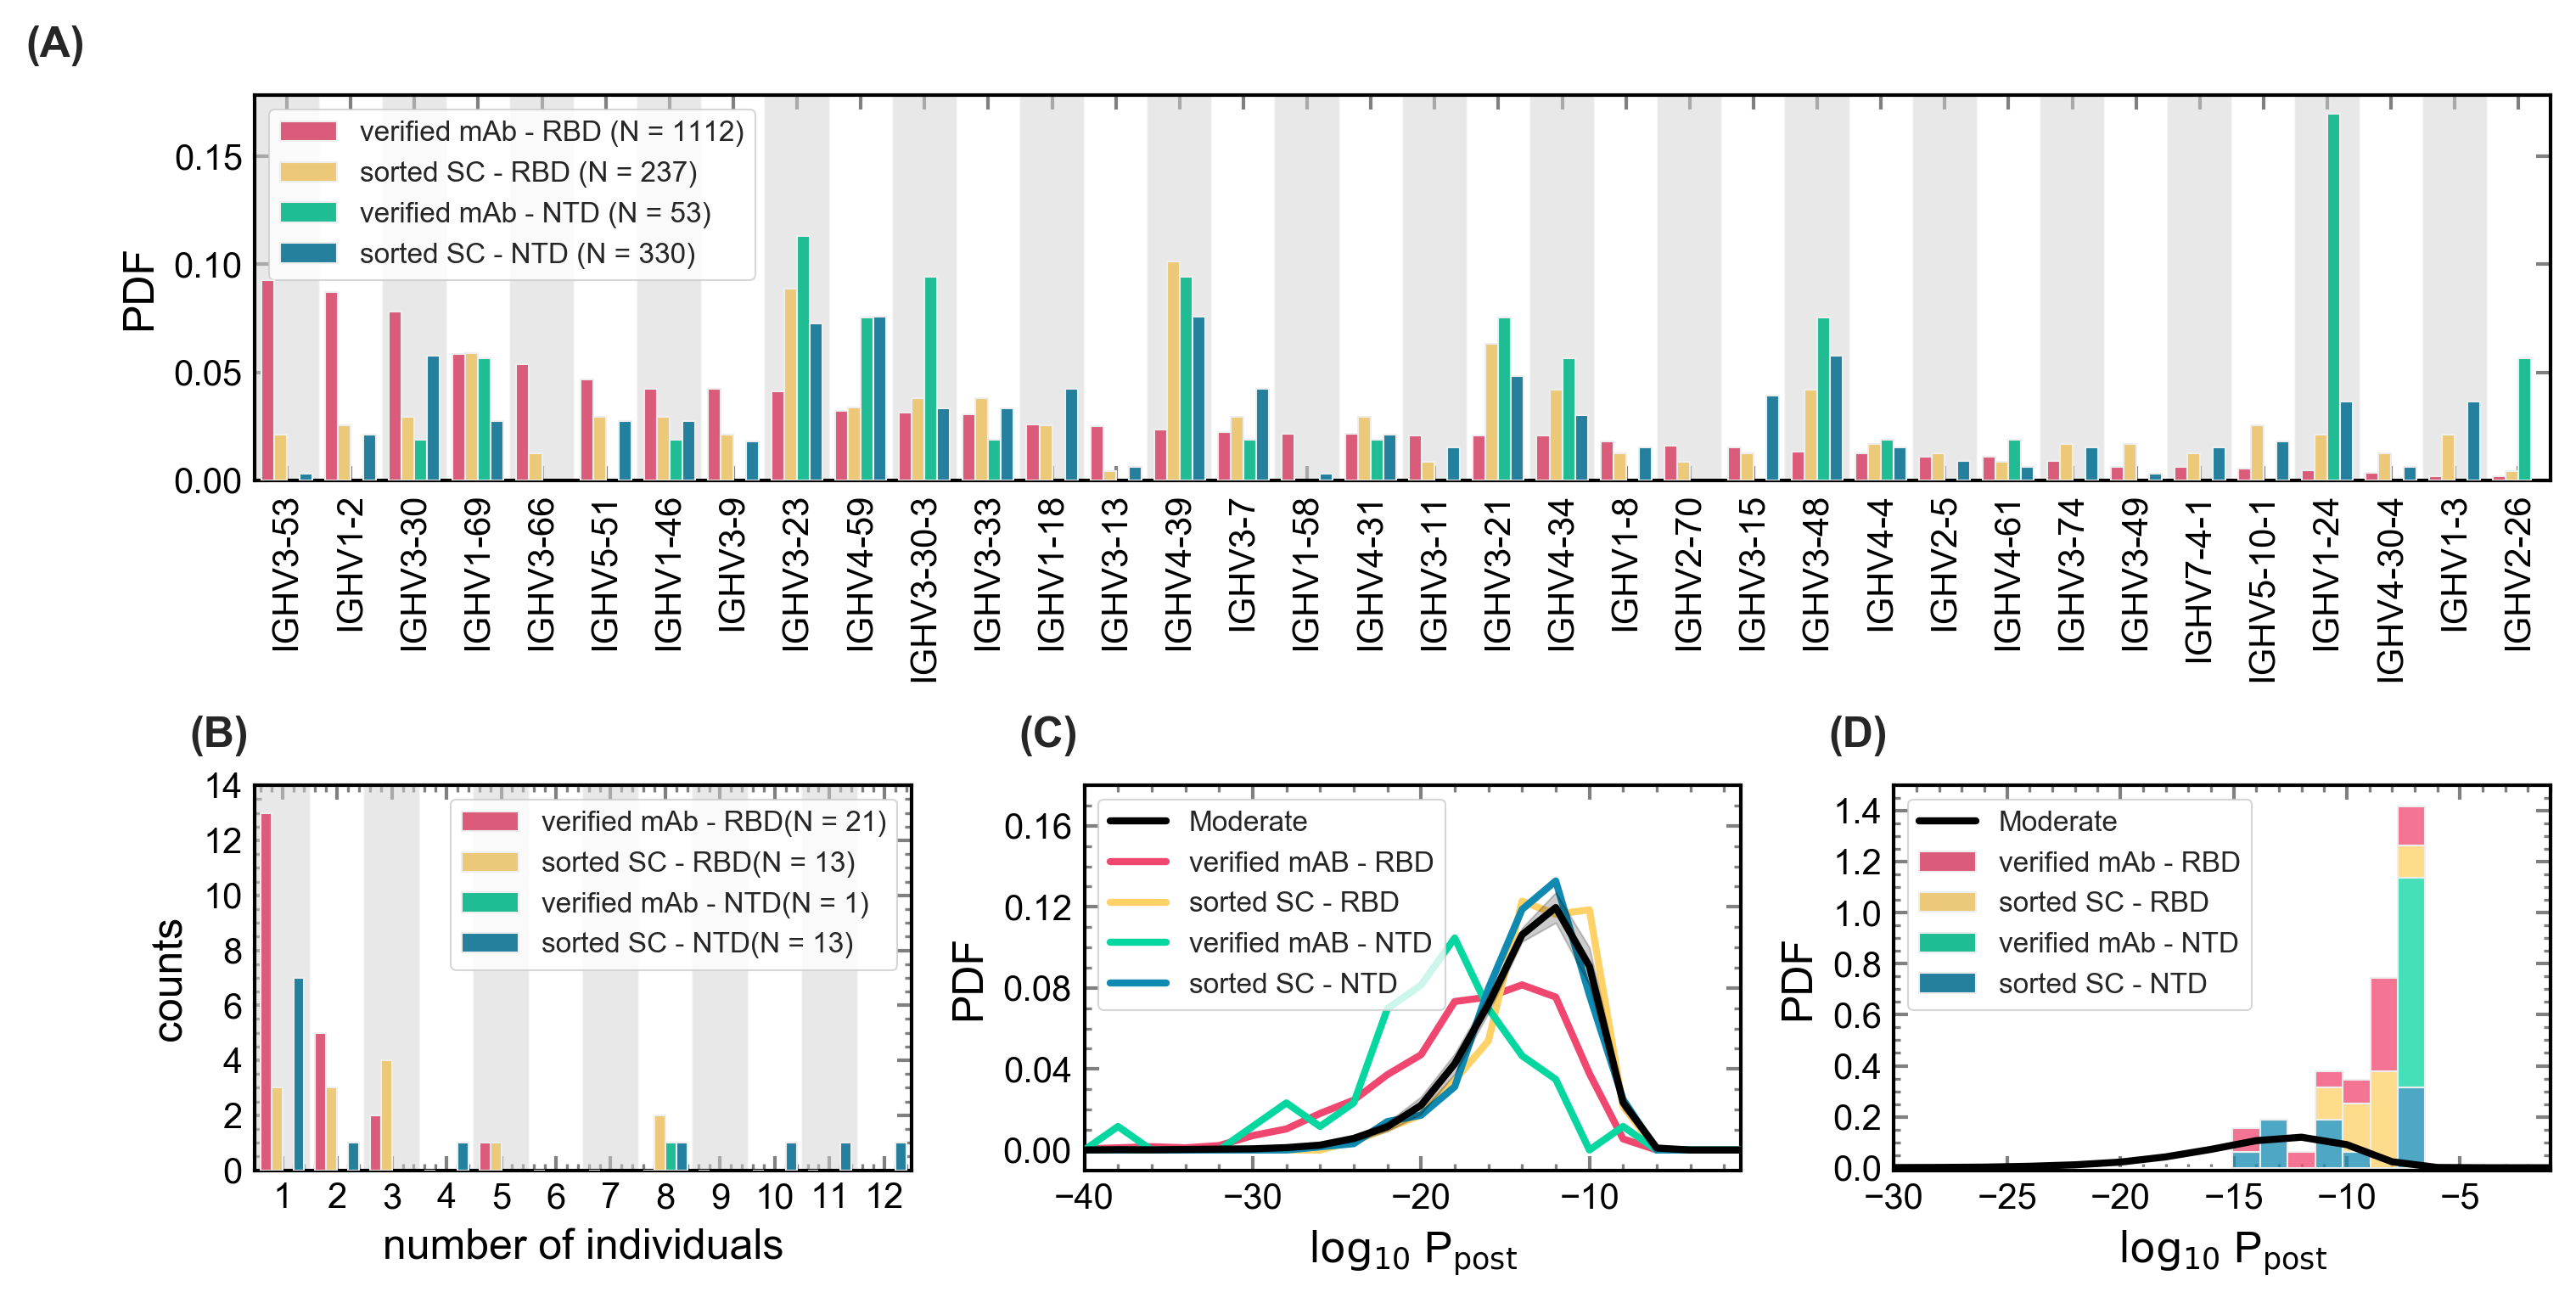

In [61]:
def ppost_bin(grp):
    freqs,bins = np.histogram(grp, np.linspace(-40,2,22), density=True)
    return tuple(freqs)
def average_bin_ppost(grp):
    avgs = []
    stds = []
    for idx, _ in enumerate(list(grp)[0]):
        avgs.append(np.mean([g[idx] for g in grp]))
        stds.append(np.std([g[idx] for g in grp]))
    return tuple([np.array(avgs), np.array(stds)])
testcp=["#ef476f",
    "#ffd166",
    '#06d6a0',
    '#118ab2']
linspace = np.linspace(-40,2,22)

class GridShader():
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]-0.5], xticks-0.5, [xlim[-1]-0.5]]))

        start = locs[1-int(self.sf)::2]  
        end = locs[2-int(self.sf)::2]

        for s, e in zip(start, end):
            self.spans.append(self.ax.axvspan(s, e, zorder=1, **self.kw))


fig = plt.figure(dpi=global_dpi,figsize=(10,5),constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=3, wspace=0.025, hspace=0.05)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[1, 2])
axes = [ax0, ax1, ax2, ax3]
testcp=["#ef476f",
    "#ffd166",
    '#06d6a0',
    '#118ab2']
gsh = GridShader(ax0, facecolor="lightgrey", first=False, alpha=0.5)
make_v_gene_plot(mab_abs, ax0, 'upper left', labelsize=12,ticksize=10,legendsize=8)

    

(df_mab_sc_hist_input.sort_values(['type','counts'],ascending=[True,False])
 .pipe((sns.barplot, "data"), x='num_share', y='counts', hue='type', ax=ax1,
       palette=testcp,zorder=10))
format_axes(ax1, ticksize=16, labelsize=20, legendsize=12)
gsh = GridShader(ax1, facecolor="lightgrey", first=False, alpha=0.5)
rbd_label = 'sorted SC - RBD'
known_rbd_label = 'verified mAb - RBD'
ntd_label = 'sorted SC - NTD'
known_ntd_label = 'verified mAb - NTD'

handles, labels = ax1.get_legend_handles_labels()
total_matches = df_mab_sc_hist_input.groupby('type').sum()['counts']
labels = [known_rbd_label + ''.join(['(N = ',str(total_matches.loc[0]),')']),
          rbd_label + ''.join(['(N = ',str(total_matches.loc[1]),')']),
          known_ntd_label + ''.join(['(N = ',str(total_matches.loc[2]),')']),
          ntd_label + ''.join(['(N = ',str(total_matches.loc[3]),')'])]
ax1.set_yticks(np.arange(0,15,2))
ax1.set_xlabel('number of individuals')
ax1.set_ylabel('counts')
format_axes(ax1)
ax1.legend(handles, labels,fontsize=8,loc='upper right')
ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])



ppost_for_hist = (all_lineages.query('bulk_abundance > 0')
 .groupby(['patient','severity'])
 .agg({'ppost': ppost_bin})
 .reset_index()
 .groupby('severity')
 .agg({'ppost': average_bin_ppost}))

hist_colors = ["#0072B2","#009E73","#E69F00","#D55E00","#CC79A7"]
labels = ['Healthy','Mild','Moderate','Severe']
bins=linspace[:-1]
s = 'moderate'
for ax in axes[2:]:
    ax.plot(bins,ppost_for_hist.loc['moderate'][0][0],
            zorder=10,color="#000000",label=labels[2])
    ax.fill_between(bins, ppost_for_hist.loc['moderate'][0][0] 
                          - ppost_for_hist.loc['moderate'][0][1],
                    ppost_for_hist.loc['moderate'][0][0]
                    + ppost_for_hist.loc['moderate'][0][1],
                    alpha=0.2, color="#000000",zorder=10)
    ax.set_xlim(-40,-1)
    ax.set_ylabel('PDF')
    ax.set_xlabel('$\log_{10}$ P$_{\mathrm{post}}$')
    
mab_ppost = (mab_abs
             .sort_values('antigen_int')
             .drop_duplicates(['cdr3','v_gene'])
             .groupby('Antigen_target')
             .agg({'geo_ppost': ppost_bin,
                   'max_ppost': ppost_bin}))
single_cell_ppost = df_sc.groupby('type').agg({'ppost': ppost_bin})


ax2.plot(bins,mab_ppost.loc['RBD']['max_ppost'],
            zorder=3,color=testcp[0],label='verified mAB - RBD')
ax2.plot(bins,single_cell_ppost.loc['rbd'][0],
            zorder=3,color=testcp[1],label='sorted SC - RBD')

ax2.plot(bins,mab_ppost.loc['NTD']['max_ppost'],
            zorder=3,color=testcp[2],label='verified mAB - NTD')
ax2.plot(bins,single_cell_ppost.loc['ntd'][0],
            zorder=3,color=testcp[3],label='sorted SC - NTD')
ax2.legend(loc='upper left')
ax2.set_ylim(-0.01,0.18)
ax2.set_yticks(np.arange(0,0.2,0.04))
format_axes(ax2)

good_rbds = df_sharing.query('rbd_unique > 0').rbd_seqs_str.str.split('-').str[0].unique()
good_ntds = df_sharing.query('ntd_unique > 0').ntd_seqs_str.str.split('-').str[0].unique()

single_cell_rbd_ppost = (df_sc.query('type == "rbd"')
                           .loc[good_rbds]
                           .groupby('type')
                           .agg({'ppost':ppost_bin})
                           .loc['rbd'][0])
single_cell_ntd_ppost = (df_sc.query('type == "ntd"')
                           .loc[good_ntds]
                           .groupby('type')
                           .agg({'ppost':ppost_bin})
                         .loc['ntd'][0])

mab_matches = np.unique(np.concatenate(df_sharing
                             .query('mab_ab_dist < 2')
                             .mab_ab_matches
                             .to_numpy()))
mab_match_ppost = (mab_abs.iloc[mab_matches]
             .sort_values('antigen_int')
             .drop_duplicates(['cdr3','v_gene'])
             .groupby('Antigen_target')
             .agg({'geo_ppost': ppost_bin,
                   'max_ppost': ppost_bin}))

labels = [known_rbd_label, rbd_label, known_ntd_label, ntd_label]
for_hists = [mab_abs.iloc[mab_matches].query('antigen_int == 0').max_ppost,
             df_sc.query('type == "rbd"').loc[np.unique(good_rbds)].ppost,
             mab_abs.iloc[mab_matches].query('antigen_int == 1').max_ppost,
             df_sc.query('type == "ntd"').loc[np.unique(good_ntds)].ppost]

ant_ints = []
for idx,fh in enumerate(for_hists):
    ant_ints += [idx]*len(fh)
hist_df=pd.concat(for_hists).to_frame().rename(columns={0:'ppost'})
hist_df['antigen_int'] = ant_ints
hp = sns.histplot(hist_df, x='ppost', hue='antigen_int',ax=ax3,
             stat="density", common_norm=False, palette=testcp,multiple='stack')

ax3.set_ylim(-0.01,1.5)
ax3.set_xlim(-30,-1)
ax3.set_yticks(np.arange(0,1.5,0.2))
mod_handle, mod_label = ax3.get_legend_handles_labels()
handles, labels = ax1.get_legend_handles_labels()
labels = mod_label+[known_rbd_label, rbd_label, known_ntd_label, ntd_label]
ax3.legend(mod_handle + handles, labels, loc='upper left')
format_axes(ax3,box=True)

for n, ax in enumerate(axes):
    ax.text(-0.1, 1.1, "("+string.ascii_uppercase[n]+")", transform=ax.transAxes, 
            size=12, weight='bold')
    
fig.savefig('/usr/lusers/zacmon/covid_figures/Fig7_new.pdf',
            bbox_inches='tight')
fig.savefig('/usr/lusers/zacmon/covid_figures/Fig7_new.png',
            bbox_inches='tight')

In [62]:
ntd_keys = np.array([s.split('_')[0] for s in good_ntds])
df_ntd_onerow_subset = df_ntd_abstar_onerow.loc[ntd_keys]

for_armita = {'hcdr3':[],'h_v':[],'h_j':[],
              'lcdr3':[],'l_v':[], 'l_j':[],
              'ppost': [], 'num_share': [],
              'plasmablast':[]}

#for rowidx, row in enumerate(df_ntd_onerow_subset.itertuples()):
    
df_ntd_abstar_onerow.loc[ntd_keys][['igh_v_genes','igh_j_genes','igh_cdr3s']]

igh_v_genes igh_j_genes                igh_cdr3s
clonotype_id                                                 
clonotype221    IGHV3-23       IGHJ4       CAKAPAYDFWSGYHLDYW
clonotype23      IGHV3-9       IGHJ6            CAKDTYYYGMDVW
clonotype333    IGHV3-30       IGHJ6         CAKDIVSRYYYGMDVW
clonotype317  IGHV3-30-3       IGHJ5             CARDGGGWFDPW
clonotype72     IGHV3-30       IGHJ6        CAREGNLHYYYYYMDVW
clonotype341    IGHV4-59       IGHJ4           CARETPYGASIDYW
clonotype121  IGHV4-30-4       IGHJ4            CARESGSYYFDYW
clonotype277    IGHV3-33       IGHJ4         CARGYYDFWSGYFDYW
clonotype169    IGHV4-59       IGHJ4         CARSEYSSGWYYFDYW
clonotype315    IGHV1-24       IGHJ5       CATAPPIGGAMYNWFDPW
clonotype223    IGHV1-24       IGHJ6  CVTAPVVRGSPSDYYYYYGMDVW
clonotype344    IGHV1-24       IGHJ5        CATGPAVAGTSDWFDPW
clonotype274    IGHV3-15       IGHJ4     CTTDRYYDYVWGSYRTPGYW

In [63]:
df_sc.query('type=="rbd"').loc[good_rbds]

progenitor_cdr3      v_gene j_gene  \
consensus_id                                                      
clonotype65_consensus_2     CARGQYSSSWYYFDYW    IGHV3-33  IGHJ4   
clonotype243_consensus_1      CARHDYGDRDFDYW    IGHV4-39  IGHJ4   
clonotype170_consensus_2      CARAGIVGATIDYW    IGHV3-48  IGHJ4   
clonotype45_consensus_2       CAKDIAVAGYFDYW    IGHV3-33  IGHJ4   
clonotype209_consensus_1        CAREGAGWFDPW    IGHV4-61  IGHJ5   
clonotype131_consensus_1       CARDPPFYGMDVW    IGHV4-59  IGHJ6   
clonotype162_consensus_2    CARHGYSYGLDYFDYW    IGHV4-39  IGHJ4   
clonotype148_consensus_1      CARDLFQVGATDYW    IGHV3-53  IGHJ4   
clonotype91_consensus_1   CARDDIVVVDYYYGMDVW    IGHV3-33  IGHJ6   
clonotype176_consensus_1  CAREQTMIVYYYYGMDVW    IGHV3-48  IGHJ6   
clonotype43_consensus_1         CARDSSGYVDYW     IGHV4-4  IGHJ4   
clonotype130_consensus_1        CARGGGYYFDYW  IGHV3-30-3  IGHJ4   
clonotype51_consensus_1       CARIGDYYYGMDVW    IGHV3-53  IGHJ6   

                                                    name type      ppost  \
consensus_id                                                               
clonotype65_consensus_2     clonotype65_consensus_2-IGHD  rbd  -8.407323   
clonotype243_consensus_1   clonotype243_consensus_1-IGHM  rbd  -8.563183   
clonotype170_consensus_2   clonotype170_consensus_2-IGHM  rbd  -8.510911   
clonotype45_consensus_2     clonotype45_consensus_2-IGHM  rbd  -9.129218   
clonotype209_consensus_1   clonotype209_consensus_1-IGHD  rbd  -7.973396   
clonotype131_consensus_1   clonotype131_consensus_1-IGHD  rbd  -9.221494   
clonotype162_consensus_2   clonotype162_consensus_2-IGHM  rbd  -8.203573   
clonotype148_consensus_1  clonotype148_consensus_1-IGHG2  rbd -11.087519   
clonotype91_consensus_1     clonotype91_consensus_1-IGHD  rbd  -9.334813   
clonotype176_consensus_1   clonotype176_consensus_1-IGHM  rbd -10.635149   
clonotype43_consensus_1     clonotype43_consensus_1-IGHM  rbd  -7.707212   
clonotype130_consensus_1   clonotype130_consensus_1-IGHM  rbd  -7.086955   
clonotype51_consensus_1     clonotype51_consensus_1-IGHD  rbd  -8.594042   

                          type_int  
consensus_id                        
clonotype65_consensus_2          2  
clonotype243_consensus_1         2  
clonotype170_consensus_2         2  
clonotype45_consensus_2          2  
clonotype209_consensus_1         2  
clonotype131_consensus_1         2  
clonotype162_consensus_2         2  
clonotype148_consensus_1         2  
clonotype91_consensus_1          2  
clonotype176_consensus_1         2  
clonotype43_consensus_1          2  
clonotype130_consensus_1         2  
clonotype51_consensus_1          2

In [64]:
good_ntds.shape

(13,)

In [65]:
good_rbds.shape

(13,)

In [66]:
df_sharing.query('ntd_unique > 0').ntd_seqs_str.unique().shape

(13,)

In [67]:
df_sharing.query('rbd_unique > 0').query('share >= 2').rbd_seqs_str.unique().shape

(10,)

In [68]:
df_sharing.query('ntd_unique > 0').shape

(31, 17)

# Bulk-plasmablast correlation

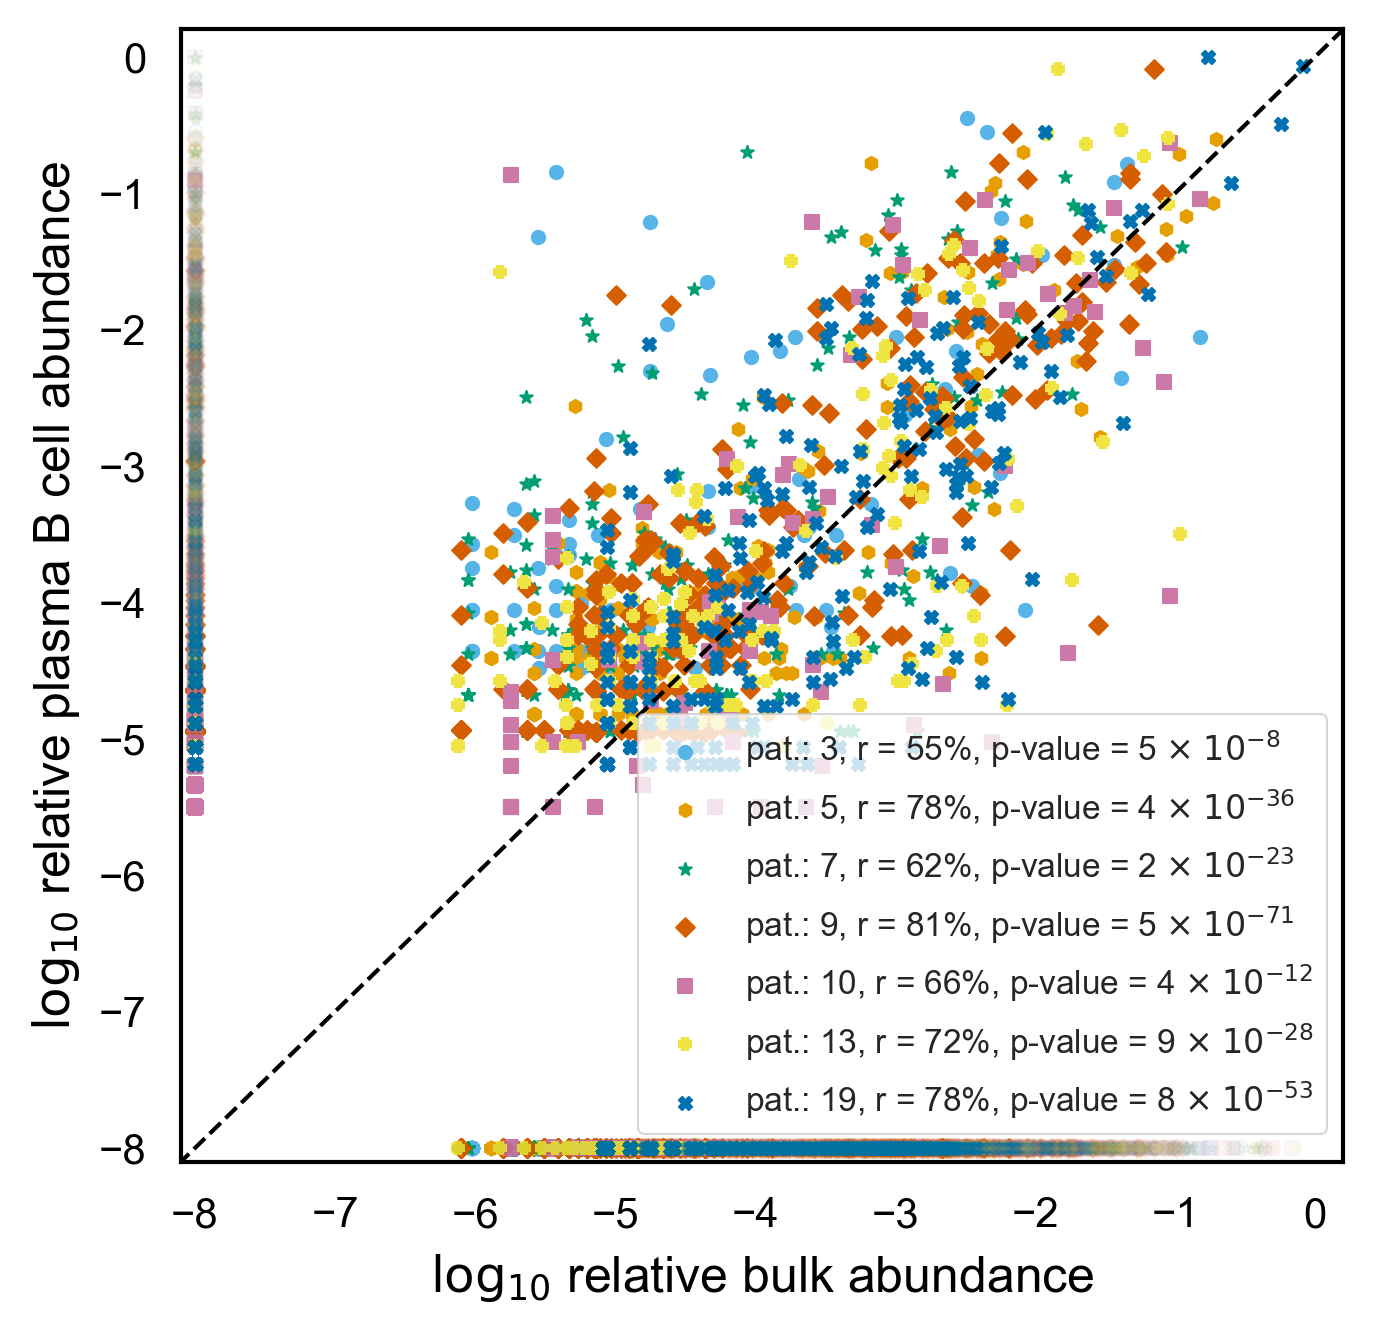

In [69]:
fig = plt.figure(dpi=global_dpi,figsize=(5,5))
ax = fig.add_subplot(111)
condition = ((lineages['bulk_abundance'] > 0)
             | (lineages['plasma_abundance'] > 0))
markers = ['o','h','*','D','s','+','X']
for i,p in enumerate(lineages.query('(plasma_abundance > 0) & (bulk_abundance > 0)')
                     .sort_values('patient_recode')
                     .patient_recode.unique()):
    cond = condition & (lineages['patient_recode'] == p)
    x = np.log10((lineages[cond]['norm_abun']+1e-8).tolist())
    y = np.log10((lineages[cond]['norm_plas_abun']+1e-8).tolist())
    overlap = (x>-7)&(y>-7)
    only_bulk = (y<=-7)
    only_plasma = (x<=-7)
    output = pearsonr(x[overlap],y[overlap])
    label='pat.: %i, r = %d%s, p-value = %.0f $\\times$ $10^{%d}$' %(int(p), 
                                             round(output[0]*100), '%',
                                             fman(output[1]), fexp(output[1]))
    ax.scatter(x[overlap],y[overlap],marker=markers[i],s=10,label=label,alpha=1.0,color=color[i])
    ax.scatter(x[only_bulk],y[only_bulk],alpha=0.05,marker=markers[i],s=10,color=color[i])
    ax.scatter(x[only_plasma],y[only_plasma],alpha=0.05,marker=markers[i],s=10,color=color[i])

ax.plot(np.arange(-20,2),np.arange(-20,2),
         '--',color='black',linewidth=1)

ax.set_xlim(-8.1,0.2)
ax.set_ylim(-8.1,0.2)
ax.set_xlabel('$\log_{10}$ relative bulk abundance')
ax.set_ylabel('$\log_{10}$ relative plasma B cell abundance')

ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.01),
          fancybox=True, prop={'family':'Arial', 'size':8})

fig.savefig('/usr/lusers/zacmon/covid_figures/Fig2_new.pdf',
            bbox_inches='tight')
fig.savefig('/usr/lusers/zacmon/covid_figures/Fig2_new.png',
            bbox_inches='tight')

# Plasma and expansion association

In [70]:
boxplot_subset = (lineages.reset_index()
 .set_index(['patient','v_gene','j_gene','cdr3','cluster_id'])
 .loc[df_fisher.set_index(['patient','v_gene','j_gene','cdr3','cluster_id']).index]
 .copy()
 .reset_index()
 .query('plasma_abundance != 0'))

/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


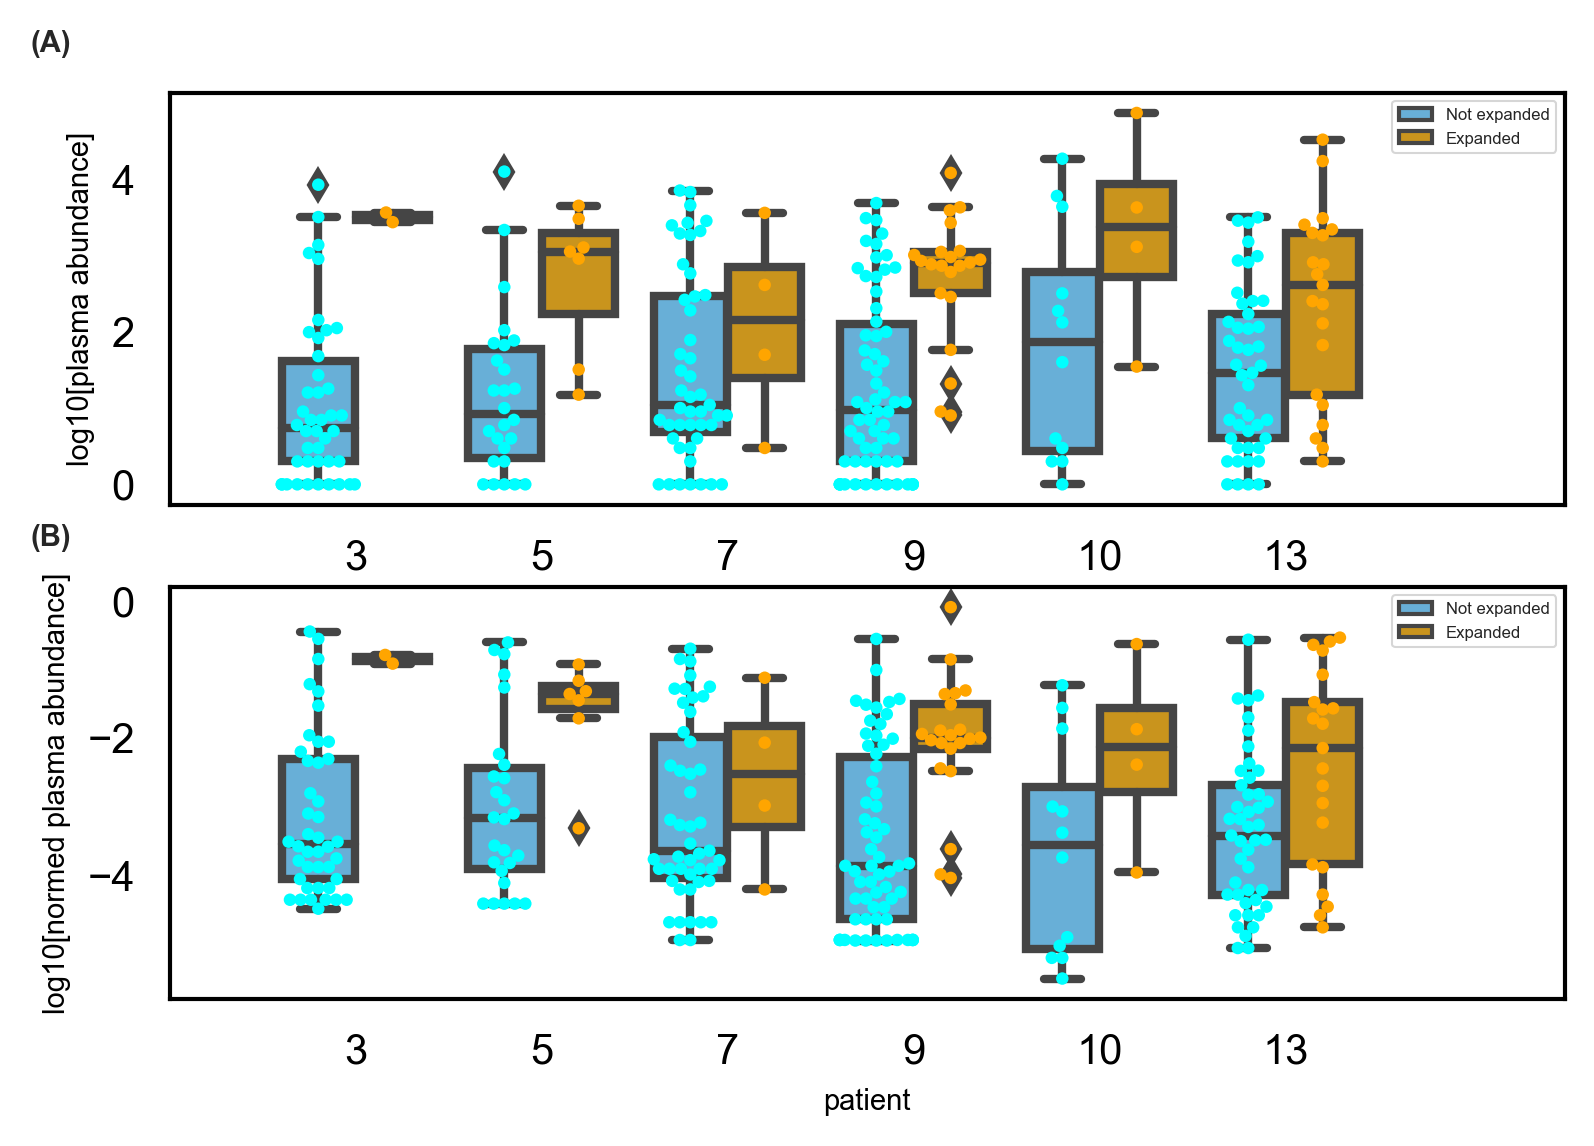

In [71]:
fig=plt.figure(dpi=global_dpi)
ax1=fig.add_subplot(211)
sns.boxplot(y=np.log10(boxplot_subset['plasma_abundance']),
            x=(boxplot_subset['patient_recode']),
            hue=(boxplot_subset.expanded == True),
            ax=ax1)
sns.swarmplot(y=np.log10(boxplot_subset['plasma_abundance']),
            x=(boxplot_subset['patient_recode']),
            hue=(boxplot_subset.expanded == True),
            ax=ax1,
              dodge=True,
              s=3,palette=["cyan", "orange"])
ax1.set_xlim(-1,6.5)
ax1.set_xticklabels([3,5,7,9,10,13,19])

handles, labels = ax1.get_legend_handles_labels()
labels = ['Not expanded','Expanded']
ax1.legend(handles[:2], labels[:2],fontsize=4)
ax1.set_ylabel('log10[plasma abundance]',fontsize=7)
ax1.set_xlabel('Patient',fontsize=7)

ax2=fig.add_subplot(212)
sns.boxplot(y=np.log10(boxplot_subset['norm_plas_abun']),
            x=(boxplot_subset['patient_recode']),
            hue=(boxplot_subset.expanded == True),
            ax=ax2)
sns.swarmplot(y=np.log10(boxplot_subset['norm_plas_abun']),
            x=(boxplot_subset['patient_recode']),
            hue=(boxplot_subset.expanded == True),
            ax=ax2,
              dodge=True,
              s=3,palette=["cyan", "orange"])
ax2.set_xlim(-1,6.5)
ax2.set_xticklabels([3,5,7,9,10,13,19])

handles, labels = ax2.get_legend_handles_labels()
labels = ['Not expanded','Expanded']
ax2.legend(handles[:2], labels[:2],fontsize=4)
ax2.set_xlabel('patient',fontsize=7)
ax2.set_ylabel('log10[normed plasma abundance]',fontsize=7)

for n, ax in enumerate([ax1,ax2]):
    ax.text(-0.1, 1.1, "("+string.ascii_uppercase[n]+")", transform=ax.transAxes, 
            size=7, weight='bold')

In [72]:
from statsmodels.stats.multitest import multipletests

anova_stat= {}
anova_p= {}
for pat in boxplot_subset.patient_recode.unique():
    exp_subset = (boxplot_subset.query('patient_recode == '+str(pat))
                 .query('expanded == True')
                 .norm_plas_abun.to_numpy())
    noexp_subset = (boxplot_subset.query('patient_recode == '+str(pat))
                 .query('expanded == False')
                 .norm_plas_abun.to_numpy())
    anova_output = f_oneway(exp_subset, noexp_subset)
    anova_stat[pat]= anova_output[0]
    anova_p[pat] = anova_output[1]
    
    f_val, p_val = f_oneway(exp_subset, noexp_subset)
    df_groups = 1
    df_sample_size = len(exp_subset) + len(noexp_subset) - 2
    print(pat,
          'F_{'+ str(df_groups) + ',' + str(df_sample_size) + '} =',
          str(round_to_n(f_val, 3)) + ',',
          'p-value =',
          round_to_n(p_val, 3))
    
corrected_anova_p = multipletests(list(anova_p.values()),method='bonferroni')[1]
anova_p_bon_corrected = {p: corrected_anova_p[i] for i,p in enumerate(anova_p)}

3 F_{1,42} = 5.39, p-value = 0.0252
5 F_{1,31} = 0.465, p-value = 0.5
7 F_{1,49} = 0.0116, p-value = 0.915
9 F_{1,81} = 4.15, p-value = 0.045
10 F_{1,14} = 2.91, p-value = 0.11
13 F_{1,64} = 7.7, p-value = 0.00722


# SONIA logo and logQ plots

In [73]:
import logomaker


def logQ_logo(sonia_dir):
    df = pd.read_csv(sonia_dir + 'features.tsv')
    df['Q'] = -df.Energy

    #  Only look at amino acid features
    df = df.loc[(df.Feature.str[0]=='a')].reset_index()
    df['position'] = df.Feature.str[2:].astype(int)
    df['letter'] = df.Feature.str[1].astype(str)

    q_dict = {}
    for letter in df.letter.unique():
        q_dict[letter] = (df
                          .query('letter == @letter')[['position','Q']]
                          .set_index('position')
                          .to_dict()['Q'])

    df_q = pd.DataFrame(q_dict)

    model_dict = {}
    data_dict = {}
    gen_dict = {}
    col = ['Marginal_model', 'Marginal_data', 'Marginal_gen']
    for i,d in enumerate([model_dict, data_dict, gen_dict]):
        for letter in df.letter.unique():
            d[letter] = (df
                         .query('letter == @letter')[['position',col[i]]]
                         .set_index('position')
                         .to_dict()[col[i]])
    df_model = pd.DataFrame(model_dict)
    df_data = pd.DataFrame(data_dict)
    df_gen = pd.DataFrame(gen_dict)

    for d in [df_model, df_data, df_gen]:
        for i in d.index:
            uncertainty = -np.sum(d.iloc[i] * np.log(d.iloc[i]))
            R = np.log2(20) - uncertainty
            d.iloc[i] = d.iloc[i]*R

    return df_data, df_q

/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


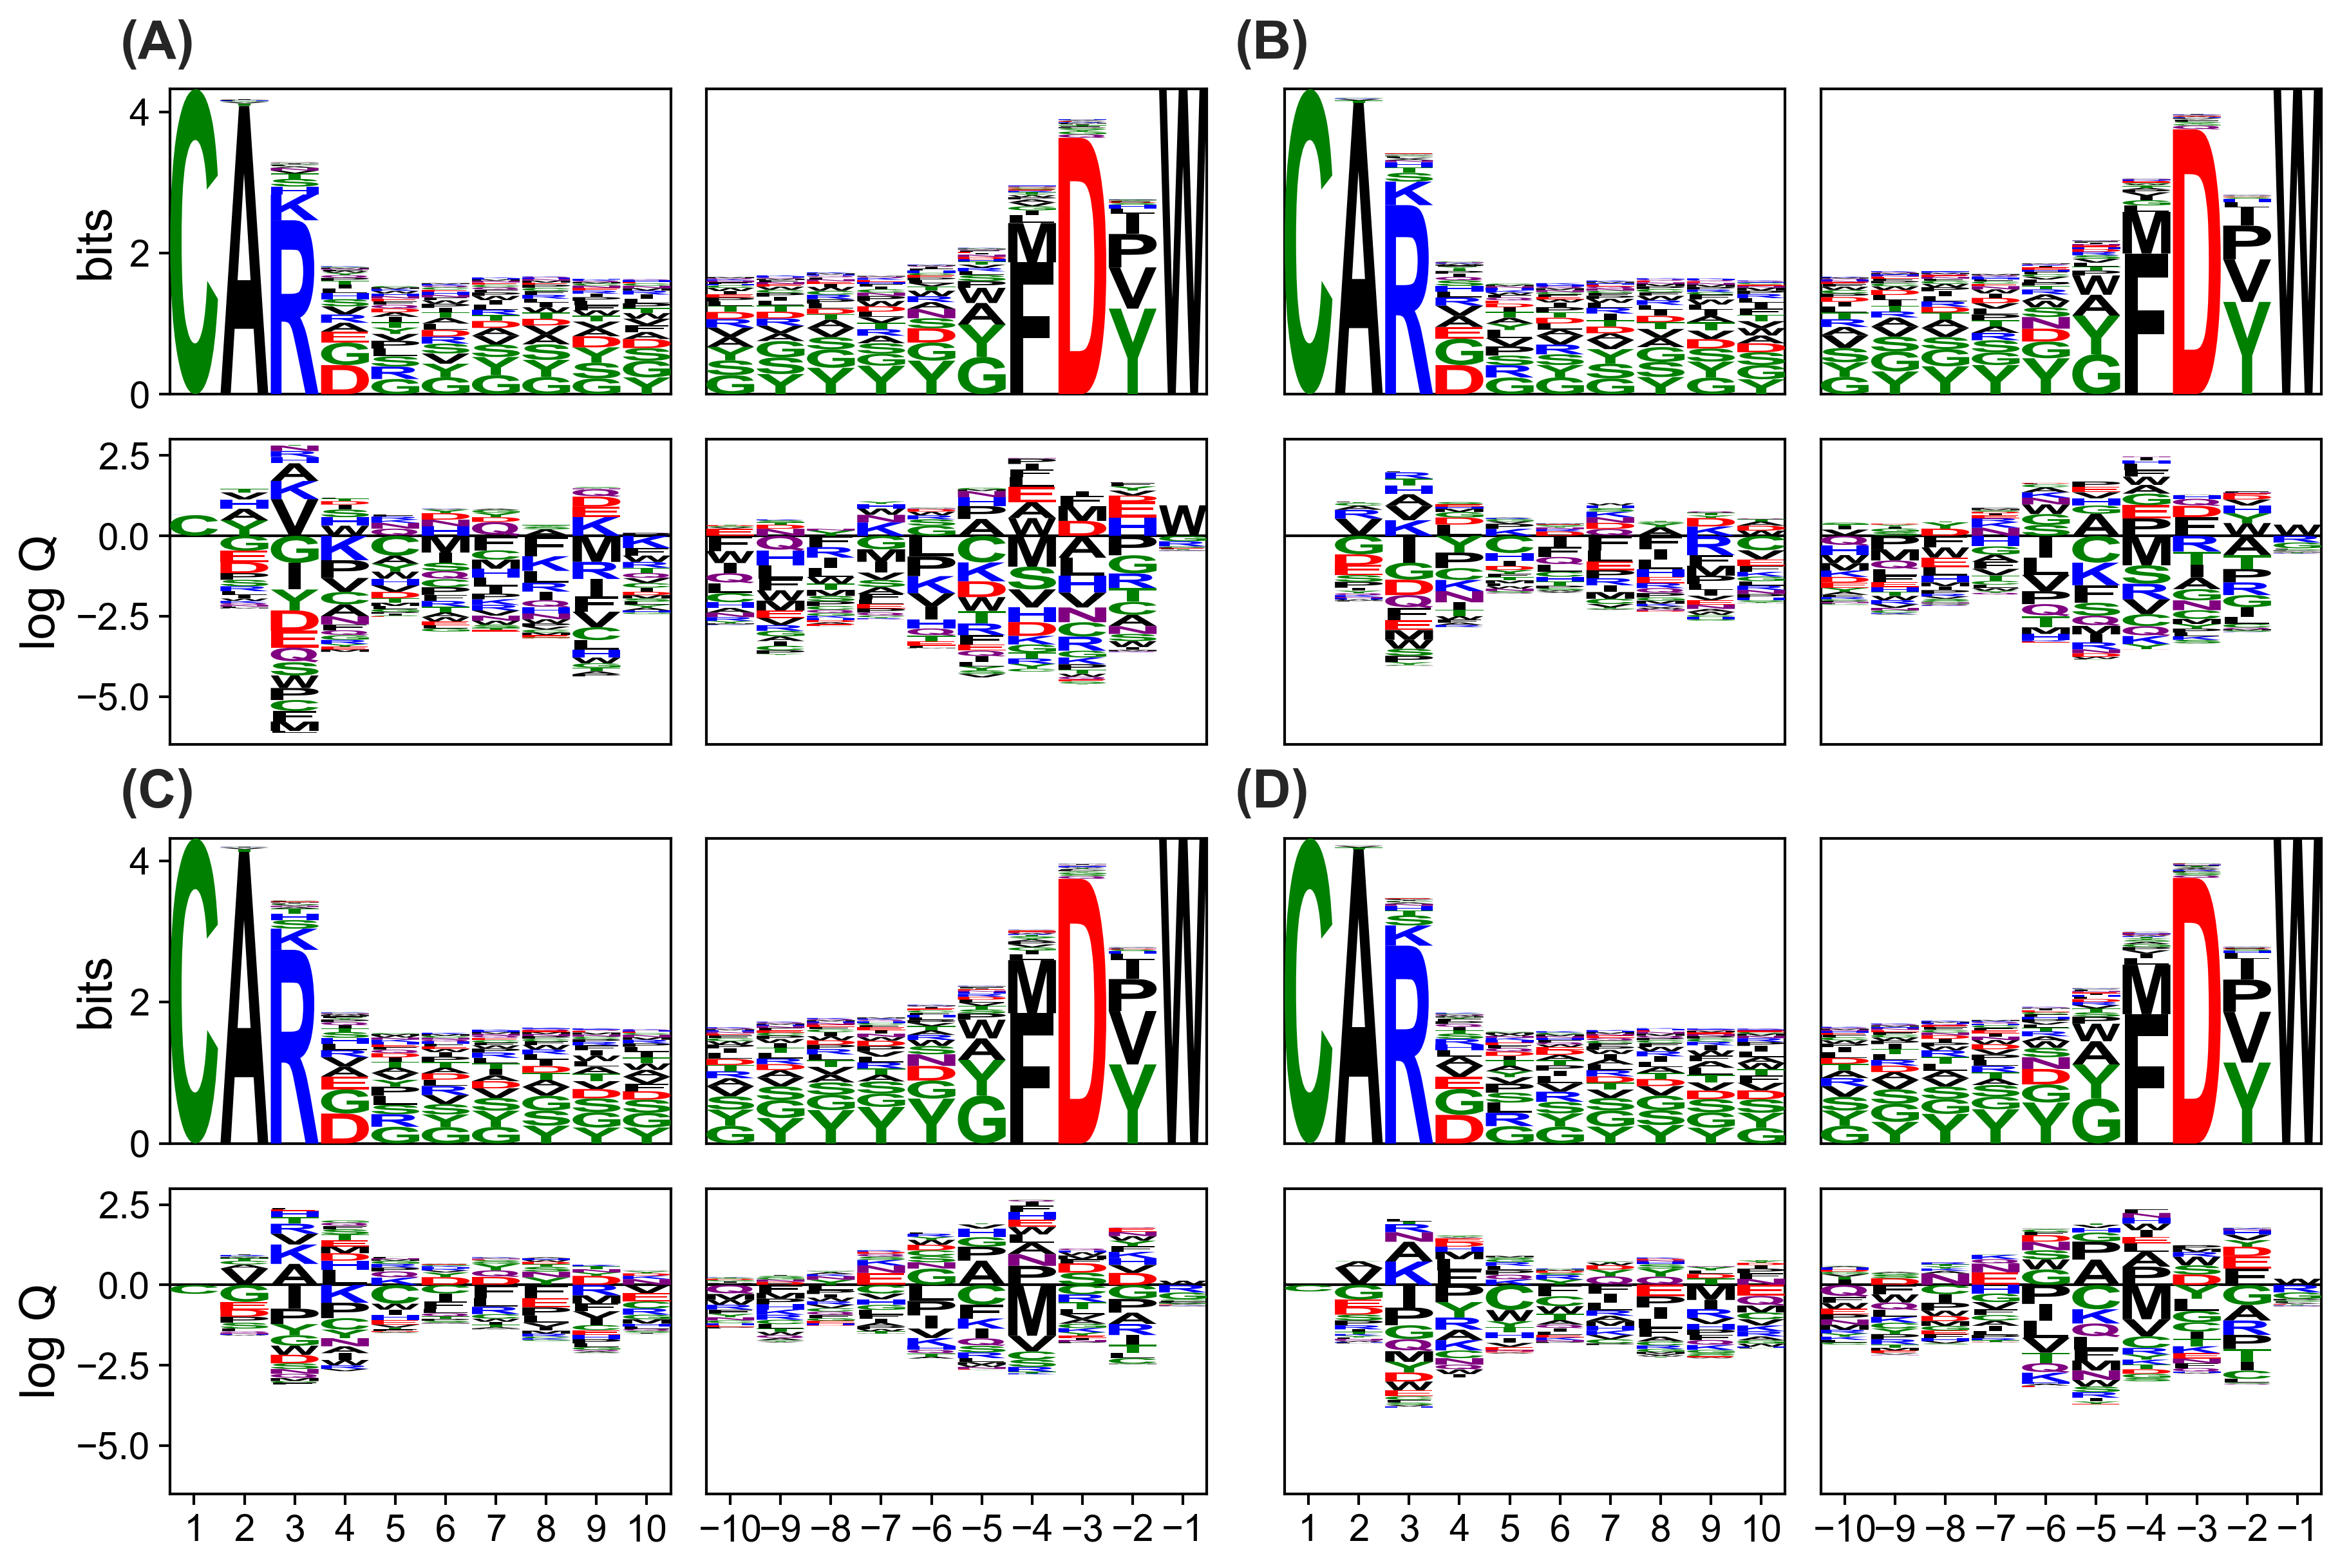

In [74]:
fig = plt.figure(dpi=global_dpi,figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(nrows=4, ncols=4, wspace=0.025, hspace=-0.05)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[1, 0])
ax14 = fig.add_subplot(gs[1, 1])

ax21 = fig.add_subplot(gs[0, 2])
ax22 = fig.add_subplot(gs[0, 3])
ax23 = fig.add_subplot(gs[1, 2])
ax24 = fig.add_subplot(gs[1, 3])

ax31 = fig.add_subplot(gs[2, 0])
ax32 = fig.add_subplot(gs[2, 1])
ax33 = fig.add_subplot(gs[3, 0])
ax34 = fig.add_subplot(gs[3, 1])

ax41 = fig.add_subplot(gs[2, 2])
ax42 = fig.add_subplot(gs[2, 3])
ax43 = fig.add_subplot(gs[3, 2])
ax44 = fig.add_subplot(gs[3, 3])

axes = [[ax11, ax12, ax13, ax14],
        [ax21, ax22, ax23, ax24],
        [ax31, ax32, ax33, ax34],
        [ax41, ax42, ax43, ax44]]
indir = '/gscratch/stf/zachmon/covid/total_bcell/sonia_model_10_16/L2_measurements/'
for idx, cohort in enumerate(['healthy','mild','moderate','severe']):
    data_marginals, qdata = logQ_logo(indir+cohort+'_1_L2_1e-3/')
    logomaker.Logo(data_marginals.iloc[0:10],
                   font_name='Arial',
                   stack_order='small_on_top',
                   flip_below=False,
                   color_scheme='chemistry',
                   ax=axes[idx][0],
                   zorder=10)
    logomaker.Logo(data_marginals.iloc[np.arange(-10,0)],
                   font_name='Arial',
                   stack_order='small_on_top',
                   flip_below=False,
                   color_scheme='chemistry',
                   ax=axes[idx][1],
                   zorder=10)
    axes[idx][0].get_xaxis().set_visible(False)
    axes[idx][1].get_xaxis().set_visible(False)
    axes[idx][1].get_yaxis().set_visible(False)
    axes[idx][0].set_ylabel('bits')
        
    axes[idx][2].axhline(0,color='black',linewidth=1)
    axes[idx][3].axhline(0,color='black',linewidth=1)
    crp_logo = logomaker.Logo(qdata.loc[np.arange(0,10)],
                              font_name='Arial',
                              stack_order='small_on_top',
                              flip_below=False,
                              color_scheme='chemistry',
                              ax=axes[idx][2],
                              zorder=10)
    crp_logo = logomaker.Logo(qdata.loc[np.arange(-10,0)],
                              font_name='Arial',
                              stack_order='small_on_top',
                              flip_below=False,
                              color_scheme='chemistry',
                              ax=axes[idx][3],
                              zorder=10)
    

    axes[idx][1].get_yaxis().set_visible(False)
    axes[idx][3].get_yaxis().set_visible(False)
    if idx % 2 == 0:
        axes[idx][0].set_ylabel('bits',fontsize=18)
        axes[idx][2].set_ylabel('log Q',fontsize=18)
        axes[idx][0].tick_params(axis='y', which='major', direction='out',length=4,
                                 bottom=False,top=False,left=True,right=False,
                                 labelsize=14, color='black')
        axes[idx][2].tick_params(axis='y', which='major', direction='out',length=4,
                                 bottom=False,top=False,left=True,right=False,
                                 labelsize=14, color='black')
    else:
        axes[idx][0].get_yaxis().set_visible(False)
        axes[idx][2].get_yaxis().set_visible(False)
                  
    axes[idx][0].get_xaxis().set_visible(False)
    axes[idx][1].get_xaxis().set_visible(False)
    if idx < 2:
        axes[idx][2].get_xaxis().set_visible(False)
        axes[idx][3].get_xaxis().set_visible(False)
    else:
        axes[idx][2].set_xticks(np.arange(0,10))
        axes[idx][2].set_xticklabels(np.arange(1,11))
        axes[idx][3].set_xticks(np.arange(-10,0))
        axes[idx][2].tick_params(axis='x', which='major', direction='out',length=4,
                                 bottom=True,top=False,left=False,right=False,
                                 labelsize=14, color='black')
        axes[idx][3].tick_params(axis='x', which='major', direction='out',length=4,
                                 bottom=True,top=False,left=False,right=False,
                                 labelsize=14, color='black')
    #print(axes[idx+1][0].get_ylim(), axes[idx+1][1].get_ylim())
    axes[idx][2].set_ylim(-6.5,3)
    axes[idx][3].set_ylim(-6.5,3)

    axes[idx][0].text(-0.1, 1.1, "("+string.ascii_uppercase[idx]+")", transform=axes[idx][0].transAxes, 
            size=20, weight='bold')
    
fig.savefig('/usr/lusers/zacmon/covid_figures/FigS6_new.pdf',
            bbox_inches='tight')
fig.savefig('/usr/lusers/zacmon/covid_figures/FigS6_new.png',
            bbox_inches='tight')

# SONIA ppost plot

In [75]:
def get_length_feats(df):
    return df[(df['Feature'].str.contains('l'))
                        & (~df['Feature'].str.contains('v'))]['Energy']

def get_length_gauge(df):
    return (df[(df['Feature'].str.contains('l'))
                        & (~df['Feature'].str.contains('v'))]['Marginal_model']*get_length_feats(df)).sum()

def get_aa_feats(df):
    return df[(df['Feature'].str.contains('a'))]['Energy']

def get_v_feats(df):
    return df[(df['Feature'].str.contains('v'))].sort_values(axis=0,by='Feature')['Energy']

def get_j_feats(df):
    return df[(df['Feature'].str.contains('j'))].sort_values(axis=0,by='Feature')['Energy']

def get_corr(dfs1,dfs2):
    cdr3_length = []
    aa_usage = []
    v_usage = []
    
    for i,df1 in enumerate(dfs1):
        for j, df2 in enumerate(dfs2):
            #  sample size = 30
            length1 = get_length_feats(df1)
            length2 = get_length_feats(df2)
            lengthcorr = np.corrcoef(length1,length2)[0,1]
            
            #  sample size = 1000
            aa1 = get_aa_feats(df1)
            aa2 = get_aa_feats(df2)
            aacorr = np.corrcoef(aa1,aa2)[0,1]
            
            #  sample size = 54
            v1 = get_v_feats(df1)
            v2 = get_v_feats(df2)
            vcorr = np.corrcoef(v1,v2)[0,1]
            
            cdr3_length.append(lengthcorr)
            aa_usage.append(aacorr)
            v_usage.append(vcorr)
    return np.array(v_usage), np.array(cdr3_length), np.array(aa_usage)

In [76]:
indir = '/gscratch/stf/zachmon/covid/total_bcell/sonia_model_10_16/L2_measurements/'
healthy_ds = [indir+'healthy_' + str(i) + '_L2_1e-3'
      for i in range(1,21)]
mild_ds = [indir+'mild_' + str(i) + '_L2_1e-3'
      for i in range(1,21)]
moderate_ds = [indir+'moderate_' + str(i) + '_L2_1e-3'
      for i in range(1,21)]
severe_ds = [indir+'severe_' + str(i) + '_L2_1e-3'
      for i in range(1,21)]
cohorts = ['healthy','mild','moderate','severe',]

feature_dfs = {i: [pd.read_csv(df+'/features.tsv').sort_values('Feature')
                 for df in [healthy_ds[i], mild_ds[i], moderate_ds[i], severe_ds[i]]]
                 for i in range(20)}

In [77]:
output = {(i,j): get_corr(feature_dfs[i], feature_dfs[j])
          for i in feature_dfs for j in feature_dfs if i >= j}

In [78]:
def get_entropy(grp):
    ppost = grp.ppost.to_numpy()[np.where(grp.ppost > -40)]
    return -np.mean(np.log2(10**ppost))

print(all_lineages.query('bulk_abundance > 0')
 .groupby(['patient','severity'])
 .apply(get_entropy)
 .rename('ppost')
 .reset_index()
 .groupby('severity')
 .agg({'ppost':['mean','std','count']})
 .assign(adjusted_std = lambda df: df[('ppost',   'std')]/ np.sqrt(df[('ppost', 'count')]))
  .reset_index()
[[('severity',''),('ppost',  'mean'),('adjusted_std','')]])

   severity      ppost adjusted_std
                  mean             
0   healthy  39.814395     0.301859
1      mild  41.936874     0.697004
2  moderate  42.661376     0.320629
3    severe  42.888915     0.521001


In [79]:
print(all_lineages.query('plasma_abundance > 0')
 .groupby(['patient','severity'])
 .apply(get_entropy)
 .rename('ppost')
 .reset_index()
 .groupby('severity')
 .agg({'ppost':['mean','std','count']})
 .assign(adjusted_std = lambda df: df[('ppost',   'std')]/ np.sqrt(df[('ppost', 'count')]))
 .reset_index()
[[('severity',''),('ppost',  'mean'),('adjusted_std','')]])

   severity      ppost adjusted_std
                  mean             
0  moderate  40.823788     0.504189
1    severe  40.851882          NaN


In [80]:
synthetic_dir = '/gscratch/stf/zachmon/covid/total_bcell/sonia_model_10_16/L2_measurements/'
cohorts = ['healthy','mild','moderate','severe']
dfs_500000 = [pd.read_csv(synthetic_dir+'synethic_'+c+'_evaluated.csv')
              for c in cohorts]
for idx, c in enumerate(cohorts):
    print(c, np.mean(-np.log2(dfs_500000[idx].query('Ppost >= 1e-40').Ppost)))

healthy 39.19648135922603
mild 41.213904085719335
moderate 41.869775403646614
severe 41.817246540652505


/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in arctanh
/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in arctanh
/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in arctanh


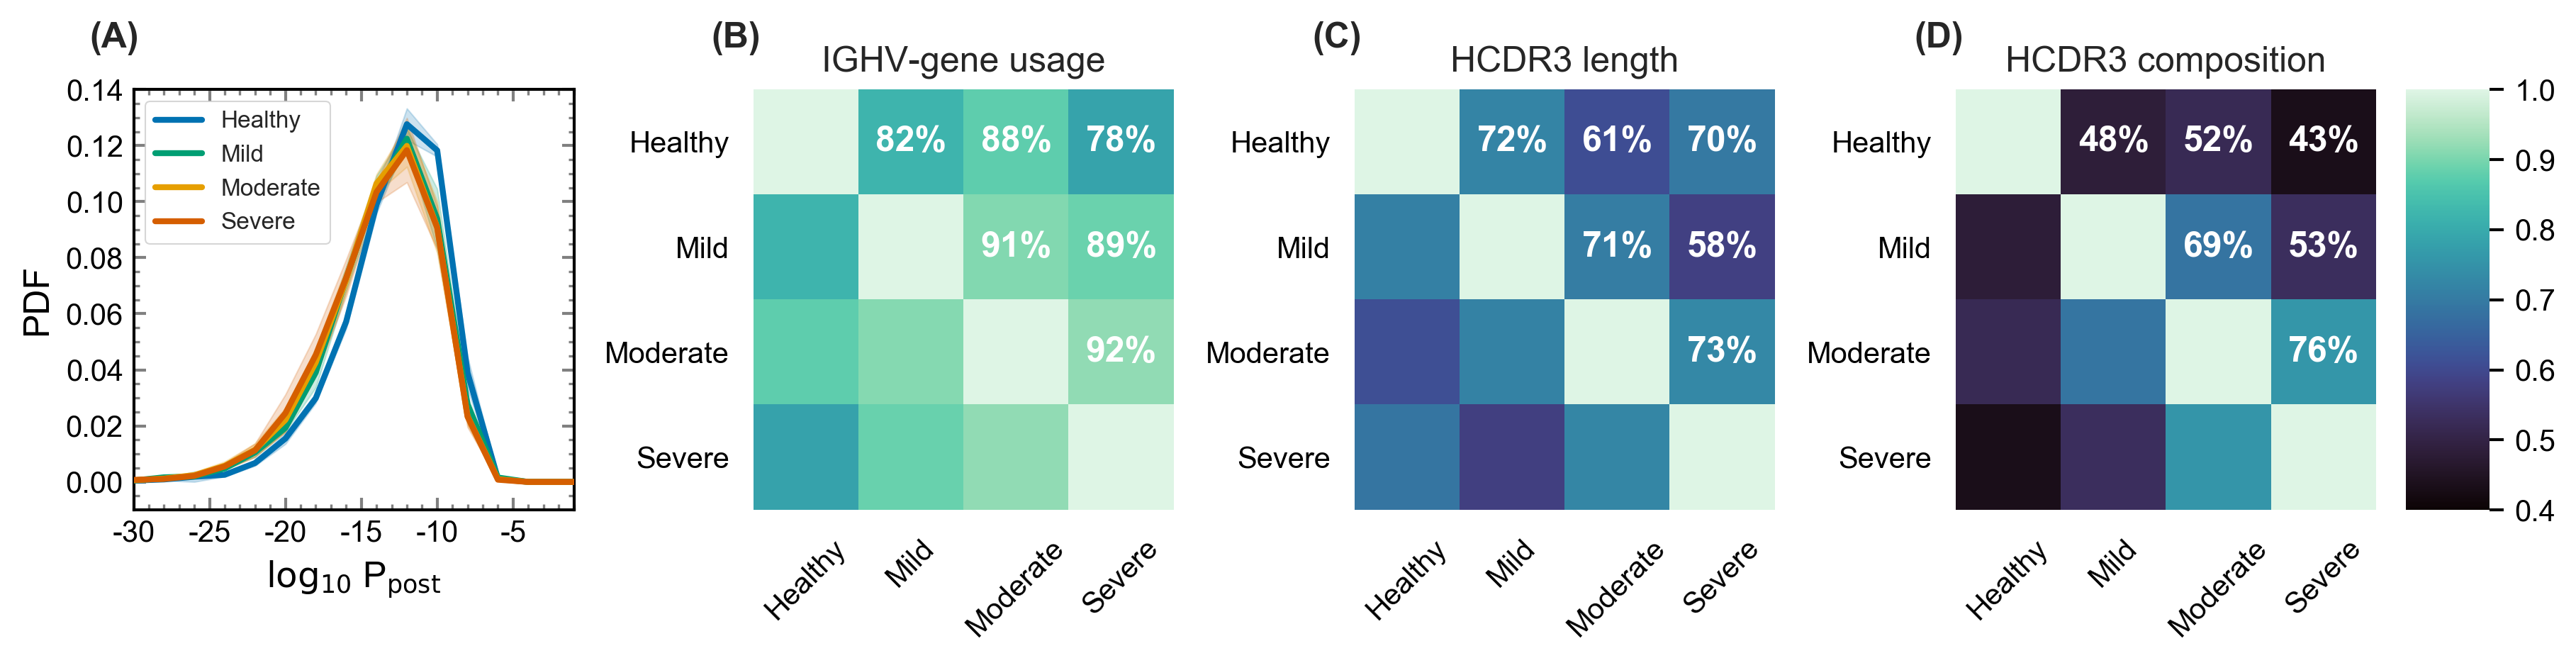

In [81]:
def ppost_bin(grp):
    freqs,bins = np.histogram(grp, np.linspace(-30,2,17), density=True)
    return tuple(freqs)
def average_bin_ppost(grp):
    avgs = []
    stds = []
    for idx, _ in enumerate(list(grp)[0]):
        avgs.append(np.mean([g[idx] for g in grp]))
        stds.append(np.std([g[idx] for g in grp]))
    return tuple([np.array(avgs), np.array(stds)])

linspace = np.linspace(-30,2,17)

fig = plt.figure(dpi=global_dpi,figsize=(12,3),constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=4, wspace=0.025, hspace=0.05)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

ppost_for_hist = (all_lineages.query('bulk_abundance > 0')
 .groupby(['patient','severity'])
 .agg({'ppost': ppost_bin})
 .reset_index()
 .groupby('severity')
 .agg({'ppost': average_bin_ppost}))

hist_colors = ["#0072B2","#009E73","#E69F00","#D55E00"]
labels = ['Healthy','Mild','Moderate','Severe']
bins=linspace[:-1]
for i, s in enumerate(ppost_for_hist.index):
    ax1.plot(bins,ppost_for_hist.loc[s][0][0],zorder=3,color=hist_colors[i],label=labels[i])
    ax1.fill_between(bins, ppost_for_hist.loc[s][0][0] - ppost_for_hist.loc[s][0][1],
                   ppost_for_hist.loc[s][0][0] + ppost_for_hist.loc[s][0][1],alpha=0.2,
                    color=hist_colors[i])
ax1.legend(loc='upper left')
ax1.set_yticks(np.arange(0,0.16,0.02))
ax1.set_xticks(np.arange(-30,0,5))
ax1.set_xticklabels(np.arange(-30,0,5))
ax1.set_xlim(-30,-1)
ax1.set_ylim(-0.01,0.14)
ax1.set_ylabel('PDF')
ax1.set_xlabel('$\log_{10}$ P$_{\mathrm{post}}$')
format_axes(ax1)


ax2.set_title('IGHV-gene usage')
ax3.set_title('HCDR3 length')
ax4.set_title('HCDR3 composition')
mat_axes = [ax2, ax3, ax4]
mask = np.zeros_like(output[1,1][0].reshape([4,4]), dtype=np.bool)
mask[np.triu_indices_from(mask,k=1)] = True

feature_sizes = {0: 54, 1: 30, 2: 1000}

for i,_ in enumerate(output[(1,1)]):
    corr_mean = np.array([np.tanh(np.mean([np.arctanh(output[key][i][j]) for key in output]))
                 for j in range(16)]).reshape([4,4])# if i % 5 != 0]
    lower_error_bound = np.array([np.tanh(np.mean([np.arctanh(output[key][i][j]) for key in output])
                              - 1/np.sqrt(20*(feature_sizes[i]-3)))
                     for j in range(16)]).reshape([4,4])
    upper_error_bound = np.array([np.tanh(np.mean([np.arctanh(output[key][i][j]) for key in output])
                              + 1/np.sqrt(20*(feature_sizes[i]-3)))
                     for j in range(16)]).reshape([4,4])
    lower_error = (corr_mean - lower_error_bound)
    upper_error = (upper_error_bound - corr_mean)
    
    lower_error_str = np.round(lower_error*100,decimals=1).astype(str)
    upper_error_str = np.round(upper_error*100,decimals=1).astype(str)
    
    corr_str = np.round(corr_mean*100).astype(int).astype(str)
    for r in range(4):
        for c in range(4):
            if c <= r:
                corr_str[r,c] = ''
            else:
                corr_str[r,c] = (r'%s%s' 
                                 % (corr_str[r,c],'%'))
                
    cbar = False
    if i == 2:
        cbar = True
        
    h = sns.heatmap(corr_mean,ax=mat_axes[i], cbar=cbar, square=True,
                    annot=corr_str,fmt="",
                    annot_kws={'fontfamily':'Arial','weight':'bold','color':'white', 'size':12},
                yticklabels=labels, xticklabels=labels, 
                vmin=0.4, vmax=1.0, cmap="mako")
    h.set_yticklabels(labels, rotation=0)
    h.set_xticklabels(labels, rotation=45)
    
for n, ax in enumerate([ax1, ax2, ax3,ax4]):
    ax.text(-0.1, 1.1, "("+string.ascii_uppercase[n]+")", transform=ax.transAxes, 
            size=12, weight='bold')
    
fig.savefig('/usr/lusers/zacmon/covid_figures/Fig4_new.pdf',
            bbox_inches='tight')
fig.savefig('/usr/lusers/zacmon/covid_figures/Fig4_new.png',
            bbox_inches='tight')

/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in arctanh
/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in arctanh
/gscratch/stf/zachmon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in arctanh


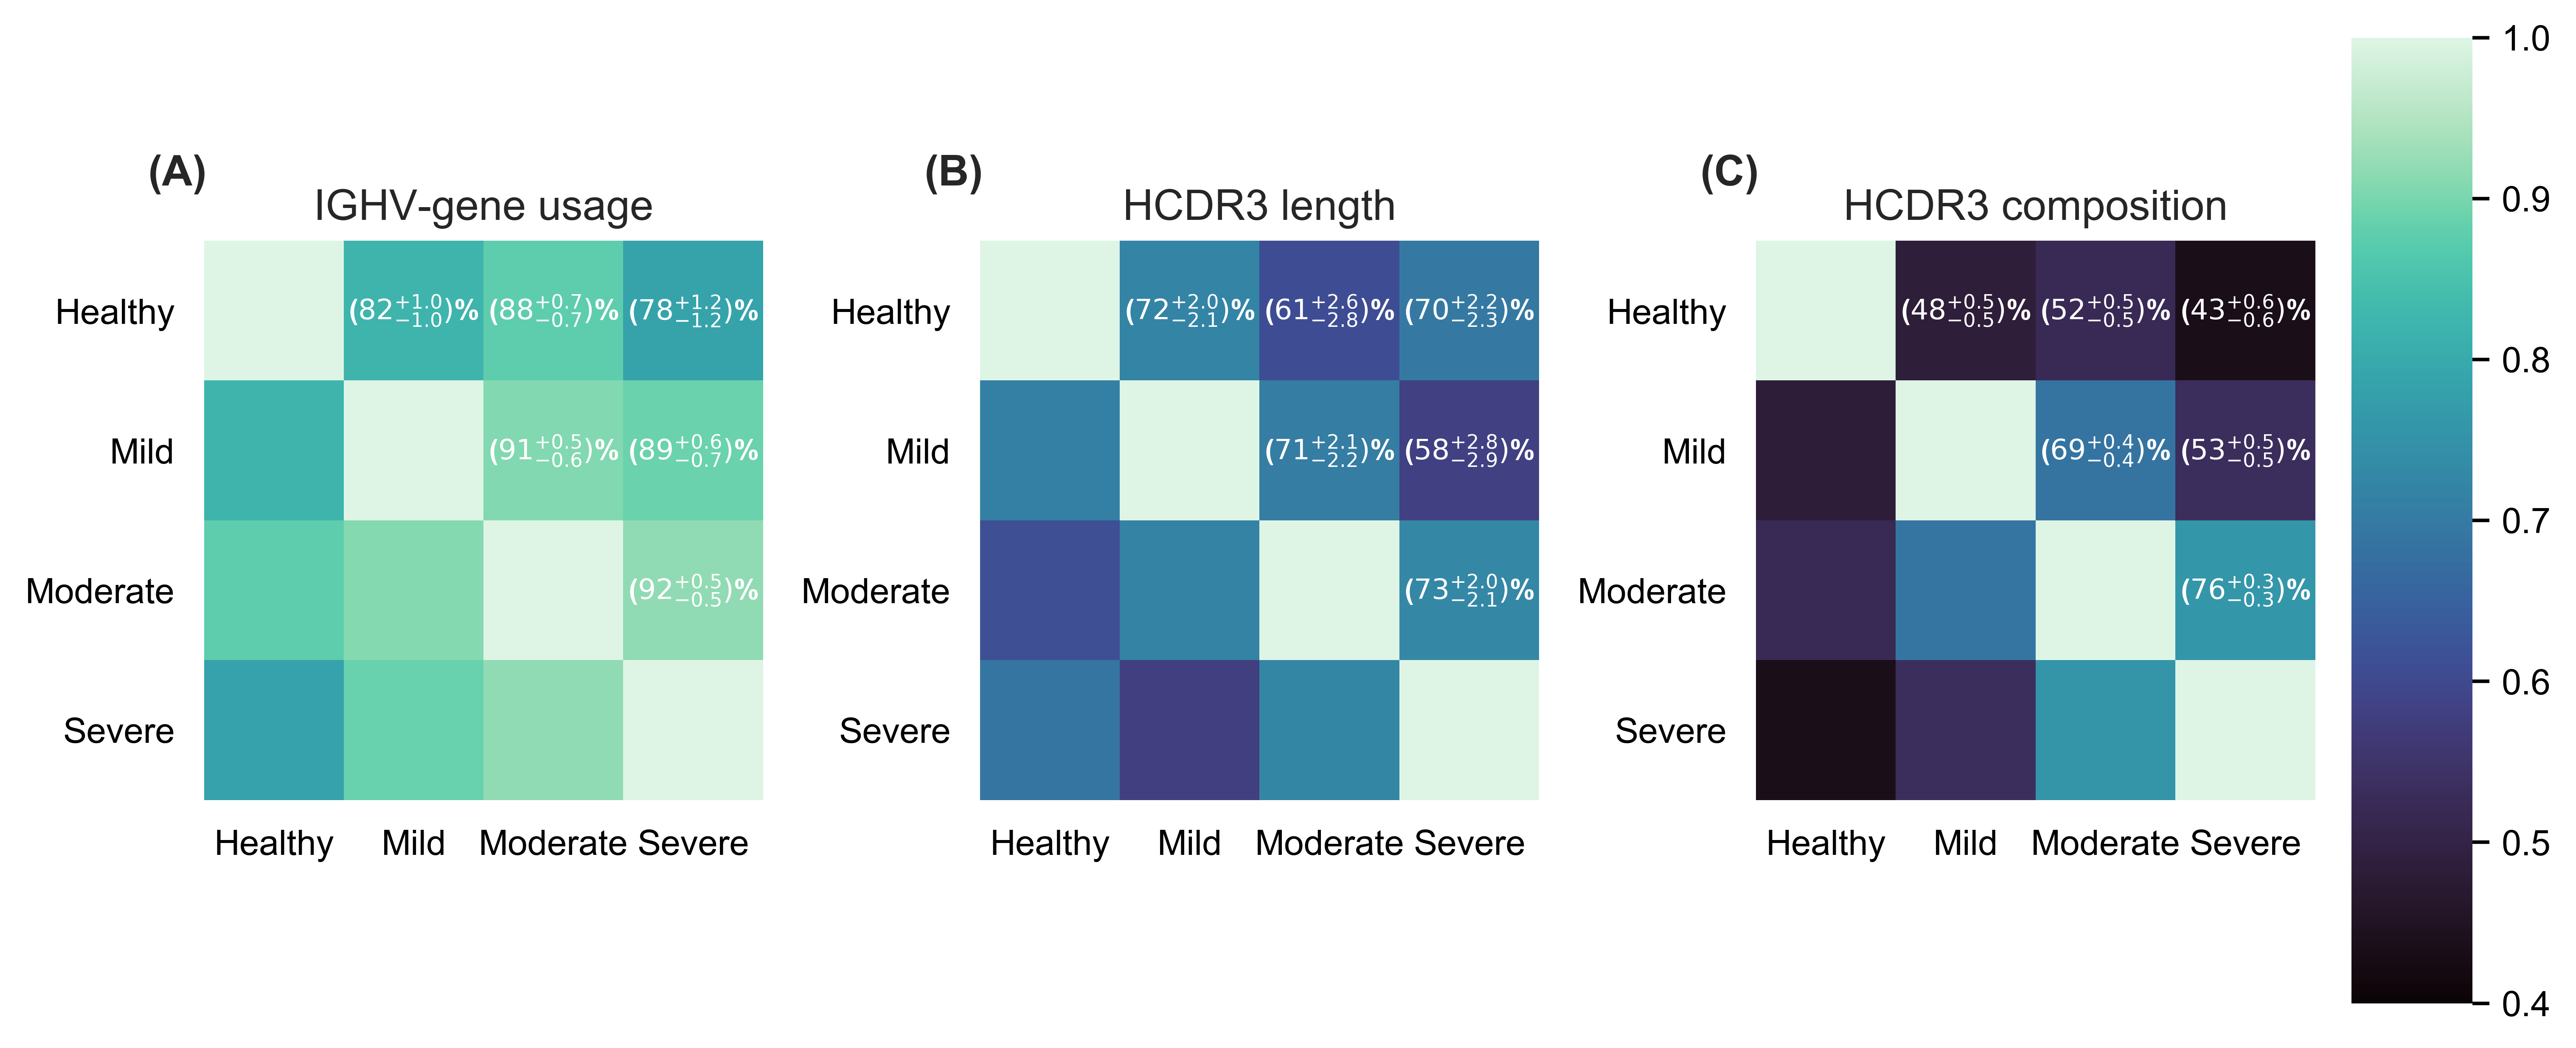

In [82]:
def ppost_bin(grp):
    freqs,bins = np.histogram(grp, np.linspace(-30,0,16), density=True)
    return tuple(freqs)
def average_bin_ppost(grp):
    avgs = []
    stds = []
    for idx, _ in enumerate(list(grp)[0]):
        avgs.append(np.mean([g[idx] for g in grp]))
        stds.append(np.std([g[idx] for g in grp]))
    return tuple([np.array(avgs), np.array(stds)])

linspace = np.linspace(-30,0,16)

fig = plt.figure(dpi=600,figsize=(10,4),constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=3, wspace=0.025, hspace=0.05)
ax3 = fig.add_subplot(gs[0,0])
ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[0,2])

ax3.set_title('IGHV-gene usage')
ax4.set_title('HCDR3 length')
ax5.set_title('HCDR3 composition')
mat_axes = [ax3, ax4, ax5]
mask = np.zeros_like(output[1,1][0].reshape([4,4]), dtype=np.bool)
mask[np.triu_indices_from(mask,k=1)] = True

feature_sizes = {0: 54, 1: 30, 2: 1000}

for i,_ in enumerate(output[(1,1)]):
    corr_mean = np.array([np.tanh(np.mean([np.arctanh(output[key][i][j]) for key in output]))
                 for j in range(16)]).reshape([4,4])
    lower_error_bound = np.array([np.tanh(np.mean([np.arctanh(output[key][i][j]) for key in output])
                              - 1/np.sqrt(20*(feature_sizes[i]-3)))
                     for j in range(16)]).reshape([4,4])
    upper_error_bound = np.array([np.tanh(np.mean([np.arctanh(output[key][i][j]) for key in output])
                              + 1/np.sqrt(20*(feature_sizes[i]-3)))
                     for j in range(16)]).reshape([4,4])
    lower_error = (corr_mean - lower_error_bound)
    upper_error = (upper_error_bound - corr_mean)
    
    lower_error_str = np.round(lower_error*100,decimals=1).astype(str)
    upper_error_str = np.round(upper_error*100,decimals=1).astype(str)
    
    corr_str = np.round(corr_mean*100).astype(int).astype(str)
    for r in range(4):
        for c in range(4):
            if c <= r:
                corr_str[r,c] = ''
            else:
                corr_str[r,c] = (r'($%s_{-%s}^{+%s})$%s' 
                                 % (corr_str[r,c], lower_error_str[r,c], upper_error_str[r,c], '%'))
                
    cbar = False
    if i == 2:
        cbar = True
        
    h = sns.heatmap(corr_mean,ax=mat_axes[i], cbar=cbar, square=True,
                    annot=corr_str,fmt="",
                    annot_kws={'fontfamily':'Arial','weight':'bold','color':'white', 'size':8},
                yticklabels=labels, xticklabels=labels, 
                vmin=0.4, vmax=1.0, cmap="mako")
    h.set_yticklabels(labels, rotation=0)
    
for n, ax in enumerate([ax3, ax4, ax5,]):
    ax.text(-0.1, 1.1, "("+string.ascii_uppercase[n]+")", transform=ax.transAxes, 
            size=12, weight='bold')